This notebook was run in Julia 1.6. The following Julia packages are used in this note book.

DifferentialEquations, Flux, DiffEqFlux, Optim, DiffEqSensitivity, Plots, OrdinaryDiffEq, Zygote, StaticArrays, LinearAlgebra, BenchmarkTools, PaddedViews

These packages can be installed using the following commands:
```
using Pkg;
Pkg.add(["OrdinaryDiffEq","DifferentialEquations", "Flux", "DiffEqFlux", "Optim", "DiffEqSensitivity", "Plots", "Zygote", "StaticArrays", "BenchmarkTools", "PaddedViews","NLopt","BlackBoxOptim", "DiffEqBase"]);
```

In [1]:
using DifferentialEquations, DiffEqSensitivity, Plots, OrdinaryDiffEq, Optim, Zygote, StaticArrays, LinearAlgebra, BenchmarkTools, PaddedViews
using NLopt,BlackBoxOptim, DiffEqBase, Flux, DiffEqFlux

┌ Warning: Error requiring `ParameterizedFunctions` from `Latexify`
│   exception = (LoadError("C:\\Users\\Fernando\\.julia\\packages\\Latexify\\kPsTM\\ext\\ParameterizedFunctionsExt.jl", 1, UndefVarError(:DiffEqBase)), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00000000017f4941, Ptr{Nothing} @0x0000000001880c94, Ptr{Nothing} @0x0000000001881202, Ptr{Nothing} @0x0000000001880e14, Ptr{Nothing} @0x0000000001881768, Ptr{Nothing} @0x00000000018823a5, Base.InterpreterIP in top-level CodeInfo for Latexify.ParameterizedFunctionsExt at statement 2, Ptr{Nothing} @0x000000000189e9a7, Ptr{Nothing} @0x000000000189f1ea, Ptr{Nothing} @0x000000000189f4e1, Ptr{Nothing} @0x00000000018a042f, Ptr{Nothing} @0x000000000df6245b, Ptr{Nothing} @0x000000000de81faf, Ptr{Nothing} @0x000000000da75a18, Ptr{Nothing} @0x00000000018756a6, Ptr{Nothing} @0x000000001e7171b6, Ptr{Nothing} @0x000000000188121c, Ptr{Nothing} @0x0000000001880e14, Ptr{Nothing} @0x0000000001881768, Ptr{Nothing} @0x00000000018823a5

In [2]:
gr(show = :ijulia) #for the implementation of the callback function for the optimization requires plots to be shown in the middle of a cell evalutation

Plots.GRBackend()

First the constants used in Schroedinger equation are defined

In [3]:
const σ0 = Hermitian(Complex{Float64}[1 0; 0 1]);
const σx = Hermitian(Complex{Float64}[0 1; 1 0]);
const σy = Hermitian(Complex{Float64}[0 -im; im 0]);
const σz = Hermitian(Complex{Float64}[1 0; 0 -1]);
const IIX = kron(σ0,kron(σ0,σx));
const III = kron(σ0,kron(σ0,σ0));
const IIY = kron(σ0,kron(σ0,σy));
const IXI = kron(σ0,kron(σx,σ0));
const IYI = kron(σ0,kron(σy,σ0));
const XII = kron(σx,kron(σ0,σ0));
const YII = kron(σy,kron(σ0,σ0));
const ZZI = kron(σz,kron(σz,σ0));
const IZZ = kron(σ0,kron(σz,σz));
const ZII = kron(σz,kron(σ0,σ0));
const IZI = kron(σ0,kron(σz,σ0));
const IIZ = kron(σ0,kron(σ0,σz));
const XXI = kron(σx,kron(σx,σ0));
const YYI = kron(σy,kron(σy,σ0));
const IYY = kron(σ0,kron(σy,σy));
const IXX = kron(σ0,kron(σx,σx));
const IXY = kron(σ0,kron(σx,σy));
const IYX = kron(σ0,kron(σy,σx));
const YXI = kron(σy,kron(σx,σ0));
const XYI = kron(σx,kron(σy,σ0));
const itoffoli2 = Complex{Float64}[1 0 0 0 0 0 0 0; 0 1 0 0 0 0 0 0; 0 0 1 0 0 0 0 0; 0 0 0 1 0 0 0 0; 0 0 0 0 1 0 0 0; 0 0 0 0 0 0 0 im; 0 0 0 0 0 0 1 0; 0 0 0 0 0 im 0 0];

In [4]:
# Define the NN with two 32 middle layers which is sufficiently large to find a solution for this problem.
nn = FastChain(FastDense(1,32), FastDense(32,32,tanh),FastDense(32,32,tanh), FastDense(32,6))
nn_initial_params = initial_params(nn);

In [5]:
# device constants from Section II in MHz units
J0=0.056;         #residual exchange
Jmax=10;          #maximum exchange
Ωmax=10/sqrt(2);  #maximum total driving strength on all qubits
Ez1=5;            #Zeeman energy splitting between the qubits taken to be constant here 
Ez2=2*Ez1;
Ez3=3*Ez1;
T=π*2;            #pulse duration T is set to 0.85*π for the non robust pulses

# parameters for the envelope which ensures (i) the driving vanishes at t=0 and t=T (ii) ramping is smooth / non-abrupt
envelope(t) = coth(20*T/4)*( tanh(20*t/(4)) - tanh(20*(t-T)/(4)) ) - 1;

Define the ODEs and the cost function, C, Eq.(6) which uses the ODEs 

In [6]:
#ODE function that defines the derivatives for Schroedinger equation as well as the robustness condition
function schrodinger(u,p,t) #p in this case will the the neural network parameters and virtual-z gate angles that will be optimized
    
    @views U = u[1:8,1:8]  #upper 8x8 is Schrodinger equation 
    
    #input normallized time t/T as input into nn with parameters p
    nnoutput=nn([t/T],p[1:end-3])
    #control fields are each one output of the nn and then transformed as needed to fit the physical constraints on the control field
    @views J1 = J0 + Jmax*envelope(t)*sin(nnoutput[1])^2  #either J can be set to J0 when not needed such as for the CZ and X gates
    @views J2 = J0 + Jmax*envelope(t)*sin(nnoutput[2])^2 
    @views Ω1 = Ωmax/2*envelope(t)*sin(nnoutput[3])       #Ω1  here is already devided by 2 which therefor it is equivlenet to omega/2 in eq.2
    @views Ω2 = 0       #in this work only the outer two qubits were driven but three qubit driving is possible with this notebook
    @views Ω3 = Ωmax/2*envelope(t)*sin(nnoutput[4])
    @views ϕ1 = nnoutput[5]
    @views ϕ2 = 0
    @views ϕ3 = nnoutput[6]
    
    #Hamiltonian parts split into simplified pieces
    H = Ω1*(cos(ϕ1)*XII-sin(ϕ1)*YII)+Ω2*(cos(ϕ2)*IXI-sin(ϕ2)*IYI)+Ω3*(cos(ϕ3)*IIX-sin(ϕ3)*IIY);
    H31=J1/4*((XXI+YYI)cos((Ez1-Ez2)*t)+(XYI-YXI)sin((Ez1-Ez2)*t))+J1/4*ZZI;
    H32=J2/4*((IXY-IYX)sin((Ez2-Ez3)*t)+(IXX+IYY)cos((Ez2-Ez3)*t))+J2/4*IZZ;
    H2=Ω1*(cos((Ez1-Ez2)*t+ϕ1)*IXI-sin((Ez1-Ez2)*t+ϕ1)*IYI+cos((Ez1-Ez3)*t+ϕ1)*IIX-sin((Ez1-Ez3)*t+ϕ1)*IIY)+Ω2*(cos((Ez2-Ez3)*t+ϕ2)*IIX-sin((Ez2-Ez3)*t+ϕ2)*IIY+cos((Ez2-Ez1)*t+ϕ2)*XII-sin((Ez2-Ez1)*t+ϕ2)*YII)+Ω3*(cos((Ez3-Ez1)*t+ϕ3)*XII-sin((Ez3-Ez1)*t+ϕ3)*YII+cos((Ez3-Ez2)*t+ϕ3)*IXI-sin((Ez3-Ez2)*t+ϕ3)*IYI);  
    Htot=H+H2+H31+H32;
    #Calculating the order mangus expansion of the error in J1 and J2 fluctuations with this differential equation
    dℰ1=U'*H31*U;
    dℰ2=U'*H32*U;
    return [-im*(Htot)*U;  dℰ1; dℰ2] # return [U'(t); ℰ'(t)] where ℰ is the robustness condition
end

U0 =[III; 0*III;0*III];
tspan = (0.0,T)
prob = ODEProblem(schrodinger, U0, tspan, nn_initial_params)

Utarget = itoffoli2;  #chosen target gate is iToffoli gate with target qubit in the middle.

function cost(p)
    sol = solve(prob, BS5(), p=Complex{Float64}.(p), abstol=1e-7, reltol=1e-7)
    @views Ugate = last(sol)[1:8,1:8]
    @views ℰ1 = last(sol)[9:16,1:8]
    @views ℰ2 = last(sol)[17:24,1:8]
    ϵmax = 1.7  #set to 0 for non robust pulses
    p1=0.00001*abs(p[end-2])  #the last three optimization parameters are virtual Z gates which can also be optimized seperatly after finding a solution
    p2=0.00001*abs(p[end-1])
    p3=0.00001*abs(p[end])
    return (1.0-abs(tr((cos(p1)*III-im*sin(p1)*ZII)*(cos(p2)*III-im*sin(p2)*IZI)*(cos(p3)*III-im*sin(p3)*IZI)*Utarget'*Ugate)/8))^2 +(ϵmax*norm(ℰ1)*0.1)^2+(ϵmax*norm(ℰ2)*0.1)^2#
end
 
 plot_callback = function (p,l) #input current params p and cost l; stores and plots history of cost function throughout optimization
    append!(cost_history,l)
    plot(log10.(cost_history), xtickfont=18, ytickfont=18, legendfont=18);
    return false
end

#1 (generic function with 1 method)

Now we optimize the cost funciton using BFGS optimizer

In [7]:
cost_history=[] 

Any[]

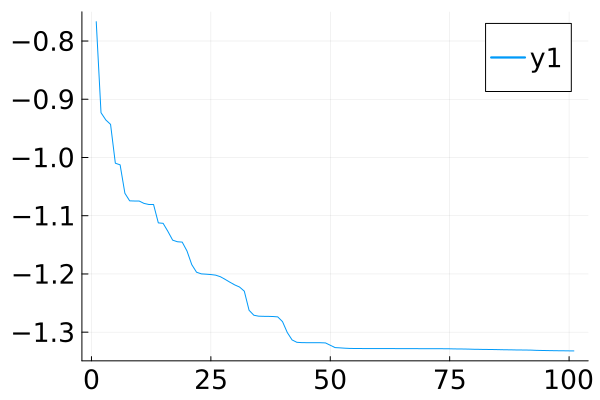

In [8]:
dnn_sol=DiffEqFlux.sciml_train(cost,append!(nn_initial_params,[0.0 0.0 0.0] ),BFGS(initial_stepnorm=0.005),cb=plot_callback, progress=true,maxiters=100);

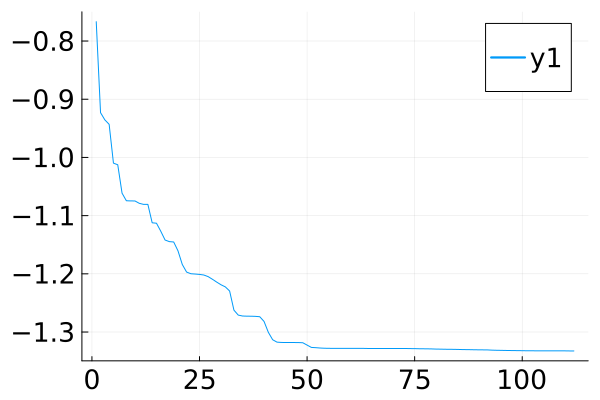

In [9]:
dnn_sol2=DiffEqFlux.sciml_train(cost,dnn_sol.minimizer, BFGS(initial_stepnorm=0.001),cb=plot_callback,maxiters=10);

Plotting the optimizer output control parameters as a function of time

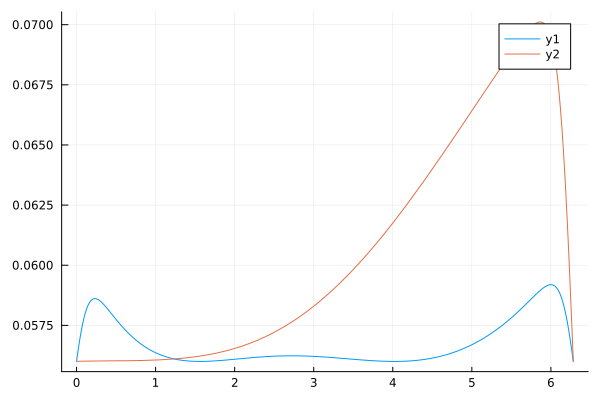

In [10]:
sol=dnn_sol.minimizer; 
J1(t) = J0 + Jmax*envelope(t)*sin(nn([t/T],sol)[1])^2 
J2(t) = J0 + Jmax*envelope(t)*sin(nn([t/T],sol)[2])^2 
Ω1(t) = Ωmax/2*envelope(t)*sin(nn([t/T],sol)[3]) 
Ω2(t) = 0
Ω3(t) = Ωmax/2*envelope(t)*sin(nn([t/T],sol)[4])
ϕ1(t) = nn([t/T],sol)[5]
ϕ2(t) = 0
ϕ3(t) = nn([t/T],sol)[6]
#Plots.plot([Ω1 Ω3 J1 J2],0,T);
Plots.plot([ J1 J2],0,T);


Plotting the pulse trace infidelity as a function of error ϵ with funciton infidelity. Here ϵ is the fractonal error in J1 and J2 simalteniously but they could be plotted seperatly with a small edit.

In [33]:
soll=nn_parameters_robustiToffoli#dnn_sol.minimizer;
function schrodinger_ϵ(u,p,t) #Here p is the error in J1 and J2
    nnoutput=nn([t/T],soll[1:end-3])
    @views J1 = J0 + Jmax*envelope(t)*sin(nnoutput[1])^2 
    @views J2 = J0 + Jmax*envelope(t)*sin(nnoutput[2])^2 
    @views Ω1 = Ωmax/2*envelope(t)*sin(nnoutput[3]) 
    @views Ω2 = 0
    @views Ω3 = Ωmax/2*envelope(t)*sin(nnoutput[4])
    @views ϕ1 = nnoutput[5]
    @views ϕ2 = 0
    @views ϕ3 = nnoutput[6]
    H = Ω1*(cos(ϕ1)*XII-sin(ϕ1)*YII)+Ω2*(cos(ϕ2)*IXI-sin(ϕ2)*IYI)+Ω3*(cos(ϕ3)*IIX-sin(ϕ3)*IIY);
    H31=(1+p)*J1/4*((XXI+YYI)cos((Ez1-Ez2)*t)+(XYI-YXI)sin((Ez1-Ez2)*t)+ZZI);
    H32=(1+p)*J2/4*((IXY-IYX)sin((Ez2-Ez3)*t)+(IXX+IYY)cos((Ez2-Ez3)*t)+IZZ);
    H2=Ω1*(cos((Ez1-Ez2)*t+ϕ1)*IXI-sin((Ez1-Ez2)*t+ϕ1)*IYI+cos((Ez1-Ez3)*t+ϕ1)*IIX-sin((Ez1-Ez3)*t+ϕ1)*IIY)+Ω2*(cos((Ez2-Ez3)*t+ϕ2)*IIX-sin((Ez2-Ez3)*t+ϕ2)*IIY+cos((Ez2-Ez1)*t+ϕ2)*XII-sin((Ez2-Ez1)*t+ϕ2)*YII)+Ω3*(cos((Ez3-Ez1)*t+ϕ3)*XII-sin((Ez3-Ez1)*t+ϕ3)*YII+cos((Ez3-Ez2)*t+ϕ3)*IXI-sin((Ez3-Ez2)*t+ϕ3)*IYI);   
    return -im*(H+H2+H31+H32)*u
end

U0 = III
tspan = (0.0,T)
prob = ODEProblem(schrodinger_ϵ, U0, tspan)

#function that returns the trace infidelity as a function of J1 and J2 quasistatic fluctuations 
function infidelity(ϵ) 
    sol = solve(prob, BS5(), p=ϵ, abstol=1e-8, reltol=1e-8)
    Ugate = last(sol)
    p1=0.00001*abs(soll[end-2])
    p2=0.00001*abs(soll[end-1])
    p3=0.00001*abs(soll[end])
    return 1.0-abs(tr((cos(p1)*III-im*sin(p1)*ZII)*(cos(p2)*III-im*sin(p2)*IZI)*(cos(p3)*III-im*sin(p3)*IZI)*Utarget'*Ugate)/8)^2
end 

infidelity (generic function with 1 method)

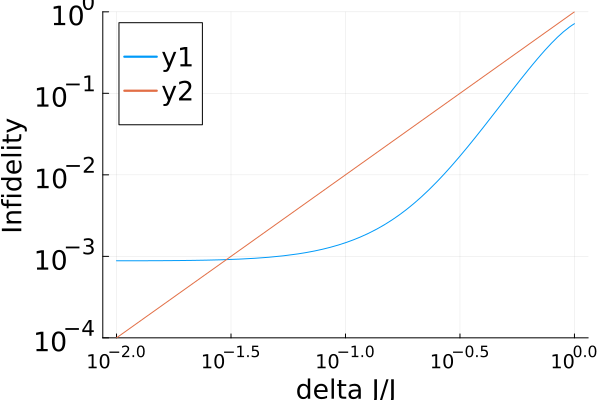

In [36]:
Plots.plot([infidelity x->x^2], 0.01, 1, yaxis=:log10,xaxis=:log10,ylims=(1e-4,1e-0),ylabel="Infidelity",xlabel="delta J/J",xguidefontsize=18,yguidefontsize=18,xtickfont=13, ytickfont=18, legendfont=18,legend=:topleft);

nn parameters results for each pulse described in Section III

In [32]:
nn_parameters_nonrobustiToffoli=[-0.8032180729, 2.674756259, 0.8331568747, -0.1258150106, -0.06445523392, 0.9754509224, -2.103600845, -1.241903786, 1.005067349, 0.9016526695, -0.3143578972, -1.122136035, -0.7609345737, -1.508650486, -1.155750788, 0.5046755756, -0.9483787843, 0.03153913753, -0.384209513, 0.9790816866, 0.9609217081, 0.6528494092, 0.2805462238, -0.2804718483, -1.025481394, -0.6250661461, 1.238615067, -1.742864315, 0.3384618879, -1.607733036, 0.6706175723, -0.8145870423, 0.2496993967, -0.8642193551, -0.3634958336, -0.56728354, 0.04150978261, -0.4297988305, 0.9892918206, 0.06060128759, -0.4420816181, 0.5057661651, -0.896814894, 0.4655262729, -0.2528647122, 1.302675152, 0.5726076836, -0.1120658855, 0.7594598296, 0.4551175528, -0.1396910919, -0.3097393705, -0.3655873795, -1.260775647, -0.2661855178, -0.4358359995, -0.2573244104, 0.03501642664, -0.4273861703, 0.8521574548, -0.7103878486, 0.8618450196, -0.2644050607, -0.0991456704, 0.03492555189, 0.155186841, 0.1200405236, -0.2648264289, 0.3492065788, 0.2024371129, 0.06143373734, -0.1051547081, -0.05409552404, -0.130731853, -0.3324127872, -0.07526704423, -0.3213008541, -0.1733636026, -0.01231969049, -0.6345708025, -0.2404436346, -0.271017119, 0.2052438681, 0.09913528229, -0.1558046589, 0.06783171609, -0.239896393, -0.05586024869, -0.1806048239, 0.2951501024, -0.1058179462, -0.3203410221, -0.4102594197, -0.3097609276, 0.1919963257, 0.2817783978, 0.05892712121, 0.1369339958, -0.4951910078, 0.4406942501, -0.2606744737, -0.01353747335, 0.07215629764, 0.8108841909, 0.8760857894, -0.6146255488, 0.7131348055, 0.6421597595, 0.276142837, 0.4010386204, 0.5824279086, 1.188000106, 0.7261928684, 1.073795467, 0.02677066903, -0.4322718064, 0.2382410536, 0.6053782235, 0.4936236571, 0.6695734979, -0.6006220051, -0.6270897969, 0.3187524252, 0.674218896, 0.309487227, 0.4588968619, -0.5934177651, -0.3140365025, -0.4100304109, -0.1318168342, -0.3404186457, 0.3150297051, 0.03440976692, 0.2794247861, 0.2203566851, 0.2459250417, 0.3682477895, -0.04687638099, 0.01797567558, 0.2596298265, 0.3747165206, 0.0263395656, 0.2252968928, 0.410839989, 0.05539955675, 0.3600038237, 0.2311232674, 0.01049014294, 0.26140289, -0.1080217843, 0.2803625123, 0.2016285757, -0.03519486707, 0.1660676072, -0.1454955741, 0.4500805556, 0.3428167521, 0.266522539, -0.2623524685, 0.1798948377, -0.08031625444, -0.3158087091, -0.1940637165, 0.1855092093, 0.03206593251, 0.3347834796, 0.1787869443, -0.2342992022, -0.124014625, -0.2301981634, 0.2038067508, -0.05348549265, 0.1324292678, -0.04233645219, -0.1974696522, -0.5355532011, 0.3077652118, -0.02906194947, 0.3958492416, 0.2399041697, 0.008089277256, -0.05626543499, 0.3108628902, 0.3955845516, -0.311744572, 0.1089579874, -0.3096835388, -0.1757093209, -0.05073891442, -0.01853400895, -0.07864243382, -0.1955186817, -0.1104519129, 0.2095750469, 0.1800937768, 0.06511407943, -0.07252794551, 0.07878754501, 0.1287773003, -0.02878655329, 0.04646896309, 0.02301842638, 0.1414157947, -0.07092927431, -0.02564586732, 0.005749022429, 0.01575777993, 0.003851888925, 0.06484109343, -0.04684599998, -0.2122928117, 0.2130633947, -0.03170175444, 0.07165815781, -0.001711490449, 0.2929837031, 0.02688774562, 0.2594792627, -0.1051104673, -0.1486606045, -0.2335646554, -0.2239872261, 0.02210740803, 0.2159897684, -0.1553872728, -0.05300785768, 0.1106670262, 0.1508202915, -0.2367746678, -0.07949161737, 0.3881295166, 0.2150679257, 0.4312760762, -0.324998669, 0.1947922713, 0.1061492814, 0.4693122341, 0.3230347258, -0.06537202606, 0.4528560609, 0.4811719958, 0.05544378199, -0.2867907915, -0.3040499525, -0.08659700724, -0.1516830319, -0.1809958524, 0.3089342807, -0.4055557401, -0.3672764118, 0.27672009, 0.2061708041, 0.3760546316, 0.3198991594, 0.0845514931, 0.01072005245, 0.07057624389, 0.1044327226, 0.04944266494, -0.5561718026, 0.2531235093, 0.04967981986, -0.4075372112, -0.3953099062, -0.8328929561, 0.1205897854, -0.7785475927, -0.5488572375, -0.5378000275, -0.06078161635, -0.2306740285, -0.8828988539, -0.7497651129, -0.8686469946, 0.02719240759, 0.1596697356, -0.3482633164, -0.2892608104, -0.4370261926, -0.7416251693, 0.5373999525, 0.05990811422, 0.08213095431, -0.6947980234, -0.650691492, -0.6090232652, 0.2300055339, -0.04206395288, -0.01742518884, -0.08697609115, 0.1516197265, -0.1767612463, 0.1506453097, 0.2158905462, -0.236687147, -0.4445496704, -0.6788464835, -0.1166946407, -0.1794430019, -0.04937204232, -0.2524368786, -0.3663258652, -0.2834702254, -0.7649488245, -0.2781344091, -0.4600048487, 0.2939988388, -0.1108757712, -0.3141291461, -0.3841528862, -0.1194029455, -0.2441334852, 0.1203761482, -0.009151506123, -0.3173674229, -0.3958801153, -0.07919033377, -0.2772179308, -0.01515448154, -0.2562406885, 0.1204804434, 0.07865926505, -0.1232815198, 0.1932249017, -0.07080677349, -0.2089605798, -0.1338786054, 0.1588333596, 0.1902501332, -0.1741200484, 0.2434671298, 0.2058024593, 0.3401515746, 0.4155726788, -0.04915205514, 0.3821366265, 0.4451672611, 0.6014727705, -0.2716262859, -0.2072495936, 0.005609605073, 0.4096663119, 0.04798357912, 0.02211456354, -0.4236257637, -0.08819113796, -0.02663747616, 0.4504069052, 0.3069619423, 0.13295175, -0.09181868696, 0.08924971755, 0.4490315188, -0.01357855071, -0.04369596153, -0.2426292987, -0.07415752476, -0.06231474125, 0.03883907406, 0.3862043808, 0.6990645149, 0.4274853232, -0.03965213015, 0.189910191, -0.2361045588, 0.5002667494, -0.2833160268, 1.039316659, 0.02925472034, 0.5348948953, -0.2827883991, -0.09501493645, 0.3539033864, -0.3854518941, 0.1144742303, 0.02642750502, -0.04339355942, 0.08231443268, 0.511740493, 0.1956890467, -0.03074396821, -0.2126821722, -0.1602443375, -0.3566333233, -0.4020151635, -0.1927764261, 0.265564732, 0.02167225889, -0.2411572569, 0.5204069612, 0.2513009289, -0.4242123054, -0.3969030059, -0.3541270261, 0.2359241681, 0.3450756382, 0.318372144, 0.04363648125, -0.08844172455, -0.5515352336, 0.4590416863, -0.1883969711, 0.2598898584, 0.03720269257, -0.0978482107, -0.03448651368, 0.214266299, -0.0793289195, 0.006538348752, 0.1059448476, -0.341523974, 0.3405725396, -0.1478038072, 0.1434971053, 0.3525533984, 0.2259028372, 0.1263923701, -0.08393684139, -0.003157491836, -0.08584555177, 0.2030642493, -0.2401982751, 0.08808223952, -0.5612153533, -0.4124993698, 0.06506314562, -0.2342084748, -0.4060286376, -0.4095932427, 0.04992853217, -0.3514121479, -0.6929981219, -0.6132367941, -0.3040469291, -0.3395946386, -0.03972968143, 0.2863876327, -0.498768052, -0.004182123699, -0.1026375013, 0.1637146392, 0.3531869647, 0.2669674591, -0.1358205636, -0.1590628981, -0.1955945582, 0.348769363, 0.09970586613, -0.07634146071, -0.2769144934, 0.07099436334, 0.130820222, -0.1997221709, -0.06023109834, 0.1484444285, -0.3221499801, -0.5643186326, -0.1383026989, 0.1497896669, -0.01074706666, -0.1609861443, -0.3114046192, -0.1303472576, -0.6407862113, -0.223221333, -0.3040015319, 0.2967891588, 0.07865243229, 0.06072123614, -0.08058442775, -0.08478150731, -0.2526546057, -0.06322274719, 0.1503206711, -0.2354689328, 0.109773123, -0.02494756206, 0.02031093962, 0.2857075971, -0.2304647667, 0.3455372422, -0.004808838024, 0.2718684225, -0.5840421439, -0.02149248178, -0.4206644636, -0.3160578058, -0.2873076005, -0.1631257805, 0.4484459863, -0.5511054425, -0.6920778487, -0.2592995304, -0.1248259431, -0.4640566535, -0.2711847439, -0.8607644261, -0.6660271962, -0.3490644464, 0.3515483054, -0.06238249493, -0.6082832113, -0.6858874304, -0.5781369185, 0.2903196247, 0.4553922649, -0.03858202223, -0.5763353932, -0.5417365894, -0.09318890179, -0.03449909797, 0.275232776, 0.09977606089, 0.2733221657, 0.04752387218, -0.07795732365, 0.1612929503, 0.1346807523, -0.275438612, -0.3713728176, -0.4855879792, 0.3468411739, -0.356824112, -0.1987822642, -0.4678427567, -0.07589646172, -0.2000112815, -0.3645446304, -0.2333993208, -0.2302824355, -0.1598368878, 0.006220876961, 0.2642222827, -0.3679065557, -0.001535709808, -0.5068766481, 0.4962636436, 0.09870979245, 0.1444648857, -0.3537911608, -0.4831560347, -0.2800100587, 0.4421534299, -0.1914327944, 0.1939690032, 0.01357248598, 0.1723098994, 0.2748120178, -0.01249415713, -0.2506587408, -0.1152500111, 0.2267022857, 0.4148210486, -0.1303110781, 0.07519725171, 0.1812217422, 0.01769739876, 0.253886521, 0.06998106486, 0.1561671969, 0.3111494858, 0.03057191281, 0.1810038954, -0.4111520294, -0.01368576469, -0.01980202627, 0.3165626924, -0.01908870336, -0.1698471305, 0.06401902603, 0.2326488478, 0.1649794332, -0.03807596199, -0.1884642323, 0.02168380048, 0.06934270992, -0.02228236674, -0.06507413116, -0.1679087806, -0.4092488413, 0.3179932133, -0.175204311, -0.3452874225, -0.3677284959, -0.03201113705, 0.4641139462, -0.4418294937, -0.1327479529, -0.5112193093, -0.1081157121, -0.4037748402, -0.5283267424, -0.2525896728, -0.3611521456, -0.2074419095, 0.08723791788, 
0.2576070887, -0.2208505414, -0.3950776991, -0.2921355031, -0.04046419407, 0.2885443982, 0.1484028009, -0.2794001193, -0.4595648707, -0.08079158545, 0.01953454034, 0.1352777507, 0.4702203088, 0.2896095172, -0.3090784237, -0.1530426485, 0.04743323932, -0.2668356517, -0.002085448695, 0.17192506, -0.02544031654, 0.08415504592, -0.2214402034, 0.1799432069, -0.03532295327, 0.04030938282, 0.1964815848, 0.08824613193, -0.05945493036, 0.1480958359, -0.3065046004, 0.1360360854, 0.3486757975, -0.07314781687, -0.2570765601, -0.2984766441, 0.2226221768, -0.164935069, 0.1138706608, -0.1867714169, 0.1142863791, -0.09636129512, -0.06144410023, -0.205667075, -0.2123491905, -0.2009937014, -0.05548936837, 0.1501445228, -0.1173906382, -0.1510999422, 0.194536241, -0.1497977612, -0.369487433, -0.2892223494, -0.2556092881, 0.1775863851, -0.2446883414, -0.1858042092, 0.02743756048, -0.4330623088, 0.1133354945, 0.07037670943, 0.3343337203, -0.1767177068, 0.1829168705, -0.164793014, -0.08248959363, -0.07717741814, 0.2674223268, 0.09682947582, -0.2294158091, -0.08130748315, -0.08198291583, -0.2141872651, -0.1695741016, -0.1073348677, 0.2861967647, 0.07393977315, 0.01073795317, -0.1154016773, -0.2821194279, -0.1494915548, 0.2050736636, 0.478009243, 0.1991367858, -0.4273883014, 0.4508395965, 0.1584608769, -0.03121557427, 0.01804066094, 0.391947304, 0.4459508744, 0.430490557, 0.3806381317, 0.2112716015, -0.342778896, -0.000187054278, 0.2299296727, 0.1977679064, 0.1854474786, -0.2267379376, 0.04290764283, 0.1365070844, 0.2451050138, 0.01598216849, -0.06225608042, -0.3129793199, 0.2259758461, -0.142697089, 0.02573029546, 0.05587711968, -0.1890938734, 0.147000309, 0.05967227531, -0.0003328484144, 0.3204757434, 0.5309660464, -0.433246186, 0.2538823675, -0.05940633093, 0.2824810301, 0.1503846373, 0.1341013451, 0.6080453738, 0.2583663006, 0.4979655138, 0.01956178474, -0.2495120718, 0.1445885263, 0.340160938, 0.2195849268, 0.32192795, 0.04230626563, 0.01500137719, -0.196923929, 0.3990414491, 0.07159678194, 0.07708482206, 0.001145507216, -0.1673606562, -0.3284988485, -0.4695247785, 0.2214222086, 0.3614018648, -0.3847320242, 0.130212938, 0.4187330966, 0.04841936712, -0.07972123385, -0.1853852088, 0.3635655462, 0.1222058623, 0.3555264628, 0.1144213659, 0.4040597893, -0.259608745, 0.4051389987, 0.2307566136, 0.3911402349, 0.01431976235, -0.04173799487, 0.6582525797, 0.3843828998, 0.4634964387, -0.500571895, -0.02397517155, -0.5317301395, 0.492869957, 0.5432536094, 0.6491600948, 0.1518575952, 0.03133351121, 0.1996407553, 0.02051980188, 0.2222052116, 0.3089868349, -0.1816883437, -0.04643672256, 0.07068035363, 0.2678009291, 0.09308968914, -0.08724676985, 0.07404076672, 0.1854711233, 0.2602361872, 0.307604703, -0.1291264458, -0.005281707301, -0.1252436409, 0.3060723915, -0.05739892396, 0.2239157137, 0.2965416866, 0.2140443716, -0.05893540927, 0.324780922, -0.07653731569, 0.0531997127, -0.2656707093, 0.03049090992, 0.1291195103, 0.1781603022, 0.1782818556, -0.2193545613, -0.006946282995, -0.144874965, -0.08930249007, 0.1379104708, -0.08049917985, -0.03928602637, -0.1555584919, -0.2746736272, -0.4463207896, -0.3282414041, 0.2142459066, 0.3032071879, -0.001732050831, -0.3458485996, 0.2582955496, -0.550627319, 0.2725657349, -0.03765843161, -0.1003193096, 0.1162862227, 0.1473648554, -0.1670628859, 0.155724783, 0.080785448, -0.06659738971, 0.2486662088, 0.001905957529, 0.3099174629, -0.1909376222, 0.119785989, 0.2503053595, 0.1066956751, -0.4239057633, -0.06614967445, 0.1297179247, 0.05069326085, 0.3095558669, 0.3232120386, 0.03328463133, -0.1201755236, -0.5616302474, -0.208363715, -0.1680056869, -0.1543619346, -0.04737912966, -0.5418970098, -0.1368575178, -1.010398127, -0.1127922344, -0.1972450958, 0.4093954914, -0.06507905338, -0.3018447279, 0.1998927895, 0.08240650233, -0.2598893099, 0.1274733294, 0.3333022022, -0.06624184451, -0.1579027989, -0.06390079699, -0.000665961972, 0.3728703889, 0.2905486461, -0.04484382736, -0.2113531774, 0.3530970721, 0.104972907, 0.1621376057, -0.009885425817, 0.1458104774, 0.1460524708, -0.4601301509, -0.0101060002, -0.3754741587, -0.2998187202, -0.08539198474, -0.1030215773, 0.06980681486, -0.2449819484, 0.08723515583, -0.2902977026, 0.2432152716, 0.01956175916, 0.05853167211, -0.3279685555, -0.2255101933, -0.3860337618, 0.05645935113, 0.116040524, -0.2429700461, 0.1493700165, -0.3832635809, 0.1045645798, 0.04842280069, 0.2429944115, -0.1646852781, -0.1339548099, -0.2183168405, 0.04353912828, 0.00824435507, 0.03377062964, 0.07602797342, 0.3491186171, 0.4955983515, -0.2672790478, 0.3013269525, 0.297596784, 0.4528662214, -0.05753307701, 0.04317580967, 0.6406907197, 0.6476921641, 0.2145155682, -0.26842147, -0.3244767395, -0.1919349302, -0.02437287033, 0.2475208299, 0.1494278344, -0.202510691, -0.2082817536, 0.02642714355, 0.4195752568, 0.1526704116, 0.3202965349, -0.4223426963, -0.1831536192, -0.1492454421, 0.2238050291, 0.01381697381, -0.4152946755, 0.3733341733, 0.08042417606, -0.2419961968, -0.4582810056, -0.5570256656, 0.5412680541, -0.6668071259, -0.551937464, -0.4330508349, -0.3113039761, -0.1746700122, -1.019437484, -0.7665542606, -0.5580645061, -0.08713082605, 0.433008102, -0.3274585817, -0.03772076323, -0.2473019262, -0.4251747937, 0.5842323689, 0.03035273993, 0.1177762138, -0.6134129409, -0.1425598501, 0.0952933677, -0.02396096732, 0.2145122945, -0.06878478566, -0.3418044508, 0.3179102, 0.02936911553, -0.1442281137, -0.1327396037, 0.03408431633, -0.1479993146, -0.09401655006, -0.1391812577, 0.2742528064, 0.4175837135, 0.3276988271, 0.2695732911, 0.007217103518, -0.161275422, 0.2727156648, 0.4023778201, 0.1485969173, 0.1787995085, -0.1086936169, 0.4657142443, 0.4334911696, 0.2000127013, -0.3752000211, 0.1552376622, -0.1035637847, 0.09338074113, 0.04293054517, 0.1174479698, 0.04485332775, 0.2585622286, 0.3203966836, 0.2462015658, -0.02134752226, -0.4044706446, 0.04364735342, -0.09311534687, -0.2204921735, -0.2749330739, -0.6056438895, 0.4190296534, -0.6160161215, -0.5197709038, -0.5787864244, -0.4694155661, -0.04866903394, -0.6409829947, -0.630118516, -0.6050552016, -0.1701482788, 0.04138418982, -0.05713738968, -0.573136804, -0.5293286393, -0.4150099508, 0.1531870917, 0.3941214493, -0.04157328401, -0.2309329303, -0.1948731144, -0.07438730339, 0.5256731842, -0.001278218475, 0.340029533, -0.133057155, 0.09321216019, 0.04849299092, -0.1151083915, -0.2564715344, 0.05681813861, 0.2715495432, 0.002447253039, 0.1211752403, 0.4319673881, 0.04605098028, -0.01652766203, -0.1391849166, -0.2176730399, 0.4410667171, 0.4307758818, 0.3810741258, -0.06283800384, -0.1789531112, -0.1242835414, -0.02082930773, 0.4015081942, 0.05743049556, -0.1023283791, -0.2465662745, -0.1140469026, 0.3844005839, -0.03815872727, 0.1446443152, -0.2543641296, -0.2931781605, 0.1015630938, -0.02547553151, 0.2659804802, -0.158280047, 0.08620108232, 0.3850651313, 0.02620515386, -0.06301812148, -0.5144367597, -0.2211163093, -0.2743519362, 0.005853002468, -0.04619326365, -0.2874984661, -0.249735416, -0.4824194457, -0.1918498188, -0.3345014659, 0.04671459294, 0.2783553484, 0.1906037382, 0.1136073261, -0.3469364861, -0.05297946168, 0.009542640619, -0.1016890171, -0.006160001651, 0.0630819472, -0.03281145222, -0.3314733624, 0.4642707534, 0.2656432412, 0.4044707289, 0.3904765594, -0.2021433772, -0.5702543764, 0.1998796891, -0.6912987578, -0.08181872207, 0.244991955, 0.1039881276, 0.5601251997, -0.7043796757, -0.1900788128, -0.327896197, 0.3123320368, -0.2294105907, 0.6655268441, -0.8581139382, -0.1506917676, -0.5453508213, -0.07556783886, 0.4273709299, -0.7123221646, -0.4962245121, -0.611126363, 0.5307631062, 0.1109281443, 0.7176630754, -0.4463312692, -0.4808472873, -0.450345585, -0.1077588228, -0.4798531878, 0.4014724739, -0.1267985272, -0.3656014126, 0.1040047388, -0.05376583941, 0.04061595006, 0.01189049615, -0.6888212449, -0.5930145389, 0.07542003932, 0.1463381864, 0.08029703348, -0.04520611788, -0.1738779101, 0.4553033196, -0.2702237993, -0.2824383281, 0.1724391516, 0.6092692995, -0.6882052761, -0.6409007983, -0.4333991041, 0.6021762037, -0.1138888866, -0.02142273236, -0.08547474906, -0.2363592942, -0.03655397624, 0.1880580884, 0.4854237023, 0.3730388399, 0.2530099938, 0.3135796122, 0.3079928657, -0.03532496136, -0.06286121972, -0.1967623725, 0.1354797552, -0.252471289, -0.08905244139, -0.5571343042, 0.09830713415, -0.2622031269, 0.1053087747, 
0.4330835902, 0.05616115656, 0.1805442463, -0.08602913058, -0.2491118879, -0.05342728218, 0.1813590708, 0.06916515435, -0.02565241896, -0.2517332294, 0.4213295727, 0.2998584424, -0.2455777451, -0.08055148963, 0.0153707196, -0.1660364338, -0.1166194707, -0.1781143692, 0.2327113555, 0.329837362, 0.227266644, 0.1589362127, 0.1446466935, -0.1865587161, -0.05273989233, -0.07979619892, -0.3988125796, -0.241370593, -0.1807769473, -0.2855087486, 0.1497963707, -0.02198800427, 0.124004159, -0.1777331306, -0.1213831285, 0.2370996908, 0.2022005818, -0.04234957468, -0.3060694945, -0.4180231015, 0.3923722798, 0.06578317442, 0.4174257302, 0.06447669593, 0.08905108228, -0.1393287385, 0.2629713507, 0.1710494476, -0.01184630766, 0.169311134, -0.06423055683, -0.06582495312, -0.4485626558, -0.113172046, 0.05393674153, 0.3883239875, -0.08604688337, -0.4366474677, 0.02750868916, -0.06222897066, 0.7523491751, 0.1195940584, 0.3373890665, -0.1319518762, 0.03943655268, -0.6301640646, -0.3080529901, -0.1205303381, 0.6789978496, 0.1895134009, -0.2629358681, -0.5470575311, 0.1412526578, 1.429037515, 0.1766622018, -0.2317698181, 0.3770103265, -0.2169266987, 0.32065227, 0.2099644414, 0.01389450693, -0.04007677472, 0.1718977858, -0.849231926, -0.1028312794, 0.003519518377, 0.2046549255, -0.002013873134, 0.2974098951, 0.1002355012, 0.2051472611, 0.07341796159, -0.4221671561, 0.3838273706, -0.6887894141, -0.06629611029, -0.2569930859, 0.3725394951, -0.1107744526, -0.165949128, -0.01244744565, -0.2737338813, -0.2601552626, 0.2379359162, -0.08566460358, -0.6822264643, -0.1178597867, 0.4408466638, 0.004566500387, 0.2259284984, -0.04343744944, -0.4102464042, -0.09164007785, 0.0709043812, -0.05146340485, 0.3400886242, -0.189676195, -0.4089717437, -0.07660156915, -0.4723022985, 0.1071778861, -0.2146487267, -0.2038898816, 0.3286129202, 0.3261227738, -0.05156816895, -0.3808057166, -0.1561627103, 0.1257775169, -0.005081022531, -0.5033605347, 0.1414286433, 0.08569066017, -0.4196065158, 0.07945976649, 0.1800337648, 0.2689981542, 0.3346502589, -0.3313690669, 0.00707025818, 0.26597699, -0.007382474164, -0.3669645928, -0.1010812302, -0.09404903125, -0.2925662826, -0.1481094646, -0.09504724529, -0.1795746299, -0.3247128949, -0.1113551875, -0.09578713604, 0.03392084955, -0.08492711787, -0.08343189632, -0.1685665906, 0.424673321, 0.05684864843, 0.018783537, 0.3261650669, -0.2307493498, -0.4327830229, -0.3491559006, 0.3232458528, 0.6298289093, -0.2890076259, -0.2530845978, 0.00484486918, 0.2063991263, 0.6486772363, -0.2256047386, -0.05898538843, 0.07476001165, -0.01985143996, 0.097785929, 0.2120157217, -0.3852872399, -0.1438861819, -0.1683730526, -0.3600252855, 0.0139262078, 0.2412364498, -0.2751630657, 0.7389218488, -1.221553635, 0.169500294, -0.2265850732, -1.093822576, 0.0192826991, 0.128025706, 0.9967016467, 0.6248816549, -0.2942346374, -0.4395070082, 0.242493389, -0.3553203689, 0.311090881, -0.08774408652, 0.2711112119, -0.4212387063, -0.1640784869, -0.04241135007, -0.07790870141, -0.6449973112, 0.1339130733, 0.3426333477, 0.2167470245, 1.101040908, -0.03644005902, 0.342593504, -0.02151896982, -0.3002152498, 0.0338384905, -0.2976017837, -0.5291440244, 0.1658617113, -0.9651433212, -0.4108368382, -0.0005771301348, -1.428380713, -0.5516573039, -0.3567648539, 0.6010904856, 0.5330138897, -0.4843008525, -0.8721689947, -0.2043298431, -0.1196480569, -0.2092477028, -0.4474861452, -0.4371070357, -0.2780209185, 0.3588789718, 0.3647783322, 0.5533212405, -0.8353444254, 0.4011139795, 0.8629161744, -0.1610444708, 0.794547781, -0.2815000137, -0.04073010266, -0.3712620225, -0.3819090598, 0.3319925654, 0.3804591389, -0.1027157951, 0.2688799585, -0.09247989982, 0.6250164623, -0.1066834396, -0.01411873379, -0.5833732431, 0.1241848771, -0.06771722693, 0.02639484943, 0.06842005325, 0.3895867989, 0.2354443703, -0.08925152287, -0.4044086386, -0.2090196848, 0.01968273767, 0.06812976551, 0.2113380791, -0.851083083, 0.2392516794, 0.4642902121, -0.5421722861, 0.755511645, 0.4368415335, -0.1969070901, -0.2721648672, -0.121748968, 0.01333757119, 0.6316942957, -0.1257956875, -0.1132143651, 0.03710614411, 0.3902340089, 0.120337241, -0.5801633225, -0.117594717, -0.2513767923, 0.3119683716, -0.2971677599, 0.2958681101, 0.0611830187, 0.3004476094, -1.111852066, 0.09114157971, -0.1283251543, 0.1563466153, -0.3560731761, -0.4998968082, 0.2211013494, 0.361111564, 1.853929764, -0.2734732936, -0.6229476782, 0.6474864887, 0.6688518659, -0.0490535433, -0.09798791377, -0.3735228144, -0.1850285646, -0.08796437472, -0.9677365927, 0.01304428955, 0.05788976592, -0.03300376026, 0.5082985116, -0.4404500689, -0.04152418509, 0.4534072668, -0.464057931, -0.1032799753, -0.8372542243, 0.8073662107, 0.3849003862, -0.2920048513, -1.147785459, 0.1282076743, -0.2546231882, 0.1033998113, -0.01294548609, 0.09655583802, 0.1105446971, -0.01853928469, 0.5217993203, 0.07889584193, -0.9301520606, 0.5200760345, 0.1661059997, 0.4574803998, 0.5713131872, 0.02870189096, -0.08390082234, -0.006693020574, -0.401380985, 0.06681813068, -0.4060362902, 0.06727759404, 0.1350189602, 0.04752134862, 0.1780976377, -0.01932274285, -0.1714976338, 0.07144861903, -0.3184888209, 0.301796653, 0.2258564485, -0.01995125193, -1.062906219, 0.03188883523, 0.1353090929, -0.4627755119, -0.2075793356, -0.3212984403, 0.1753134139, -0.3036881397, 1.379936385, -0.3547371717, -0.6890886759, 0.587716958, 0.09591813269, 0.09103968945, 0.05521992105, 0.1364157766, -0.05133968218, -0.3287897297, -0.3710091081, -0.02465435697, 0.108164829, -0.5699742116, 0.5765024795, -0.433219829, 0.4574897387, 0.2248859035, -1.189665465, -0.108962155, -0.2937182557, 0.5682114024, 0.3315974213, -0.1601398247, -0.1133681767, 0.2065441212, 0.00438569808, 0.1691390527, 0.1538138972, 0.2191323133, -0.6274069912, -0.7405972508, -0.1912747787, -0.1405484175, -0.184788648, 0.1077852332, 0.2193537782, -0.1391633952, 0.1509326088, 0.3716121427, 0.2870520085, 0.1494259266, 0.4473626551, -0.2076166503, -0.07685289559, 0.256558616, 0.054484755, -0.06341943163, -0.1552810788, -0.04492139065, -0.224124102, 0.6157662386, -0.05520736858, 0.4048972607, -0.09866412328, -0.217545867, -0.9248415663, 0.1978014831, -0.2561750751, 0.4650141309, 0.2104021035, -0.1454023273, -0.5294785276, 0.03573063065, 0.5752436457, -0.1820844634, -0.1819107965, 0.6374232593, -0.1965692198, 0.2575737348, 0.2102905417, 0.07679970618, 0.03177955203, -0.3295512796, -0.6392366572, 0.1875286658, 0.4726606941, -0.8692582165, 2.924017999, -0.0759034149, 0.2666738502, 0.1290338842, -3.388809418, -0.5616512471, -0.1410157668, 0.8065548929, 0.7821785909, 0.2419725053, -0.5251999512, -0.1660042493, -0.1244471281, -0.08731046909, 0.08333869684, 0.3284411053, -1.098129219, -0.7339154148, -0.03519164877, 3.828348679, -0.3947758415, -0.1645924057, -0.2282196245, 0.1971646462, 0.440104337, 0.02519489381, 0.2413605881, -0.3206885537, 0.4462248615, -0.1323930269, -0.01683821702, -0.2555082653, 0.1521344391, -0.2136823049, -1.044578424, -0.02686911186, -0.2847943616, -0.004555789202, 0.03386359866, -0.09909136678, 0.4106021515, -0.1540245366, -1.478230605, 0.1996370485, 0.03563366429, -0.09516685838, 0.2054907625, -0.006623882244, -0.1958541645, -0.2430782975, 1.983979222, -0.2126761054, -1.329011582, 0.4173542774, -0.05579166863, -0.1386800991, 0.3357613812, -0.2924267663, 0.0281310181, -0.007528733547, -1.001540535, 0.1299870713, 0.2084623792, 0.0483173106, -0.3530354854, -1.098279506, 0.1220117601, 0.07524967515, -0.9397243414, -0.1656222992, -0.8163638276, 1.33915271, 0.07570498232, -0.3738238364, -1.142365335, -0.1186632919, 0.3324802802, 0.04255568908, -0.235829321, 0.06904721425, -1.451224827, -0.3490166396, -0.09016030404, 0.5663330599, -0.7291012102, 0.108908463, -0.1790639812, 0.4275473424, 1.210002596, 0.01446124591, 0.07126471144, -0.05400836028, 0.1790704911, -0.004699786834, -0.3924639378, 0.3772471806, -0.2840751437, 0.3110891761, -0.200989572, -0.3063796317, 0.6681869629, 0.3316835872, 0.2231756851, -0.1005573751, -0.5292529036, -0.06052330012, -0.1728803627, -0.3049258287, 0.2768544445, 0.2030071579, -0.3810224123, -0.5209547644, 0.03174722511, 0.695214814, 0.4079611315, -0.5512657873, -0.07167350749, 0.3169808251, 0.3498551944, 0.08539035304, -0.2747341268, -0.5988069679, -0.2514449293, -0.4398659962, -0.4885004016, -0.1097169427, 0.2527684153, 0.396307958, 0.04243894167, 0.7263795713, -0.2694677333, -0.1281170928, 0.6644532199, 0.04353672382, 0.2994941134, -0.501474612, -0.5778059834, 0.2302386859, 0.670378161, -0.2278072637, 0.1670168835, 0.03544807427, -0.1525185484, -0.1317415319, 0.137963449, 0.3133102794, -0.1035576823, 0.0935803427, 0.3461075929, 0.04314067095, -0.01820769873, 0.1217040016, -0.6310021547, -0.3542991232, -0.4297199309, 0.3299302369, -0.1029277393, 0.3134050599, 0.1274791951, -0.02686652679, 0.05149328435, -0.2451965197, 0.2805543057, 0.09505805224, -0.2818584056, -0.3965922602, 
-0.177326488, -0.02398364931, 0.4861274906, -0.2307935905, -0.3308676045, 0.1879583129, -0.1320747631, -0.09310517503, 0.4008084041, 0.4699800454, -0.3009070678, -0.5625984381, -0.1948799477, -0.142921486, 0.05499080662, 0.020849988, -0.1992095414, -0.1534604892, -0.1089538542, 0.3831213552, 0.1719821128, 0.06338082083, 0.07339181606, -0.1789508813, -0.1097598238, 0.1967302444, 0.1514960326, -0.274420977, -0.952852114, 0.1203869954, -0.0970131584, 0.7706446099, -0.2681445195, 0.2875158557, 0.3757617072, 0.4161632837, -0.4454350989, -0.01957364218, -0.2390058464, 0.4634347467, 0.4110343415, -0.3214707868, 0.2025412939, 0.4940950326, 1.707672377, -0.06715937777, -0.6380967781, 0.7843075973, 0.167292365, 0.07865721338, -0.09301591023, -0.2467191934, 0.0759309331, -0.08132644873, -1.160126754, 0.1884844404, -0.2324922073, -0.02185513565, 0.5026657548, -0.1143958171, -0.6954355986, 0.07881294213, -0.4723723009, -0.04960952401, -0.1132920876, 0.3461986565, 0.4473187772, 0.01450043836, -0.5826666299, 0.02183439353, -0.1848655314, 0.09849612777, -0.1102411309, -0.06022735584, -0.408641788, -0.2054154928, 1.333013014, -0.2106662185, -0.7193851519, 0.3655531264, 0.2935405195, 0.6434723513, 0.37364217, 0.1395760047, 0.05261152228, 0.2101609325, -1.085269184, 0.08734812853, 0.06109157204, 0.1003159923, 0.4007996168, 0.1685707457, -0.3366116441, -0.03017059625, 0.193409621, 0.1099568299, -0.5552454237, 0.2158727062, 0.2607489678, -0.07419638091, -1.393711657, -0.04807680286, 0.01094603594, -0.250136869, 0.09889397166, -0.2036063955, -0.2196974202, 0.1118139419, 1.656041637, -0.3604655374, -0.2762528353, 0.3781931118, 0.3327723781, 0.3163279884, -0.04056903334, -0.1787734912, 0.1003152486, 0.05094463203, -0.4741739359, -0.04493721252, 0.2754870862, 0.1856542191, 0.1469813665, 0.1194676789, 0.4464198377, -0.2094688645, -0.04293583173, -0.3389818989, -0.07053156633, -0.03611614803, -0.0149333716, 0.05220935868, 0.6004787097, 0.5290008732, -0.03835984011, 0.07279629093, 0.08155269329, 0.3827695789, -0.02186963831, -0.2426430106, -1.281623915, 0.1655067696, 0.5678652444, -0.4212461044, 0.2424977669, 0.06315291515, 0.03658317755, -0.2502811074, -0.2393713121, 0.3114673416, 0.3874522562, 0.1835673505, -0.1801903506, 0.5144435543, -0.2499470141, 0.8169841866, -0.07821291917, -0.3398904601, 0.6736852326, -0.181097549, 0.1906762414, -0.3601501771, -0.1443307442, 0.08660925668, 0.4481414186, -0.1293930518, 0.3674672164, 0.06480504724, -0.3921946478, -0.04723648913, 0.1590566646, 0.5618236321, -0.1887432112, 0.2026504531, 0.4631815761, -0.1940233825, -0.2203847195, 0.1642476822, -0.3530242788, -0.2363658696, -0.04726393913, 0.1689807836, 0.1060500314, 0.2101334098, 0.2184585475, -0.4297518773, 0.005904598091, -0.2047937309, 0.6197599798, 0.1173574057, -0.1803659286, -0.3508622023, 0.1035816305, 0.2654385142, 0.4780015907, -0.08569161129, -0.04144089522, 0.08100825097, -0.4279992646, -0.46257114, 0.01138439866, 0.1996087403, -0.1708410099, -0.9758820638, -0.5200654513, 0.0952915905, -0.06214716321, -0.270114257, -0.4990920901, -0.2067687816, 0.1837712144, 0.4096593835, 0.2358467582, 0.129377138, 0.3614499671, -0.06702219862, -0.2859669226, 0.002872861152, 0.2642922449, -0.1004508742, -0.51404707, 0.3813803125, -0.4671625992, 0.00156423398, -0.1591052117, 0.8039021714, 0.06787405353, -0.293367704, -1.582923835, 0.108454702, -0.01312124105, 0.4527641122, -0.1443111739, 0.05297790903, -0.6839366261, -0.1040692873, 1.46902819, 0.165216009, -0.9928184244, 0.03690418724, 0.1883537972, 0.3913483591, 0.1676510799, 0.1120022124, 0.4801158859, 0.1314000481, -0.2673406617, -0.2939051613, -0.1369825919, -0.1479674541, -0.01264754446, -0.3830641475, -0.2616689151, 0.1724957544, -0.110253388, 0.409843138, -0.1137603885, 0.6580064639, 0.3627718021, -0.2459309167, -1.252732362, -0.001990377871, 0.001981904485, 0.1156252244, 0.2232892382, -0.2397165666, -0.3522492084, -0.08859855769, 0.9268773808, -0.2608932239, -0.3940892614, 0.5881460065, 0.333833252, 0.301072582, -0.09823762999, 0.1753381548, 0.4480172478, -0.1831812257, -0.5520954518, -0.303018081, 0.02805925882, 0.0412465829, -0.0421362749, -0.1742972561, -0.6123059717, -0.1806296128, -0.03419601893, 0.6239814207, -0.3880326406, 0.6219772805, -0.03466829127, 0.1196576774, -0.587331692, 0.3399648075, -0.3043985511, 0.5811645781, -0.1602719434, -0.254245346, -0.3537106753, 0.2069711819, 1.116431158, 0.02278598625, -0.2933497049, 0.6245795023, -0.2708799601, -0.2728065997, -0.009260386992, 0.0761912297, 0.1977145482, -0.01430962286, -0.7425160147, -0.1972364791, 0.2115782779, 0.27104749, -0.2548291791, 0.6912225718, -0.1824998829, -0.006916439985, 0.7814338002, 0.2271299064, 0.6629076099, -0.768308833, -0.1591581492, 0.2331729032, 0.6690494405, 0.09197861829, 0.3805757061, -0.2871762299, -0.09868621442, -0.4878967515, -0.1407433244, 0.3209783026, -0.07683432043, 0.3155631642, 0.586360965, -0.3984212222, 0.08836691178, -0.2085806846, -0.6413119648, -0.04337368766, -0.1428303331, 0.07841517416, -0.2895113506, -0.1727092224, -0.1870421784, 0.2845578833, -0.364048272, 0.3836237659, -0.3422347696, -0.1746980535, 0.8390685578, 0.2823988324, -0.09271250736, -0.523356624, -0.5825070515, 0.3082908324, 0.2974520844, -0.259688146, 0.4540804655, -0.03653893943, -0.1896578289, -0.2730854921, 0.5512854916, 0.6985526922, 0.3805186111, 0.2931519438, -0.1200265818, 0.1984474448, 0.3230952117, 0.03693609131, -0.5023414193, -0.1454595245, -0.1060432147, -0.1770003432, -0.3383469717, 0.4114724344, 0.2194912, -0.2295948773, 0.02395369073, -0.1790408658, 0.471073013, 0.1972371348, -0.3537145421, -0.3989710027, -0.3509807759, 0.2513708011, 0.3388071591, -0.498568441, -0.1397743113, 0.4858645883, -0.2955135797, -0.1606281288, 0.3623106344, 0.4651364484, -0.3039739377, -1.096033446, -0.5425886089, 0.4451012858, -0.2828057078, -0.5008016213, -0.5995661507, -0.4252317831, 0.1258511318, 0.5682191876, 0.2967784498, 0.3612365562, 0.2983548003, -0.2124373256, -0.2392718453, -0.08219687844, -0.2095885746, 0.6761816792, -0.9352515623, -0.0468412776, 0.2585789519, -0.3062524495, 0.8286135742, -0.01922975818, -0.4638501135, -0.05332160229, 0.2619967814, 0.0428089423, 0.08586159199, -0.07207809791, 1.720066351, -2.604259317, -0.1716366616, 0.7759403479, 0.2080459321, -0.8575137917, 0.8161252988, 0.1870441611, 1.383967496, -1.264837734, -0.3202817074, -0.5728257132, -0.05844969734, 0.1295160936, -0.8503380618, 2.861324949, 0.7523814437, -0.7220268832, -0.6792990901, -0.1240984371, 0.252548681, 0.1386784233, -0.1638175868, -0.2061884382, -0.642737914, -2.59703566, -0.6598814938, -1.319270139, 0.2497527207, -0.01358735581, -1.025806023, 0.2402176109, -1.509944933, -0.2074422883, 0.7263268488, -1.39381752, 0.6540641302, 0.2670776735, 0.2119018065, -0.9766062083, 1.285193926, 0.8860695468, 0.6198407294, 0.01506250608, 0.9395900265, 2.070700113, 1.613801814, 0.9685935076, 0.3276307503, -0.2956478925, 0.7106399275, -0.5362800743, 0.3264065503, 0.8541191439, -0.3375133521, -0.9984678217, 0.1261627829, 0.2111285075, 0.09859333702, -0.8707125574, -0.3763773526, 0.1415485608, -1.019354098, 0.9100443197, -0.9863873765, 2.273648363, 1.092979653, -0.1385679671, -0.3579082632, 0.3503204006, 0.3149510281, 0.4740181344, -0.4665626513, -0.1854544645, 0.0276833412, 0.5661644153, -0.3187567987, 0.001262001131, 0.6229432496, 0.006267000151, -0.7727459056, 0.9937177807, -0.01474005869, 0.5062083224, -0.9350674106, -0.1404833014, -0.4254719585, -0.2555768168, -0.1920946936, -0.3113679577, -0.4788739156, -0.6292880854, 0.3297140167, 0.5580202479, -0.7379216189, 0.3087224538, 0.07920379215, 0.1688010975, 0.7894549893, 2.421036173, 1.404003203, -1.178746493, -0.5081451852, 1.605488981, -0.007919481379, -0.1342804745, 0.3624013984, -1.183546758, 0.4805883824, -1.239455254, -0.7208560939, 1.214659776, -0.3688065982, 0.1135695712, 3.145189573, 2.710397688, -0.04367915331, 0.2071537834, -0.02363201426, -2.037456418, 5.050735742, 1.378492246, 0.1287614119, -0.8614922269, 0.6962575395, -0.897831516, -3.109358705, -0.02287654286, -0.1740582468, 1.24397799, 0.2482400737, -0.897795999, -2.41396506, 0.5244526878, -1.371317821, -1.487597878, -0.6118058197, 0.3591371567, -0.1485466068, 3.266792208, 1.148415293, 0.302895522, 0.3889706791, 1.196972893, -1.315446885, -0.02325228241, 0.9933585368, 
-1.025708072, 0.8308548344, -0.9740334924, 1.106833834, -0.1922815638, 0.04719974658, -0.7140530057, 0.4057240475, 0.2650215412, -0.7666301453, -0.1365596505, 0.3831243011, 0.1322485926, -0.3783567556, 0.291648017, -0.538876353, 0.1114852541, -0.4878568844, -0.423780254, 0.05745902655, 0.2213216637, -0.5982984793, 0.3692231792, 0.530008102, 0.9977796959, -2.045727652, -1.320225884, 0.08764559463, 0.2298913111, -0.5537859303, -0.2922959021, 0.1121283635, 0.3887301771, -1.172893142, -0.0005157862283, 0.03632684894, 0.03632684894];

nn_parameters_OuterX=[0.2162134286, -0.04905117005, 0.1409475588, -0.1369387714, -0.0252650865, 0.05176048972, -0.2615521776, -0.2054443419, -0.4213428378, 0.7135693249, -0.2264683506, -0.1256408719, -0.3033721991, 0.511191402, 0.6087044081, -0.2316235056, -0.5782161755, -0.2536392582, -0.354452461, 0.4701191685, 0.5638813598, 0.2768196431, -0.5476734811, -0.8391925153, -0.4108170125, 0.5115285401, -0.5624479841, 0.647045748, -0.3194172499, -0.6429016763, -0.09978192043, 0.01198582291, -0.02100720513, -0.09766476734, -0.03539199296, -0.07839444804, 0.1978989727, -0.1185105965, 0.07024437151, 0.1473346995, -0.1205164386, -0.4002462579, -0.0121940337, -0.2787879452, -0.04808873232, -0.2980275745, -0.3881880939, -0.2080692667, 0.2797135905, 0.07495996216, -0.1535097492, -0.002214196069, 0.07124413493, 0.03278479769, 0.07601832376, 0.1820941131, -0.0294225032, -0.1046252208, 0.1613067181, 0.04101202204, 0.1093858971, 0.0983565419, -0.1061783769, -0.1194547872, 0.2423609894, -0.1601008121, 0.2462284549, 0.2783442425, 0.09445574834, 0.1923198018, 0.01308058818, -0.1653024269, -0.08864795679, 0.003721822445, 0.2255761371, 0.2077130675, 0.07730284542, -0.2705842049, 0.0462100611, 0.2185531159, -0.06156870831, -0.2356924344, 0.2406234706, 8.38e-5, 0.06630302041, 0.1532672173, 0.2548960379, 0.02767452366, -0.1391712159, -0.1927540741, 0.2677125949, -0.2733651402, -0.09089891305, -0.1912943823, -0.1142670637, 0.1679187458, 0.2330173317, -0.06441173099, 0.16699791, -0.02663307672, 0.03909651296, -0.255662991, 0.1929580879, -0.3105466902, -0.2655093264, 0.07928804495, -0.09717744619, -0.07707584582, -0.08655509278, -0.1647113028, -0.1596462986, -0.05628605904, 0.09215437811, 0.1674592059, -0.1624575283, 0.1401272375, 0.2343109299, -0.1682189228, -0.0687927516, -0.0373262437, 0.1803447395, 0.04457462676, -0.2835541921, 0.1566461708, -0.2061244696, 0.1697724544, -0.2125135843, 0.03136784255, 0.01845495034, 0.2190845149, -0.1349074145, -0.06036248972, 0.07360327834, -0.07006823977, 0.00273736639, 0.1728045926, -0.08543704019, 0.08104646808, 0.1977542407, -0.1781920751, 0.237884242, -0.1103660321, 0.01674380308, -0.03304386363, 0.1243957909, 0.07495963777, 0.1988438798, 0.2913953871, 0.3330959251, -0.2109890677, 0.1617942671, 0.09000776604, 0.1002101295, 0.07983838151, 0.04864440985, -0.05278345321, -0.2384356148, -0.2881732532, 0.2539297633, 0.06300775785, 0.1820782311, -0.1116698444, -0.1870996917, -0.02115266581, -0.03260810719, 0.02462333857, 0.1500306374, -0.2962906457, 0.1214329438, 0.1070465744, 0.122882894, 0.207243709, -0.06153421015, 0.01192955476, 0.237028084, 0.1485380488, 0.06408387358, -0.1529075754, -0.2040803771, -0.006105268132, -0.3373578284, 0.06718102338, -0.244534829, -0.04539725133, 0.1472589681, 0.0588193636, 0.05960992138, 0.2541675651, 0.1005337976, 0.1689705042, -0.2592207736, -0.2018128882, -0.008871557835, 0.01280679401, 0.233356776, -0.1912082541, -0.09657730398, -0.04205575683, 0.06514766544, 0.1527205177, 0.2006756539, 0.08029535763, -0.1361031021, -0.291729908, 0.2180105756, -0.05284545953, -0.03276050298, 0.2560053514, 0.1490169166, 0.09616251323, 0.06186888176, 0.07685665526, -0.2068784332, -0.2736946929, -0.1204285459, 0.1521803734, -0.1844419764, 0.05654244628, 0.1960778404, -0.1382207794, -0.2257359118, -0.2364969692, 0.08907986052, 0.1840046701, 0.2398867824, 0.1228709219, -0.2822670332, -0.2195942023, -0.284793097, 0.2011768937, -0.1384534992, -0.04317763195, -0.2746788682, -0.1274540274, 0.1286297679, 0.08769878182, 0.2509513008, -0.225488224, 0.2624028635, 0.0301303273, -0.1909429619, -0.02684708578, 0.2754261647, 0.02101225238, 0.16080274, -0.137007562, 0.07660913036, -0.0524235814, 0.2010983473, 0.2535818255, -0.1282527105, 0.008773728355, -0.06095908392, -0.2880774636, -0.01748691677, -0.02002825959, -0.2347391827, -0.08553093655, 0.07425202129, 0.1396934567, 0.3328177595, -0.1271386482, -0.2629897203, -0.3410443388, 0.1945616279, -0.2833073388, -0.2612175125, 0.1405514874, -0.01750235494, 0.2262415682, 0.1829377428, 0.0128605528, -0.1745326676, 0.3125328822, 0.2568807181, -0.04474575294, -0.0559272392, -0.2742088329, -0.003288147106, -0.1882177381, 0.1222683885, -0.05106329484, 0.2258645602, 0.01331966863, 0.3449948451, -0.1061166739, 0.2563648143, 0.00531104591, 0.1174773799, 0.3259266047, 0.0843238438, 0.09272271655, 0.1340537188, 0.07439084863, -0.0570030089, 0.06063271809, 0.1568046872, -0.1141750471, -0.1959343642, -0.2787365635, -0.292579716, 0.1198642643, -0.04969606778, 0.1159107251, 0.00727223382, -0.1448099146, 0.1996862004, -0.02561408216, 0.1154327588, -0.2336403823, 0.03130265695, 0.09967765404, 0.1109360395, 0.08817987677, 0.04084256476, -0.01411786237, 0.005037361214, 0.1280034879, 0.191734471, -0.2091504483, 0.1458547205, 0.1769257001, -0.3024518221, -0.07154808244, 0.3204598626, 0.1170729533, -0.07764828798, -0.02134983885, 0.08584711596, 0.1235255699, -0.1990217705, -0.04614830597, -0.3765385145, 0.1659613036, 0.01583999319, 0.1276762908, -0.03723289833, -0.02644310401, 0.2157121544, 0.1024451172, -0.08037661004, 0.04686746073, 0.2739668409, 0.2896929199, 0.2885018858, 0.1651366239, -0.2464618864, 0.2885557199, -0.06847986086, -0.1026723117, -0.1199739942, -0.09250618993, -0.06431764511, -0.3882407556, -0.2832260228, 0.2534276654, -0.3038201051, -0.1521562211, -0.04985320108, 0.1288448693, -0.1844926671, 0.3379700846, 0.2270071422, -0.0403001203, 0.2981604567, -0.2268500629, -0.2997627713, -0.3177283883, 0.1201922251, -0.08440014673, -0.1273138583, 0.09321004766, 0.02673554117, -0.007650070732, -0.1056317813, -0.2795135274, -0.08531993569, 0.2828736634, 0.1479915574, 0.209415846, -0.309316056, 0.2551441246, 0.1446687057, 0.1171364346, -0.2481956205, -0.005397512123, -0.04674496679, 0.155172077, 0.04705940772, 0.2876347543, -0.1888355719, -0.07945764179, -0.1831567591, -0.2177255242, 0.006638201691, -0.0484000685, -0.3052256513, 0.2704964736, 0.1156180513, -0.003313049789, 0.3052253328, 0.3065816892, -0.101389538, 0.2566138383, -0.2120792973, -0.05046129545, -0.02387678731, 0.1680388002, 0.1336667618, -0.0757291396, -0.05491722031, 0.07933275723, 0.2158773731, -0.1182028196, -0.05914269863, -0.2438873569, 0.1292881358, 0.09960419891, -0.268835337, 0.2390758791, 0.1522620364, 0.2502427718, 0.2278871226, 0.1088959319, -0.194293149, 0.2096324391, 0.05584509208, 0.05526879648, -0.07582012953, 0.06392368803, 0.02595908146, -0.04728497075, 0.1142805283, 0.1027148625, 0.2312973123, -0.04405952867, -0.1501939386, 0.2467000476, 0.3197546436, -0.09714083354, 0.06452943242, 0.0239419453, -0.09737191898, 0.08031896233, 0.08028198724, 0.1322616757, -0.01361190734, 0.100712551, -0.001168587376, -0.1025138643, 0.1311604227, -0.1396169067, 0.2138163277, 0.2655372922, 0.02996109124, -0.1263834602, -0.08249457905, -0.04357125213, 0.2206886141, 0.1865836786, -0.078860879, 0.1638257162, -0.1500651543, -0.2419372364, -0.0635442434, 0.08303827395, -0.01611444535, 0.2053848111, 0.08186077459, -0.07731126573, 0.1951949035, 0.06267509729, -0.05447836133, 0.01165179817, -0.05233167336, -0.1036027347, 0.3575370272, -0.2098781326, 0.2607794915, 0.08194063701, 0.1125162865, -0.01942173699, -0.1707451288, 0.433595278, -0.07025130018, 0.3039114805, -0.1528067111, 0.1201970476, 0.1776293815, 0.1444888246, 0.1979273331, 0.1318329412, 0.3874229001, -0.2150103041, 0.1499642075, -0.1162391332, -0.2593409403, -0.2607153525, 0.1028298989, 0.2408057183, 0.1301997263, 0.3422748476, 0.001831325293, 0.01476255278, -0.05377481534, 0.2308074717, -0.191436658, 0.2823291399, -0.2665547007, 0.05239013043, -0.28460426, -0.04796174801, -0.2413482734, 0.1848641794, 0.09387559163, -0.1139747171, -0.225526444, 0.09682546174, -0.3159677011, -0.1995669522, -0.331449849, 0.3245365898, 0.1581618952, -0.1390117346, 0.3056768113, -0.2167341125, -0.3586114646, 0.0879111894, -0.3117271982, -0.2788198767, -0.04073349709, 0.003239138549, -0.1593964711, 0.1444385614, -0.1394444602, -0.01903571935, 0.2315404157, 0.34885817, 0.135851076, 0.2718010658, -0.1952825497, -0.1484464878, -0.08826967602, 0.05537351126, 0.08503748278, 0.2753289661, -0.1658939328, 0.07457353875, -0.0663332115, 0.2431816457, 0.1989061114, 0.2703356637, -0.06809330801, 0.1566021758, -0.2202517876, -0.08253100442, 0.1403320867, -0.007573653346, 0.08057199301, -0.1191078785, 0.09745464369, 0.2412143584, -0.02680799382, 0.2752120612, -0.08730819415, 0.2913889345, 0.2124873547, -0.119686272, -0.2969544037, -0.2787662619, -0.05154330984, 0.2104746732, 0.2400844927, 0.1767372038, -0.2917465846, 0.2284933782, 0.2567489071, 0.3211594531, 0.1589934813, -0.174846954, 0.15084975, 0.01688988885, 0.2589212982, -0.1063776908, 0.313280072, -0.310958678, 0.0407423725, 0.314990116, -0.3213667948, 0.1647515439, 0.05857235493, 0.04200621968, -0.2325511312, 0.06021101549, -0.09822258959, 0.0901636936, 0.1728348806, -0.3258287102, 0.3281173052, 0.05140265939, -0.3076389763, 0.06330194312, -0.2730425101, -0.1718171363, -0.107900628, -0.2651909838, -0.2021748792, 0.2673579418, 0.1460398059, 0.2316467034, -0.2858027819, -0.07730087996, -0.2092985527, 0.01327530267, 0.2611030344, -0.02946841646, 0.2125209442, 0.04174491086, 0.1703930383, -0.2198741413, -0.0004160746762, -0.09802955787, 0.239426326, 0.2004403573, -0.01340735361, -0.01525654877, -0.1851967915, 0.08101550573, -0.2383998343, 0.2243389033, 0.07436421004, 0.1755859785, -0.2351237357, 0.127463039, 0.1311565472, -0.2043794012, 0.2308400163, 0.04777851545, -0.1451999836, -0.06692300718, 0.3306298277, 0.2654330928, 0.0712700615, 0.005907272574, 0.002397098821, -0.1669714733, -0.02903500571, -0.2260538785, -0.2502782691, 0.08725324762, 0.1588336271, 0.1292947914, -0.2945574583, 0.01033154147, 0.2136953661, 0.2931396608, 0.04417650465, 0.2992496653, 0.02947705149, -0.05673100461, 0.1471932889, -0.2153690164, 0.01875087805, -0.1753994659, -0.3187322648, -0.05728736372, 0.2870582096, 
0.1184934373, -0.1766296647, 0.3335437231, 0.0566262367, 0.08313774816, -0.2861781753, -0.1195342857, -0.2111803041, 0.237492136, 0.137864673, 0.1953779488, -0.09549919712, -0.09468108841, -0.2552297123, -0.00649366432, -0.2380655491, -0.1017640379, 0.3389134379, 0.1530593431, 0.2137301734, -0.1351713636, -0.1635234028, -0.2391303714, -0.1529252043, 0.1967687695, -0.1741569469, 0.08566142028, 0.04391203385, 0.1568272952, 0.2136830822, 0.287065482, 0.1403343359, -0.2408067065, -0.1865926987, -0.2293773544, 0.172754707, -0.2027289432, -0.1537645487, -0.1278129401, -0.07130750644, 0.1778692199, 0.08267643868, -0.2630559474, 0.142992164, 0.3130204002, -0.312306486, 0.3325467734, -0.2867228369, -0.2230686196, 0.210448663, -0.2682066589, -0.07388196876, 0.2370503984, 0.2114576074, -0.3774411097, -0.1874186277, -0.1179162554, 0.2835696984, -0.002281887427, -0.2086436413, 0.2065549195, 0.00349800273, -0.06217105361, 0.05715560506, 0.1577641418, -0.1768446123, 0.2071817003, -0.2606585038, -0.1402597686, 0.08785577039, -0.01992931368, -0.007097208488, 0.1940734305, -0.1934238388, 0.2229077753, -0.02730183829, -0.04475658029, 0.0262774369, -0.1659438994, -0.1051450873, 0.09004777454, 0.2668192499, -0.2585346911, -0.3564781617, 0.2734185776, -0.1546834288, 0.03968248742, 0.100505161, -0.2210980012, -0.1514279717, 0.001045681018, 0.1602493253, 0.1263840112, 0.06904089305, 0.2033274227, -0.198532943, -0.02953289015, -0.005317642103, -0.123232094, -0.07320893592, -0.1011542855, 0.2853563016, 0.3320076108, -0.05175208276, -0.007930117102, 0.2580049639, -0.03160954019, 0.185433936, -0.2423051029, 0.1259760413, 0.06843255188, 0.05122375372, 0.3186968199, 0.1607510403, 0.2036796942, 0.1560155706, -0.2330349724, 0.0226899475, 0.2148854447, 0.2074676702, 0.2120703497, -0.2124649621, -0.1255605418, -0.2253124271, 0.05180503544, -0.003280140348, -0.3249955338, -0.2528788067, 0.01002563705, 0.04129809722, 0.05910491285, -0.3090307319, -0.02031490152, 0.3670069142, 0.2937394328, -0.2874714961, -0.02949391074, 0.3851091233, -0.2747097539, 0.2303987328, -0.08115245488, 0.2056815874, -0.295786225, 0.191876398, 0.2665443232, -0.009241352863, 0.2290532761, 0.2547823098, -0.0126393076, 0.2648371275, 0.3383901331, -0.06010015734, -0.1803699957, -0.1802219017, -0.3276920546, 0.3271426509, 0.06649314629, -0.2514501756, -0.111738281, 0.0136221622, 0.005212244009, 0.2464166824, 0.3293690205, 0.1442856965, -0.002569150699, 0.09007347661, 0.06223108236, 0.1300485443, -0.3686607954, 0.1770777478, -0.04687432382, -0.07961987728, -0.1798405646, 0.05082477535, 0.03299058901, 0.1975836692, 0.08043076769, -0.1885555032, 0.1706392476, 0.3201565772, 0.2857387979, -0.06551021783, 0.03770787535, -0.1731469297, 0.1918296825, 0.2182369654, 0.112249828, 0.2142994341, 0.06937927362, -0.1055661896, 0.1470944505, -0.1571908799, 0.0397099875, -0.1032202025, 0.2564787517, -0.1804568041, -0.172629784, -0.3401571815, -0.3016622641, -0.1275382933, 0.2598535969, 0.08589759337, -0.1596917226, 0.04326029038, 0.0699017234, 0.1054395366, -0.1112083307, -0.3039331613, 0.1165701455, -0.01107639298, -0.3624947056, -0.2805537513, 0.0001474035239, 0.02901433506, 0.163279461, 0.05487916437, 0.3154248772, -0.1730596961, 0.1971760149, -0.09834185991, -0.2336332368, 0.2704050836, 0.3124837853, 0.2327558597, -0.2090404328, -0.100906111, 0.2760780724, 0.1319419758, 0.02331898233, 0.04464210029, -0.1715351023, -0.164038314, 0.1067274232, 0.3906706697, -0.0712313993, 0.271599875, -0.3558337733, 0.3456747991, -0.2633379217, -0.03439149439, -0.1714114466, -0.1809224323, 0.3521814154, 0.1574969419, 0.01431910266, 0.01307459089, 0.4505298878, 0.1078078188, -0.1197927063, 0.08197692477, 0.09797242893, -0.1486483977, -0.02953938152, -0.1862039529, -0.2245221368, -0.1407047346, 0.1007647756, -0.05435404305, -0.1280471254, -0.2993525654, 0.1112152024, 0.02327962935, 0.2024043161, -0.0126205406, 0.4398698564, -0.1136342553, -0.2251777375, 0.1796768472, -0.005368809165, -0.1567174002, 0.01212655802, 0.2773426298, -0.2940890339, 0.1179892523, -0.3584175463, -0.3120751865, -0.2814980314, 0.1909502182, -0.4254781274, 0.06017816061, -0.06152935594, -0.1262648054, 0.2945140701, 0.1140624041, -0.09868495818, -0.01881511106, 0.1921947621, 0.209554239, -0.2063944184, -0.08566872434, -0.02955982446, 0.2886435224, -0.2937849187, -0.1583677684, -0.165786246, 0.2421446286, -0.3506849352, -0.104637103, -0.0279276764, -0.1551989462, -0.1422581883, 0.0004380651716, 0.1351187846, -0.2365879412, -0.05854998485, 0.01846628963, 0.3544263464, 0.09277372716, 0.115516463, -0.1337025869, 0.294273601, -0.08302961518, -0.162336231, 0.03515147888, -0.2283031441, -0.2417568766, 0.2087969522, 0.006775083107, -0.1632652931, -0.3060395039, -0.0837828785, -0.1732349932, -0.1506837469, -0.1704389753, 0.131174952, 0.07068966129, 0.1019910653, 0.1081318338, -0.2310480544, 0.01728236607, 0.1512019285, 0.1944841813, -0.312228159, 0.1037024025, -0.01505128687, 0.0993825685, 0.1754285945, -0.3726496495, 0.1600675323, 0.3294170312, 0.2923549875, 0.2016287029, 0.3003990701, 0.02657123924, 0.00907632611, -0.07544854745, -0.05473988321, 0.1124059479, 0.3018197844, -0.3306552158, -0.03420778761, 0.1847139704, -0.1923143731, -0.07249048735, 0.002077274314, -0.2885584945, 0.03881478014, 0.1255689754, -0.2185019013, -0.21053398, 0.1966943851, 0.02159758575, 0.05500316935, 0.157670149, 0.1641980634, 0.1158461368, 0.1305569559, 0.0169432923, -0.1056945646, -0.08364836948, 0.02916707232, 0.2908665559, 0.09046820125, 0.1860759356, 0.3061563501, 0.1303362705, 0.2632647514, 0.2887466056, 0.1002029035, -0.05690634292, -0.1871311993, -0.05825041045, -0.2161304061, -0.2795793622, 0.1305691063, -0.2131813667, -0.004647675708, 0.3046783187, 0.1864795839, 0.1700921549, -0.06360336246, -0.1794735176, 0.09390384564, 0.2247294462, 0.221514271, 0.05555152711, 0.2002673745, -0.09013437304, 0.2650715417, 0.1899527351, -0.07815260844, -0.2819044775, 0.02283922118, -0.02868514531, 0.02067067597, -0.01704551749, -0.153266076, -0.1843265398, 0.1114857225, -0.2169269691, -0.247967131, 0.1991633829, -0.03689577514, 0.2765725583, -0.1636138679, 0.1366443547, 0.09576110418, -0.2417923752, -0.225751786, -0.2983854072, -0.09251264117, 0.01502647955, 0.002237269359, 0.07542075107, -0.1020838351, 0.1648454732, -0.1793163629, 0.139067297, 0.05987301595, 0.1667114669, -0.3412550765, -0.1912690934, -0.05850224054, -0.014232829, 0.005641326421, 0.06964115519, 0.09976576252, 0.1163626636, -0.1796069093, -0.05111279876, -0.08013795477, -0.05055617841, -0.1775723207, -0.2180868236, 0.0241504171, -0.272189811, -0.1490983455, -0.152974976, -0.4084601237, 0.06107089892, -0.2189912992, 0.03031358983, -0.2929426311, -0.3124624867, 0.1060322434, -0.1975538097, -0.2777165624, -0.1539803724, -0.1834449455, 0.06557229635, 0.1247103962, -0.3289017948, 0.00328717604, -0.2211426564, -0.1160201537, -0.2123386817, -0.1133577918, -8.08e-5, 0.09720189329, 0.02562231928, -0.01742417128, -0.2564418785, 0.1023550924, -0.04417536319, 0.02341366094, 0.2114569032, 0.236201313, -0.1530968201, 0.1693596774, -0.06324688844, -0.02820992513, 0.07046020464, -0.2002472738, -0.04568382765, -0.1461439371, 0.2526810984, 0.167288089, 0.01601085464, 0.3369658387, -0.2028167047, -0.05428974461, 0.1302037922, 0.004958414205, -0.2327757928, 0.1307503906, -0.2446920416, -0.1457046979, 0.1470706528, -0.1891724492, -0.2974891473, 0.02183180464, -0.07691525348, 0.1031242105, 0.01386912591, 0.00718665042, -0.2753611769, 0.0158992628, 0.320094615, 0.1139661967, 0.009105370792, -0.04228257025, -0.1475919069, -0.07147431206, 0.2411464574, 0.218299165, 0.04237487266, 0.2477544467, 0.1598734674, -0.02675963794, 0.1012103601, -0.02184623525, -0.1101818477, 0.2759537943, 0.3350204318, -0.2939202972, 0.1391189542, -0.1489220597, 0.2184186599, 0.2809006446, -0.007889418629, -0.05957305588, -0.3503822603, 0.1268148975, 0.1611458477, 0.2415885244, 0.004626950401, 0.2457462958, -0.0007848833475, -0.2584534357, -0.2977972388, 0.2362556267, 0.3907962678, 0.2074876311, -0.2879107666, -0.01400189091, 0.1253127873, -0.1284709201, 0.110323858, 0.2048060142, 0.002016149409, 0.1193054368, -0.1428010331, -0.04105448241, 0.2604202787, 0.3052355701, -0.07799532717, 0.235075911, 0.3339683159, 0.1280795747, -0.1678139371, 0.09144051299, -0.0007535485127, -0.07445654898, 0.2952059485, -0.2416287685, -0.2404615119, -0.2951876821, -0.123227386, -0.311725479, -0.2113738139, 0.1308571961, -0.2006327641, -0.1018789639, 0.1525059388, -0.2123384732, 0.1211663535, 0.1886423664, -0.1807117328, -0.2824057135, 0.2368281077, -0.3031733721, -0.2753621144, 0.1068026719, 0.2925427038, 0.0680394213, 0.2648359812, 0.2518753365, -0.04351918341, -0.2501604338, -0.1314596877, -0.3382697954, 0.2488605882, 0.007872641892, -0.3100406371, 0.01515916739, -0.3625209359, 0.02538248927, 0.147876707, 0.09593432254, 0.240153964, 0.2412672965, 0.04090150506, 0.05245106654, -0.08372590654, 0.1376018418, 0.2260379884, -0.2182649657, 0.07592404949, 0.03591219993, 0.260035253, -0.05602233418, -0.1092675082, -0.2234127796, -0.02027486475, 0.009299976804, 0.1727508325, 0.3018974814, -0.2801419567, -0.09939536402, -0.0830754293, 0.364504031, 0.09146667135, -0.03781806854, 0.1395258374, -0.1483702374, 0.226599545, 0.1829201358, 
0.2123095346, -0.1478557981, 0.1993649893, -0.1231522585, 0.003958063181, -0.2438699752, 0.2736631318, -0.02589413519, 0.1717968209, -0.06744136556, 0.2113130704, 0.2609831369, 0.163996557, -0.2471374128, 0.2046343718, -0.1202043984, -0.2006653132, -0.05228868864, -0.1128731923, 0.1399740982, 0.289769474, 0.2127852466, -0.07836595812, -0.03855067248, -0.1875727766, -0.285116049, -0.2306677029, 0.1047620852, -0.2842442274, -0.2676245401, -0.0422648898, -0.08959349828, 0.06579238558, -0.2439001319, 0.1128149831, -0.2213415221, 0.2773387113, 0.2235511845, 0.2307791559, 0.2351703602, 0.03307234314, 0.3072876755, 0.23440851, 0.1505450637, -0.1146577141, 0.1449273807, 0.3201391332, -0.1970458381, 0.2486999721, -0.198327184, 0.258054871, 0.0635749299, -0.2864397338, 0.3848570525, -0.101407987, -0.02316031959, 0.05710925687, 0.07956346672, 0.217924711, 0.2506996406, -0.2591471109, -0.2121289972, -0.2195874178, -0.2012634535, 0.07626470217, 0.1652279148, -0.3325685371, 0.121177658, -0.08591009111, -0.2154821621, 0.1488973872, -0.254385596, 0.1526046676, -0.1855789192, -0.3023293075, 0.2766900806, -0.02353311963, -0.1749812785, 0.02626118706, 0.09435301866, 0.2995903535, -0.2183785532, 0.072076664, -0.1993306783, 0.1609517112, -0.3056791821, 0.06806649721, -0.1698364824, -0.154135936, -0.4587867887, 0.126351947, -0.1899366728, -0.1926761436, 0.1753981658, -0.3080935431, -0.1194574151, -0.3189966091, 0.1109465311, 0.1113134658, 0.2711579266, -0.2004129537, 0.2268417328, 0.1458449411, 0.1353032465, 0.3113489625, -0.1397065558, 0.4020777992, -0.02691456911, 0.2250463534, -0.1458786427, -0.01213063655, 0.1157870747, 0.290890136, 0.1722598005, 0.2849237631, -0.2745663061, -0.2491003991, 0.05112087345, 0.2093076283, -0.1396848991, -0.2979432646, 0.5023495367, 0.06100822064, -0.12944625, 0.156043186, -0.1695008603, -0.1200304318, -0.07399955935, -0.1710649823, -0.3323006036, 0.05541603256, -0.3036212861, 0.1617270633, 0.2427331705, -0.3258018356, 0.1827910105, 0.09131568171, -0.3206191045, -0.3267227673, -0.1983549675, -0.08614985651, -0.09215234417, -0.2393782862, -0.1530082701, 0.2038938804, -0.1307081177, -0.0356760487, 0.09648224105, -0.2011881805, 0.1853696366, -0.2653488332, -0.02067001766, 0.2408175382, 0.2625499149, -0.2289240815, -0.3143067336, -0.2038088457, 0.1065925884, -0.1278402255, -0.03215189958, 0.004862368801, 0.03989900352, -0.07750080437, 0.1149368001, -0.2151290258, 0.1278245417, 0.02146235599, 0.0214896022, -0.1963365475, 0.2153067372, -0.234189615, -0.288252046, 0.09680460106, 0.2698267036, -0.1016911624, -0.2111339661, -0.06612334928, -0.1156979475, 0.2031551711, 0.2839439003, 0.0531398009, -0.3276873341, 0.2341380423, 0.2393402466, -0.03667346915, 0.05489294228, -0.3282554736, -0.288425671, -0.1214248167, 0.1427293463, 0.09855396327, -0.191080729, -0.1980848089, 0.3057723261, -0.2051155935, -0.2455897734, 0.07372969207, 0.1507535154, -0.1004701188, -0.05490070799, 0.0110195071, 0.05415170351, -0.03294549972, -0.3025141694, -0.2631454505, 0.0283181967, 0.1151774498, -0.161331626, -0.05305969488, 0.2430661947, 0.07283496089, -0.02353890501, -0.361530462, 0.4112241305, -0.03119274023, 0.23277537, 0.01601573555, 0.3183892127, -0.1067238169, 0.4451634333, 0.009828896942, -0.1010912053, 0.2524170848, 0.117776337, 0.4911662943, -0.2484971264, -0.1316438179, 0.283263461, 0.1890529244, -0.1561651149, -0.2892324949, -0.1738833315, -0.2331774482, 0.2476185614, -0.3043845936, 0.1985925659, 0.211166784, -0.2444057368, -0.4542247224, 0.05467292912, 0.09421997308, 0.1325430031, 0.2725546073, 0.2197486105, -0.1055288769, -0.5173166348, -0.110339516, -0.002171002018, 0.1659772202, -0.1552751576, -0.04832070317, 0.06686255593, -0.1356828395, 0.03752616935, -0.36136389, -0.08009559332, -0.3696257901, -0.2285797483, 0.2085591897, -0.05046615941, 0.09774883348, -0.1082837157, -0.0341456216, -0.2231571059, -0.03874884932, -0.1502307381, 0.2147728157, 0.27069548, -0.2929573036, 0.216853223, 0.2375231582, 0.03674861023, 0.03088212974, -0.152249817, 0.2651552094, 0.2118315973, 0.26328476, -0.5204307621, 0.07343107103, -0.1919309732, 0.2352867796, -0.4247962604, -0.3120467251, -0.3788049744, 0.0687507424, 0.3147504454, -0.02805135114, -0.301749962, -0.1022081055, -0.02529976174, 0.1614023023, -0.1948765791, -0.0675170142, 0.2496935683, -0.0913243998, -0.1045192991, 0.2854189789, -0.197839589, 0.3610921999, 0.2437706291, 0.01877055184, 0.2714393669, 0.4131304303, -0.05907438442, -0.3110694254, -0.01406237317, 0.1756115757, 0.03938368423, -0.01980229105, -0.421817668, 0.1826042792, -0.01217024178, -0.2806510577, -0.162532795, 0.1575230071, -0.1402473657, -0.01422863766, 0.05590829443, -0.28371421, 0.1668398345, -0.2517274436, 0.07458205787, 0.1499207654, -0.1665227425, -0.01439768772, -0.2035106204, -0.2316452821, -0.1810866517, 0.1626827509, 0.1752340192, -0.08320150919, 0.1472429969, -0.1866282075, -0.1806282651, 0.1447517713, -0.0253528223, 0.1427676061, 0.04366703609, 0.2186415783, 0.01897101417, -0.03495945418, -0.3218100815, -0.2780674807, -0.006571365064, 0.2368121596, -0.1291812894, 0.2731173812, -0.2882228111, 0.1510092158, 0.2261132309, 0.1844934732, -0.01501294887, 0.04892225652, -0.1596803437, 0.1182522393, 0.05440853323, 0.1616512894, -0.2683150135, 0.1473860343, -0.3006550162, 0.04317537507, 0.1278898493, -0.09934968096, -0.09192156952, 0.1171008423, 0.2785669065, -0.281107943, 0.03914582132, -0.04029507412, -0.2311141936, -0.06821951113, -0.1092422509, -0.06601536769, -0.4802313156, -0.1738186928, -0.02954162277, -0.2468634428, -0.1038117523, 0.01692631372, 0.0430819886, -0.316011798, -0.2075859866, -0.2486258297, 0.2775948767, -0.366249985, 0.1125263451, 0.3782660028, -0.2203946007, -0.05557519357, 0.2016617233, 0.137196394, -0.3170538046, 0.309457723, -0.2012472364, 0.3639925495, 0.2421742004, 0.05951771669, 0.3735751521, 0.1470110593, -0.2972499743, -0.3323612702, 0.07430356166, 0.001456563112, -0.1947779896, -0.09052146936, 0.0653084275, -0.3062283127, 0.09505033362, -0.03070233297, 0.02469275669, -0.2063685738, 0.1459662097, -0.05357980124, 0.05617044278, 0.0002113841149, 0.1671121703, 0.1131099321, 0.1563478559, -0.113857689, 0.06537679873, -0.2022698454, 0.1369923759, -0.2432128364, 0.04423680501, 0.2298678489, 0.1122231838, -0.3613530204, -0.07869543821, -0.1241101978, -0.09711807354, 0.2595166803, -0.2516814158, 0.1798914173, 0.1010703348, -0.1050533811, -0.2656484633, -0.2198741595, 0.07208209341, -0.01083302942, 0.2326188038, 0.1260390713, 0.1076619402, 0.07044328603, -0.1712643076, 0.01355298876, 0.1514939964, 0.1702500272, 0.03164674575, 0.04240794433, 0.04021565913, 0.2968903154, 0.1249132553, -0.05505556345, 0.2608876121, 0.1837208274, 0.2668010119, -0.03196780664, -0.1416491352, 0.2794262224, 0.08885284583, 0.03406775141, -0.06930555296, -0.09931318263, 0.3077889232, 0.05450061149, -0.1016480369, 0.1993743638, -0.06809428104, 0.09511722774, -0.3059446748, 0.04662827594, 0.05665325151, 0.2080716744, 0.1270388715, -0.100961701, 0.243335947, 0.2458673445, -0.250694115, 0.108661562, -0.04365635804, 0.1476796308, 0.231790189, 0.003730874849, -0.09346148735, 0.1987329483, 0.1958642909, -0.1153265544, -0.01662501681, 0.1797932164, -0.03042690367, -0.2375105965, -0.04316225679, -0.1814884307, 0.237618526, 0.2417255771, -0.1475726676, -0.08284597987, -0.1210206051, -0.08170719409, -0.3386760894, 0.02258678162, 0.1882304499, -0.08867782743, 0.1090205683, 0.04223322065, 0.4382180155, 0.01904269283, 0.3064991958, 0.2223205301, 0.2206863568, 0.2017265906, -0.05712013895, 0.4326247319, -0.05856514648, -0.1700524212, -0.1353947735, -0.03351650684, -0.1802099079, 0.1954384904, -0.2058790642, 0.2836419745, -0.1139572411, -0.1709486348, -0.2136215539, 0.01992721169, 0.03066081516, 0.002983370648, -0.00779900809, -0.2202072718, -0.09739621378, 0.201779695, 0.06659162509, -0.05487268143, 0.2237722563, -0.171850237, 0.1707416954, -0.3026206237, 0.1984059602, -0.04872858102, -0.1646669539, -0.01378258035, -0.07979053871, 0.2074580111, -0.1843543448, -0.08312592226, -0.003707023484, -0.1472347871, -0.2279043038, -0.1378621528, 0.07578555207, 0.266099759, 0.04675065004, 0.3340331262, 0.1261872466, -0.4139311728, 0.05412084396, -0.2415769485, -0.2960578114, 0.1410464901, 0.1561198351, -0.263068844, 
0.1265921933, -0.1271387605, -0.1427041788, -0.1116830143, 0.2183099267, -0.1022936353, 0.09978235162, 0.07969215774, -0.1593022612, 0.02450738576, -0.2436683075, 0.06365390741, -0.05420286986, -0.07381201185, -0.1283902912, 0.1418429542, -0.178517094, -0.04046772181, -0.02540567487, 0.3177695219, 0.194956826, -0.1861357293, 0.1122636257, -0.01825004712, -0.02985728191, -0.1795913159, -0.03028040779, -0.1949967206, -0.2974789474, -0.05986294351, -0.1196570656, 0.3044775128, 0.2115449713, -0.1478038682, -0.322019443, 0.1310817247, -0.07646458338, 0.1242091143, -0.3150460856, -0.04684936911, 0.3408338999, 0.3299536417, -0.2221831093, 0.04448008665, -0.0431668312, 0.1995535787, -0.119103139, 0.1006975544, -0.07760486756, 0.02991212888, 0.1783966124, -0.3227903333, -0.2590014451, -0.01285137926, 0.1092681269, 0.1219117567, -0.1559661129, -0.2481110928, -0.1649342244, 0.02955163466, -0.07464840281, -0.1198536207, -0.2685827162, 0.05802548274, -0.144315312, -0.1265668124, -0.221885938, -0.06829830179, 0.303150239, -0.04116280573, -0.04799739885, -0.2388182457, 0.2047558751, -0.1502022057, 0.2762430424, 0.105932188, -0.2486150737, 0.1490820718, 0.2460879399, 0.2069565565, 0.2376320275, -0.3228344588, -0.003087006242, -0.2758660481, -0.09901163733, 0.263454869, 0.1468417446, -0.07094355488, -0.04479137071, -0.2531324967, 0.2834840996, 0.04375612632, 0.2369619337, 0.09358073873, 0.2932460735, -3.57e-5, -0.05184615294, 0.01604328309, -0.1255268936, 0.20630146, -0.1980635272, 0.09825807427, -0.05548975516, -0.02401190775, 0.01671032601, 0.08577094188, 0.03704246323, 0.07402387297, -0.09677084056, 0.02732020386, 0.1596395671, 0.1343160339, -0.0903601262, -0.0867352907, -0.1575343908, -0.1267166381, -0.3288235391, -0.1740784694, 0.2687644607, -0.2918006184, -0.06664888785, -0.2155150498, -0.1798865794, 0.3039263364, 0.2412267045, 0.02633356679, -0.003460962377, 0.1588394983, -0.2595466946, -0.2675614657, -0.02463606792, -0.04468624062, 0.1252827485, 0.1401393832, 0.2608124945, 0.0515739151, 0.6972810174, -0.303289612, -0.1429893036, -0.3052495069, -0.2406059781, -0.1971243805, -0.05614396898, 0.2233262092, 0.1494486023, -0.06237409035, -0.04727397464, -0.2944349548, -0.2222624235, 0.2880764175, -0.06084891065, 0.0697878901, 0.162827815, -0.0100383008, 0.1689205423, -0.2463345723, 0.197387488, -0.08365352478, -0.2399168733, 0.06674939828, -0.191340799, -0.2550637514, 0.3127979581, 0.180193263, -0.1718528452, 0.208637153, -0.1307809003, -0.2725973528, -0.1186724346, -0.2776290546, -0.2639235308, -0.04501915595, 0.2643220832, -0.003909594479, -0.2833348535, 0.1689019528, 0.06718503921, 0.155491291, 0.01307636294, 0.2648615628, -0.05128797432, -0.2571807684, -0.1820983721, -0.1572679078, 0.2227735899, -0.1189763332, -0.00996339859, -0.1656126667, 0.06548346604, -0.1489340377, 0.08160912326, -0.04182413331, 0.1094214792, -0.2463735966, -0.1509847368, 0.3115761919, 0.238912515, -0.1185294908, -0.09299075127, 0.01721549416, 0.4276351832, -0.2024595523, -0.2230068064, -0.136123132, 0.2053783911, -0.1482921404, -0.1467142382, 0.1678349767, 0.1970447441, 0.01538926238, 0.1377361528, 0.09244464864, 0.1166779926, 0.03571998834, -0.1657671011, -0.157200206, 0.2094298388, 0.1201928658, 0.2606594249, 0.1838036167, -0.1000638061, -0.04989117687, -0.2115642469, -0.2121841613, 0.2634564361, -0.2618738695, -0.1771727156, -0.2613228205, 0.2436797388, 0.1822099787, -0.04637159032, -0.2086044899, 0.09799530801, 0.3203300451, 0.1249096111, -0.1968353968, 0.1479745755, 0.05622911575, 0.1916644647, 0.1295482198, 0.02487080168, -0.1673240767, -0.03821915649, 0.1639975044, 0.1754097051, -0.2517481143, 0.1847072745, -0.1149368645, 0.1762572229, 0.1774612036, 0.07133205043, 0.1398791832, -0.004297449503, -0.3522038064, -0.2641910633, -0.03131607797, 0.2237265859, 0.1228172749, -0.2591283813, 0.0396458712, -0.1261772395, -0.09121438617, -0.1411029709, -0.3134374195, 0.3729503724, 0.2230205579, -0.04771842788, -0.2553909897, 0.140557617, -0.01381342439, 0.08337942426, -0.05581813266, 0.1323016914, -0.11918913, -0.1911841186, 0.07439041596, 0.1993926154, 0.1472151754, -0.1263373112, 0.04024380757, 0.09299525059, -0.007880128383, 0.05152357152, 0.003346486388, 0.1688941539, 0.1197668307, -0.03143788115, 0.1730214984, 0.01379711544, -0.03356502413, 0.119979334, 0.01728689945, -0.08165226122, 0.1551484905, 0.06198016262, -0.01132510357, -0.86390346, 0.1720927868, 0.1232073389, -0.009368237602, 0.08858173379, -0.001917115047, 0.09146300747, 0.0668349157, -0.07544570892, -0.04663174135, 0.08449131603, 0.1289803596, 0.0739574194, -0.1821633606, -0.057464693, 0.1318011634, 0.01349354215, 0.0875081579, 0.07240874604, 0.2872263605, 0.06850028334, -0.1259590245, -0.1311840005, -0.1826113054, 0.004073917559, -0.3244022212, -0.03566741171, -0.05188366754, 0.01479154382, -0.2104459321, -0.2030983775, 0.07359773107, -0.09547527184, -0.03914947912, 0.06626443049, 0.4784131687, -0.3419349835, 0.206713021, -0.2795236368, -0.1295660492, -0.2908062241, 0.1764040605, -0.1971543603, 0.1630353188, -0.408753189, 0.2685552286, 0.2977585693, -0.2255441506, -0.417399458, 0.04140276143, -0.3354028392, -0.1807028673, -0.1679418616, -0.02367751966, -0.4094067031, -0.0356708463, 0.1405177977, -0.1245219591, 0.04825084597, 0.005522305006, -0.255722587, -0.2917428115, -0.124947145, 0.1000252566, 0.07378705374, -0.2181171722, -0.3802807822, 0.17752107, -0.3477665733, -0.8465891885, 0.1604465393, -0.3683309878, -0.4754690888, 0.1776701798, 0.2563120231, -0.2312160886, 0.1309769823, 0.2895886679, 0.2398411407, -0.3171429054, -0.2785754418, 0.09327665364, -0.3346586052, 0.3684654266, -0.09093475835, 0.1496309397, 0.120322252, 0.07455682651, -0.03312895062, 0.1457703368, -0.3457146323, -0.1094467298, -0.09788838046, -0.143418858, -0.002214938199, 0.3045055111, -0.2378813274, -0.07995366252, -0.2454108239, 0.1370372765, -0.2767757271, 0.2428199806, 0.3019209982, -0.3853219744, 0.03186134439, -0.2543648622, -0.1254716232, -0.3800164017, 0.02068623928, 0.3818450245, 0.0830234787, 0.5051662362, 0.5036836997, 0.2645954136, -0.2189176744, 0.04611877187, -0.05662444283, 0.1568985772, 0.008342837613, 0.1928813437, -0.2325049885, 0.2807316423, 0.01848688528, -0.3816350337, -0.003781769065, -0.03257756362, 0.01141176345, 0.2821735226, -0.1836679982, 0.07069877937, 0.033027608, -0.1286657798, -0.02881733625, -0.01461720236, 0.2376663286, -0.3534552044, 0.3764226102, 0.3492391388, -0.03228525676, -0.3365883239, -0.1598916087, -0.1958963191, 0.1702784264, -0.03288937792, 0.3383359259, -0.1823377795, 0.2350770885, 0.1755392836, 0.1890757036, 0.07730698842, -0.1900258191, 0.1551056537, -0.2318978889, 0.09104565879, 0.05088017453, 0.04804829564, 0.3168412542, 0.2811069994, -0.3069257274, -0.05672983368, 0.09250593999, -0.278131881, 0.01255197132, -0.1137845137, -0.123718643, 0.3943853776, 0.5734404896, 0.2232202404, -0.01287696759, 0.01676215851, -0.157361114, -0.3488537391, -0.8741087093, 0.1792384239, 0.1364801636, 0.3389916759, -0.1923335687, 0.1563270002, -0.009192389084, -0.04918594347, -0.0852027414, 0.004333668467, -0.161523055, -0.413033075, -0.2630460108, 0.3190932652, -0.3762027636, 0.0448430633, -0.04789889102, -0.1883883998, -0.4798579712, -0.1353248274, 0.03437094816, -0.2411046422, -0.1807902885, 0.108237868, -0.2992158723, -0.4197232344, -0.3107488691, -0.09851009261, -0.1611160581, 0.05805186782, -0.06654660273, 0.2721192348, -0.3667945242, -0.266814348, -0.190798564, 0.1698741191, 0.253220752, 0.2071382798, 0.3816530288, 0.2044544592, 0.09495471462, 0.02811611718, -0.1770268037, 0.2160301478, -0.314077763, 0.2530203214, 0.03217863405, -0.7608182871, -0.1622248167, 0.09120717727, 0.1088046423, 0.004402020646, 0.003843125633, 0.003843125633];
nn_parameters_middleX=[1.152550381, 0.0405908627, 2.994001192, -0.4462017347, 0.7206592421, 0.03367530705, 0.3784272896, 0.4608869696, -1.488748452, -1.803860932, -0.4973966087, -1.437047864, -1.16297466, -1.772215264, 1.827684036, -1.841792118, -1.75756176, 1.36206622, -0.7408768629, 0.6566431991, 1.849957362, -0.5681976325, 0.01097696188, 1.680914679, 0.346207077, 1.836536611, -2.202110103, -0.822328457, 0.8398183592, 2.385917336, -0.4472994515, -0.458008512, 0.08363016294, 0.6638505441, 0.3266752493, -0.7386045703, 0.5165514101, -0.1526524466, 0.5494308883, -0.1853575335, 0.6870799052, 0.6102929012, -0.3711315575, -0.3664439788, 0.0398788673, -0.2437365677, -0.3145741326, -0.09543912746, -0.06916168916, 0.4400322061, 0.5359328734, 0.2368981215, 0.2474874282, 0.2252745351, -0.1248555581, 0.2803982078, 0.02628877208, 0.1203168564, 0.3002607974, -0.03468304685, 0.3203451452, -0.1097716964, -0.04233186148, 0.03438088722, -0.256255477, 0.2765251944, -0.1605070275, -0.3404387545, 0.07284810396, 0.03721610638, 0.3292905628, -0.1245718498, 0.1089658371, 0.02664311909, -0.07421688827, 0.2414600959, 0.4893332117, 0.1954563687, 0.00737330514, -0.235319901, 0.3653529363, 0.1208169952, 0.06331243056, 0.1968144197, 0.2272371733, -0.1446455909, 0.1520583937, 0.1828391617, -0.1732964878, -0.09313666754, -0.2735901288, 0.2274426009, 0.05593640599, 0.164980021, 0.1181324425, 0.2647906427, 0.7267195126, -0.2121146902, 0.1108122952, -0.06334486276, -0.1700792851, 0.2057785325, -0.06471733327, 0.04473022243, 0.08800228411, 0.2300496835, -0.3304850953, -0.3836396926, -1.199111205, 0.3488595565, -0.1791807546, -0.6343926277, -0.4071394246, -0.2235107336, -0.2358223285, 0.2160022467, 0.04543093618, 0.2293058844, 0.07003229572, -0.0120087205, -0.3798035647, 0.1499216308, -0.3242726058, -0.200187691, -0.2312847863, -0.4391512015, -0.03588546799, -0.3577883828, 0.4464252526, -0.4527571725, -0.1178096922, 0.4572618876, 0.03800634706, -0.07341978924, -0.2684058096, 0.01769231579, -0.004329809902, 0.02614424195, 0.1071536846, 0.1538852023, -1.536100498, 0.4379560361, -0.0177707825, -0.1919595853, -0.296613693, -0.02698805622, -0.3030126784, 0.1314685769, -0.1116915987, 0.1326652148, 0.2094588448, 0.4866714999, -0.3028639193, 0.1432566791, 0.03800515058, 0.1988844432, 0.258322845, -0.4984237548, -0.2949342218, -0.03648229282, 0.02177427813, 0.1126866274, 0.16302742, 0.2100774806, 0.3117333142, -0.2417319435, 0.3613648227, -0.2603140452, -0.1380694952, 0.107019585, 0.1481086553, -0.1065232997, 0.8175281949, -0.1584453056, 0.3047128751, -0.08229247631, -0.05124600229, 0.06320293447, 0.06311770165, -0.1947689787, -0.1262528795, -0.2578680388, -0.3274572496, -0.3770582691, 0.1018811419, 0.08677476085, -0.140761987, 0.1130208494, 0.1979539781, 0.4066473094, 0.09803426334, 0.1631658866, -0.1625846051, -0.2267239828, 0.2910403977, -0.2927328791, -0.2349239122, -0.1571815628, 0.1645834887, -0.1049552777, -0.1476126026, 0.163037081, -0.3527169715, -0.02522081774, 0.5191387079, 0.1730672247, 0.0906828691, 0.003690374372, 0.2039253145, -0.1619972519, 0.1255280132, 0.064142103, 0.1861843398, -0.09643649463, 0.1063709389, -0.1496179286, -0.3014283051, 0.03123288954, -0.1652391479, -0.02400018834, -0.209726463, 0.0475636617, -0.07467852446, -0.2198173091, 0.2641532877, 0.0166172251, 0.07485898746, 0.2671921156, -0.007450135838, -0.09793600528, -0.3395969846, 0.03431652363, 0.1292599856, 0.2212387135, 0.01104066036, -0.2754871927, -0.4996428525, -0.05689041676, -0.07780747504, -0.06988895148, -0.1330768859, 0.194796041, 0.2950500444, 0.1015414064, 0.1370243954, -0.02156871271, 0.1672362841, 0.005404605287, 0.09070387491, -0.117821544, -0.2329583003, -0.2416083373, -0.1437501278, -0.2686801639, 0.3527707954, -0.01222585218, -0.09720986745, -0.355324189, 0.3350534222, 0.2224635238, 0.2867430789, -0.266125846, -0.1905928949, 0.01565165132, 0.02094553873, 0.07620803063, -0.2752401363, -0.2551700943, -0.2380612145, -0.1173058512, -0.1291216288, -0.1341249623, 0.1601212593, 0.1058037825, 0.2935998325, -0.08696621999, 0.1285989518, -0.03289045567, 0.2521100089, 0.08624124856, -0.16069884, 0.03606669713, -0.1646742986, -0.05999940701, -0.3054370618, 0.07103465118, -0.2657338279, -0.1341102773, -0.6644631856, -0.1558710798, 0.2372475976, 0.1375698234, 0.2041972568, -0.1333147145, 0.2813606514, -0.1692628581, 0.1594161767, 0.2652015287, -0.2738491603, 0.2730263939, 1.152506863, -0.3572223049, 0.4051491489, 0.5878460982, 0.4656075551, -0.02166008773, -0.2788372043, -0.1478057912, -0.01519233649, -0.04155644586, -0.3654608633, -0.5069764522, -0.100730978, -0.3200255007, 0.06238831059, 0.01341090642, 0.249554542, 0.01320310497, -0.09403240868, 0.06771590138, 0.01041517056, -0.1972382282, 0.1137090268, -0.04015020161, -0.3203980783, -0.155880065, -0.2015301098, -0.2893289298, 0.2326302585, -0.2382896269, -0.1570826473, 0.2198563708, -0.06379414219, 0.2300658924, 0.2281446552, -0.2068460144, 0.2924440988, 0.2648694115, -0.1621088851, -0.1765811586, -0.2532394252, -0.123696011, -0.02239695391, -0.1708208443, -0.2314265456, 0.2184508562, 0.1673841661, -0.0623197493, -0.413455673, 0.2602373641, 0.091565279, -0.06525801279, 0.5193452892, -0.08080828437, -0.1462410415, -0.09251072658, -0.2864583408, 0.05212210268, -0.1831744979, 0.2312120803, -0.07117291298, 0.06163431117, 0.2652033234, -0.3265743446, -1.275823172, 0.02911855538, -0.3952246589, -0.4562166127, -0.1631237087, 0.02225759113, 0.3312005865, -0.2283139316, -0.1625654353, 0.295834758, 0.3479537726, -0.011640428, -0.258013673, 0.4742574357, -0.03806432811, -0.1490248247, -0.4484711425, 0.1222578662, 0.3565564124, -0.08491919416, 0.6623644346, 0.0986701909, 0.255637215, 0.3489152908, 0.1362170216, 0.09512997423, 0.002922793421, -0.1828218485, -0.161019805, 0.2859210011, 0.1878886549, -0.1784774832, -1.113498832, 0.4576070353, -0.2749054049, -0.4078276971, 0.02290909321, 0.1557397856, 0.3100092209, 0.03098059333, 0.1057668594, 0.1272154946, -0.08249410861, -0.06393618704, -0.0750728121, 0.2349603796, -0.2764849936, -0.05304099888, 0.1663600178, -0.1181974868, -0.05937913059, 0.1936929312, 0.239824747, 0.09298115022, 0.2154235511, 0.1797266184, 0.06170324057, 0.1326338005, -0.1485962126, -0.1455957735, 0.2193209861, -0.01852342624, -0.02716244453, -0.07943738985, -0.007393564423, -0.2509149868, 0.1562602215, -0.02953156682, -0.168388739, -0.1199859381, -0.1119977331, 0.3330511838, -0.2099394991, -0.3003926293, -0.2869462516, 0.2143321182, 0.3190513993, -0.09873307443, 0.2566515432, -0.073424757, -0.2595599085, -0.04574322895, -0.00176608473, -0.2327313957, 0.3161948787, 0.2544311304, 0.06774821995, 0.3100977445, -0.2063483082, -0.1827143454, -0.4409560779, 0.2309084454, 0.04274939201, -0.2865271578, 0.1741311133, 0.2310847913, -0.8272937488, 0.04610977558, -0.3697742327, -0.01961525162, -0.1604811336, -0.1029417262, 0.1014664925, -0.2621771467, 0.2810256959, 0.1122775621, 0.3162576711, 0.0167944604, -0.02549318241, -0.08308999128, 0.03190908154, 0.138775676, -0.1772551782, 0.1479983355, 0.2795909031, -0.1352410832, 0.6100128266, -0.1019079585, 0.2819037747, 0.3180559804, -0.382418551, -0.2314505886, -0.2469515717, -0.0694215644, -0.2247965747, 0.2199109039, 0.160487387, -0.1277736131, -1.297120347, 0.3119377643, -0.1712039249, -0.2877710738, 0.0263388437, 0.1288170379, -0.1903915698, 0.219536305, -0.02899399308, -0.000126757545, 0.2165739653, 0.2784646483, 0.2519847579, -0.006295283621, -0.03119447137, -0.07142190242, -0.1234119748, -0.2478582832, 0.3989948323, 0.1647534555, -0.4463701451, 0.2247459686, 0.1864803761, -0.06983777449, 0.1695279201, -0.2409593288, 0.3553038514, -0.191535342, 0.09030431047, 0.0768112431, -0.01084806679, 0.2624697536, 0.463337311, -0.07170686373, 0.07648447173, 0.2091619731, 0.01390495973, -0.09138252521, -0.3287987904, 0.2315952392, -0.2481124102, 0.0205243379, -0.2393659836, -0.3733762297, 0.1221814739, -0.287502684, -0.1459824079, -0.2049577837, 0.2911887085, 0.1370746344, -0.1808072208, -0.1590327, 0.8486960572, -0.1189535273, 0.008488646491, 0.03414351396, -0.1075736693, -0.1643959052, -0.2838410777, 0.4397268889, 0.1817350901, 0.2421598975, -0.1639204528, 0.06472189165, -2.018251275, 0.4585409933, 0.07866161189, -0.6627420234, -0.3551564037, 0.1001279346, -0.04094149045, 0.3540786883, -0.007349499289, 0.3716680517, -0.04305658999, 0.5352250303, 0.2131335877, 0.5210811843, 0.2112609704, 0.2291818674, 0.01688332246, -0.411431383, 0.09644413443, -0.312726538, 0.2597722349, 
-0.08677957601, -0.09575828914, 0.1115791243, 0.1176442659, -0.02746487993, -0.2609566215, -0.3076872611, 0.1076848154, -0.1089435491, 0.3076163749, 0.03453889277, -0.2041565485, 0.2257276899, 0.1868389989, 0.1452521881, 0.0989414068, -0.06096974172, -0.04864321683, -0.1204004906, -0.03168282734, 0.1306308626, -0.06458683985, 0.04631108364, -0.1978869477, -0.2194055208, -0.1999825052, -0.2947211104, 0.06343565689, -0.198720976, 0.05233679534, -0.121470753, 0.0852576501, -0.1135182947, -0.2272631547, -0.1597425533, 0.04958541353, -0.07475311267, -0.0537427883, -0.1942067773, 0.1592426905, 0.1023117932, -0.3362694375, 0.1514203693, -0.2543343351, -0.140254127, -0.02829173178, -0.426117759, -0.3182756745, -0.0600603405, -0.09976893672, 0.1660875508, -0.07649007347, 0.08244034603, 0.07841993121, 0.1698102548, 0.01352393995, 0.2823255689, -0.24938301, 0.2524982324, -0.02330856034, -0.09045091369, -0.179412543, -0.1474510053, 0.2273822478, -0.1583301486, 0.08868071883, 0.2171210051, -0.3534483452, 0.2351823183, -0.4771855567, 0.009988221545, 0.04654736214, -0.2942120126, 0.1173600881, 0.03049136752, -1.715108985, 0.3632956158, -0.3827299867, -0.1085729536, -0.2825496492, 0.2997131376, 0.06163546312, -0.2406924735, -0.05244764444, 0.2937717018, 0.2921536488, 0.1969812313, 0.13548552, 0.4145575901, 0.05531218442, -0.07789396702, -0.4069696956, 0.0306642345, 0.269084673, -0.1592534206, -0.5864860552, -0.07153167198, 0.2190667624, -0.3556312791, 0.1264353187, 0.1111700249, 0.3601727154, -0.03649568975, 0.2110550523, 0.09982481324, -0.176195756, -0.05489705157, 1.699562551, -0.1632436761, 0.3661805338, 0.3370321795, 0.6975710942, 0.1146491997, 0.01354829324, 0.1738544183, 0.1360313234, -0.03792392249, -0.1687571654, -0.1693575106, -0.2484714042, 0.01983566565, 0.3509125754, 0.3179988717, -0.1918835603, 0.4238508847, -0.2665103523, 0.1391459675, -0.2760448597, 0.1260813903, -0.2145551259, -0.3380935603, -0.08670126804, 0.160586539, 0.001686298577, 0.311911645, -0.03351915908, -0.3266881056, -0.2949729195, -0.01067553213, 0.4717390374, -0.2614669099, 0.3740868855, -0.1077762542, 0.1819882463, 0.09853173134, -0.03894738592, -0.09044452013, 0.2491537412, 0.04652697423, -0.1162108523, -0.1681006903, -0.2261962921, -0.206405606, -0.1985838575, -0.2312120016, 0.2150137299, -0.2071579065, -0.1389880137, -0.2498013054, 0.384619684, -0.02967418246, -0.2410832916, 0.1795711226, -0.1670855029, 0.2688475751, 0.01341058942, -0.07034648774, 0.02395487764, 0.2080028444, -0.1538625895, 0.1095868778, -1.089375513, 0.03047082598, -0.1271698003, -0.02843783693, -0.208475442, 0.01162007824, -0.1513845192, 0.2871939294, -0.2033292579, 0.2977856256, 0.08433935832, 0.373499374, -0.04275241151, 0.06359489331, 0.1512711117, 0.117200238, 0.06970387676, -0.08324080658, 0.1431776015, -0.3379126734, 0.08489719671, -0.1702142022, -0.01998278129, -0.235464738, 0.2530971217, 0.310728257, 0.09227672283, -0.1953439639, -0.1054250569, 0.03356868821, -0.0631024489, -0.04880054106, 0.5750749582, -0.4177500155, -0.1206971893, 0.2883223086, 0.2010220137, 0.0832451771, -0.002633122406, -0.02125977631, 0.154402471, 0.1476315868, 0.1665316071, 0.06277262605, 0.03356192432, -0.3651178386, 0.1174844998, -0.2352406359, 0.3075867713, -0.1773796651, -0.2543537113, 0.05433597004, 0.1489288971, -0.2630392871, 0.315345723, 0.3571310108, -0.01672090252, -0.242974739, -0.2382833027, 0.4043984087, -0.1595972918, -0.04184907468, -0.2550907361, -0.2427854732, -0.3572896921, -0.0009446807268, 0.2845106875, 0.05871300409, -0.1808399195, -0.09274271822, -0.04083729231, 0.228412411, -0.1918478657, -0.1449784343, -0.1515497439, -0.05520735304, -0.1370374513, -0.1611508144, -0.1095001099, 0.03917371979, -0.2764043992, -0.3905833821, -0.3014847085, -0.3008743551, 0.1176007464, -0.1704119406, 0.1191146651, 0.1468951639, -0.09627694601, -0.1732765592, -0.1396364431, 0.04241101032, 0.01904346798, -0.06816268295, -0.1072429731, -0.1257733982, -0.5022685778, 0.1001533299, -0.05269005066, 0.1060497977, 0.1496327197, -0.05952737424, 0.2147321222, 0.2370262937, -0.2626523005, -0.006352366952, 0.08062232548, 0.1851250184, -0.006047409939, 0.01879307474, 0.0509702195, -0.2969251381, 0.06244801956, -0.04870924732, -0.02171149576, 0.2669478239, -0.0588489566, 0.1470064255, -0.2022680864, -0.319224425, -0.004271338365, -0.0003208914745, 0.1299016358, 0.2902624139, -0.272370483, -0.1193237038, 0.1019966021, 0.09931215465, 0.3635848641, -0.1444308034, -0.1771212923, 0.1636184542, -0.2604986012, 0.0846341589, 0.05688678527, -0.2203011402, -0.1736052539, 0.2569333332, -0.08782276609, -0.2878854239, 0.2479884572, -0.1053076424, -0.2753280046, 0.2822303368, -0.08045682251, 0.1673726071, 0.02180214707, -0.2788141315, 0.4417218344, 0.2168484471, -0.07960401266, 0.3358459114, -0.09879419569, -0.146476211, -0.2862089418, 0.0002905019199, 0.1733415222, -0.2442883367, 0.00950140994, -0.004060799749, -1.65811458, 0.5505979885, -0.4433141493, -0.576044531, -0.5579642896, 0.06487550167, 0.2568683658, -0.06231676035, 0.2409561105, 0.1427433259, 0.4395801703, 0.2240682987, 0.001689608089, 0.4428552852, -0.195416258, 0.2294126904, -0.3454700338, -0.008844191172, 0.433391297, -0.1561182173, 0.3942180561, 0.1421574046, -0.01277931996, -0.09266405239, -0.09267010708, -0.05729025761, -0.2234336416, 0.2507042408, -0.04149109821, -0.1699492048, -0.09362418198, -0.1949798757, -1.615095057, 0.6096955581, -0.2486472095, -0.3697655577, -0.05289548997, 0.109899267, -0.1795788446, 0.2167422821, 0.02696150999, 0.02634150322, -0.1299614599, 0.5205558193, -0.02849398909, 0.2040247209, 0.07986957979, -0.2246633216, -0.2137033849, -0.06434442215, 0.318672311, 0.02196586783, -0.3740290244, 0.1066776811, -0.1122437245, 0.1202765666, -0.1636952736, 0.2861386267, 0.3942023281, -0.1702349859, -0.04908986288, -0.01167099157, -0.1160112979, 0.1361403028, 1.428008767, -0.05100650542, 0.02257517145, 0.3047017328, 0.3986078312, -0.08233972803, -0.04368323848, -0.04356402597, 0.1494010528, -0.4112317084, 0.004783872307, -0.3280188745, 0.07424976134, 0.03057259049, 0.1904866113, -0.1157351219, -0.06241238598, 0.07777888784, -0.4275281396, -0.1543184176, -0.4965202505, 0.1493296855, 0.257155472, -0.107074463, 0.2863153791, 0.03718022934, 0.59118266, 0.150281004, 0.2285793129, 0.05458257533, -0.3312801872, 0.2332392944, 1.290631607, -0.4147926514, 0.04381025897, 0.3442461552, 0.005874204917, -0.2544924678, -0.210306038, -0.322606569, -0.1121602197, -0.3296544189, -0.3666578157, -0.4405739274, -0.2496953605, -0.1635312742, -0.05163458315, -0.2318767633, 0.1743203173, 0.357741666, -0.1736143635, 0.281534101, -0.1846421135, -0.03726438197, -0.09724365332, -0.001994940195, -0.1965042031, -0.2307346722, 0.2917835856, -0.3622312073, -0.1071118577, 0.1414833548, 0.02092557476, 0.3402045377, 1.197935469, -0.2563662148, 0.004527569577, 0.05032912807, 0.5767661461, 0.135751063, -0.3105386448, 0.1067089562, -0.06981008627, -0.3776914178, 0.08635655526, 0.0196551731, 0.3093258244, -0.05770433694, -0.03767988028, 0.3127921674, 0.2317588586, 0.1267981326, -0.09433093502, 0.2538766747, -0.03024162683, -0.02646846016, 0.214832702, 0.2164099117, -0.1624191194, 0.1990384898, -0.2985522503, 0.2823222299, 0.2642668154, 0.09053781394, -0.04496502481, -0.1777858657, -0.5298699909, 0.03410248309, -0.09511972196, -0.3226455583, -0.06407767119, -0.04144933087, 0.2048755038, 0.2330943904, -0.09658022247, -0.1917325693, 0.1922739471, 0.09872042832, -0.2163895931, -0.02197897883, 0.09201832345, -0.2055974466, 0.1602844935, -0.2713961398, 0.1223034986, 0.1743942583, -0.3620508754, -0.4937510891, -0.3492947336, 0.2319962307, -0.7698009777, -0.03402116394, 0.1412810819, -0.01672141064, 0.2353901805, -0.002998079192, -0.2317394447, 0.05251607625, 0.167541054, -0.1481197694, -0.2698649407, 0.05331280298, 0.204687124, 0.2636105516, -0.326077454, -0.09454343572, -0.4272744117, 0.5770073395, 0.4026371949, -0.06715702609, -0.8749441281, 0.0994641659, -0.1683781545, 0.04379899123, -0.7834594826, 0.09862863265, -0.4799487961, -0.2223416636, -0.09949614113, -0.2168745268, 0.002283963262, -0.06822351295, 0.2662645247, -0.1152158288, 0.02037949519, -0.1270314839, -0.1361397395, 0.1117164357, 0.279401897, -0.153415077, -0.01009564812, -0.1627350855, -0.2167759873, 0.2913965228, -0.07259759746, 0.2840567322, 0.4896106559, -0.1542019156, -0.001975489828, 0.1762360705, -0.002111712934, -0.1241033113, -0.1434620009
, -0.1751654493, -0.0804053479, -0.02999915216, -0.1650316975, 0.09106333953, -0.1147653001, 0.1604810367, -0.1129158089, 0.01376471277, 0.4295606354, 0.0650781517, -0.08875601142, -0.04125349732, -0.1824234738, -0.2009992043, -0.2742175782, 0.253689851, 0.112020305, -0.01875683794, 0.0599607678, -0.321934893, -0.2826896807, -0.02852034861, 0.06459213542, -0.03374181644, -0.01246502163, -0.1965824767, 0.2636377024, 0.3359005399, 0.2070245367, -0.03517076557, 0.04710155732, -0.4219855082, 0.002875770114, -0.01002606061, 0.06292404961, -0.2647624249, 0.1823565209, -0.2833825545, 0.4190696451, -0.3873646828, 0.2164468923, -0.2524851001, 0.2191220401, -0.06423843053, -0.0922542966, 0.19068208, -0.005416519036, 0.1051513336, -0.1511915727, 0.1209528212, 0.2993442282, 0.2551755465, -0.09367039275, -0.001524865813, -0.07022260849, -0.06358622153, -0.1606219955, -0.1930624573, 0.247166865, -0.1346110418, 0.1243195274, 0.02747573205, 0.1238781262, -0.02656981511, 0.05081654519, 0.1492997307, -0.06791517714, 0.04903939002, 0.002505478508, 0.3506644443, -0.6180184645, 0.1613900597, -0.09823206549, 0.36297314, -0.09488972103, -0.2664686945, 0.08850069257, -0.130183567, -0.1230725529, 0.03922533566, -0.008451740827, 0.2660445715, 0.2050629304, -0.3420701506, -0.05156080048, -0.1568686088, -0.2450093448, 0.1029597519, -0.1518950398, 0.01113671916, 0.1862076212, 0.01992272213, -0.06124229498, 0.01808863768, -0.1622114245, -0.358018554, -0.02714482449, 0.02632905733, 0.2842306814, 0.04060587614, -0.06338215813, -0.2766781948, -0.07651309635, -0.03512481478, -0.1752063196, -0.2377965646, -0.01772658404, 0.3198993037, 0.1524086878, -0.1458288887, 0.1908638614, -0.04452024171, -0.0575318365, 0.03033711166, 0.1866593588, 0.08604164424, -0.169982102, -0.1449596004, -0.07041152626, 0.1009685847, -0.04666288858, -0.07493282422, 0.005304437862, 0.1394872396, -0.2460701258, -0.4799555348, -0.1915446174, 0.1820282337, 0.08736364204, 0.3306210223, 0.2902993515, 0.2090924062, -0.1304693256, 0.05870791545, -0.1430960046, 0.03356228863, -0.1570942148, 0.1991954379, -0.3214567612, 0.07545769392, 0.001006095513, 0.05117667575, 0.07005670628, 0.009205890492, -0.3026548431, -0.14247283, 0.006298662397, -0.3062525737, 0.1625593312, -0.3262968657, 0.1078955184, 0.1962382148, 0.1649840894, 0.2698080538, -0.003606842257, 0.03272426163, -0.0901440137, -0.02444155029, 0.1216793594, -0.1489152621, 0.2434908558, -0.07681765256, -0.1808612614, 0.01607392555, -0.0228937889, -0.2113619764, 0.1785296792, -0.1309133316, -0.09558806042, -0.1857467172, -0.390765833, -0.2259791567, 0.06518997985, -0.08015436811, -0.2187001734, 0.09206714954, -0.01240579878, -0.02212467566, -0.07689170912, 0.08095546498, 0.2117673962, -0.251085799, -0.1712504665, -0.3041138006, 0.2043861438, 0.3517192613, -0.0177723374, -0.2337654035, 0.2246466675, -0.07857208, 0.01737444844, -0.2684567971, 0.2462576994, -0.1139907178, -0.03737926508, 0.1444520665, -0.02658046207, -0.302727275, 0.0161817922, -0.005175203685, -0.03708745726, -0.1053104231, 0.08990117756, 0.100610388, -0.250451564, -0.03785541911, -0.0575218653, 0.103021439, 0.155749537, -0.1583990986, -0.2794709657, 0.2885484184, 0.08735506382, 0.008444703768, 0.1508535979, -0.2131503689, -0.3305428981, 0.01451088373, 0.1532379965, -0.1765138702, -0.129613115, -0.1362593999, -0.2869794548, -0.1552055063, 0.2693486995, 0.1273169805, 0.03628748221, -0.263324212, -0.1365439621, -0.08999900536, -0.4043774909, -0.1026828163, 0.04574092968, 0.4004708321, -0.4249839726, 0.008914920065, -0.2298708634, 0.2045878528, -0.08223708187, 0.1556106106, 0.1386483424, 0.2781911249, 0.1538009509, 0.1612871363, 0.04687676884, 0.03717332275, 0.03017992974, -0.2835886629, 0.2122800849, 0.2503953081, -0.1349329914, 0.3092154935, -0.2047418764, 0.1255996884, -0.09194288116, 0.005390967432, 0.2130710535, -0.1559931656, -0.1938099802, 0.08609610043, 0.1051139004, 0.1275568958, -0.3390443829, 0.1423257393, -0.08470977584, 0.176593555, 0.04776948297, 0.004129620793, -0.02270352769, 0.08664756744, 0.1729185388, -0.129866025, -0.04158772073, -0.0690985205, 0.2081838601, 0.04712508582, -0.01160395328, 0.2186105488, -0.07702199153, 0.02349026742, 0.02343989408, 0.3494164133, -0.2798330043, 0.003305725154, -0.2155858757, 0.05124182141, -0.1252238537, 0.1317152419, -0.2356830008, 0.1370631472, 0.2454652051, -0.1065323125, 0.06335669322, 0.2535489677, -0.7450267006, 0.1616969728, -0.01582590102, 0.4269723928, 0.1658501145, -0.08779857697, 0.02887933137, -0.119685603, 0.004916877466, -0.2741426879, 0.1979179134, -0.04041073899, -0.1456346487, -0.2005776865, -0.4189422356, 0.1859671956, -0.01427326662, 0.1016602614, 0.1565930561, 0.0253735946, 0.3095702879, 0.4009241446, -0.05417436872, -0.1478762801, -0.07586097327, 0.03415484885, -0.2326038032, -0.2047484225, 0.3733316495, -0.2941054179, 0.1827802648, -0.08878501506, 0.213494484, -0.0869766387, -0.115710848, 0.1849303479, 0.2333499673, 0.1036315554, -0.2405222291, 0.3431054048, -0.3176413543, -0.2357473917, -0.09946718023, -0.2816110758, -0.214766714, -0.03815641868, 0.04965524569, 0.1512506119, -0.007085947297, 0.2348209543, 0.1922275902, 0.009331204329, 0.2691527587, 0.2389580075, 0.2862337698, -0.1705402026, -0.1691065497, 0.03139681907, -0.04217368037, 0.01822770734, -0.08967588384, 0.2582574727, 0.03839701361, -0.07340156522, 1.309212648, 0.1927615813, -0.1110901058, -0.05530915093, 0.527241609, 0.6972891211, 0.09717705783, 0.9147251342, 0.945255016, 0.2092121922, -0.06977386226, 0.2771545689, -0.05227516103, -0.6380662195, 1.395777057, -0.2070005931, 0.2610257162, 0.3227723771, -0.679632514, 0.1332259995, -0.3767325926, -1.119202032, 0.380389636, -0.3746631223, 0.05039605891, 0.5947653267, 0.02469094605, 0.1873149114, -0.4656028977, -0.1122999321, -0.09712160698, 0.2576487389, -0.01489972853, -0.2887854608, -0.1742797137, 0.09581774629, 0.09757546896, 0.1913954479, -0.134775579, 0.1017143679, 0.2419673722, 0.2429354694, -0.1998528124, 0.2624954726, -0.1876968803, -0.04963107635, -0.04459547154, -0.1181821418, -0.2405354803, -0.1764766481, -0.0159598055, 0.02135516077, 0.007031815868, 0.05372641881, 0.2618637742, -0.2226509473, 0.08673978586, 0.400554077, -0.1104320975, 0.2060359262, -0.06643623156, -0.1170826659, -0.2419877613, -0.01403287592, 0.4362935596, -0.2977720954, -0.1190392322, -0.16436521, 0.07718112877, -0.09268600099, -0.2265944311, -0.1987189906, -0.003822722757, -0.3842074922, -0.163721413, -0.109885225, 0.1963358647, 0.1757244678, 0.3137037844, 0.3632351543, -0.1772378952, 0.01951501526, -0.05422540732, -0.2438013507, 0.1052213459, 0.08360786953, -0.08787541227, -0.3430191311, 0.03908288045, 0.002537681397, 0.2566023738, 0.1389571037, -0.08127447441, -0.1622183181, 0.3029421425, -0.1359307261, 0.3501639633, -0.07317861379, -0.1672645927, -0.01859377231, 0.1685163906, -0.005041714262, -0.07486016042, 0.4402449058, -0.307323748, 0.05890093148, 0.231466061, -0.1246870164, -0.2074619551, 0.2899552231, 0.2828124896, 0.1334396889, -0.277261874, -0.01193704002, -0.1352876756, 0.1824742958, -0.2338031071, -0.3601940022, -0.07260050949, 0.3316762957, 0.2103991585, 0.2881291899, 0.2474514272, -0.2861494935, -0.1064989105, 0.2535585558, -0.02202725882, 0.1409891606, -0.02951703725, 0.06632229985, -0.1728468161, -0.0001032137784, -0.02505614048, 0.009774027801, -0.1700016287, -0.07120610806, 0.07440305792, -0.08297502035, -0.06010546691, 0.01312012418, -0.2400416206, 0.1197650661, 0.132944431, 0.09638476824, -0.3664410539, 0.1131878832, -0.1075383863, 0.3400964027, -0.1032400277, 0.3401281533, 0.08944061447, -0.03874632653, -0.2277215074, -0.06347804202, 0.08338008561, -0.3540862346, 0.07102678839, -0.07876478332, -0.1363868744, -0.2108262496, 0.4398387252, 0.1791838675, -0.23174984, -0.1050481229, -0.1485785806, -0.2309100585, 0.3491443476, 0.05646615579, 0.3321727972, -0.1206605072, -0.096475084, -0.2510463429, 0.1091867236, -0.2018420609, 0.08295300764, -0.2525756325, 0.03871564442, -0.2392600131, -0.1414288663, -0.2340541992, -0.1826979176, -0.1549683251, 0.217870701, -0.136929684, 0.2835564971, -0.1397661088, 0.0271199604, -0.1670424091, 0.1754534826, -0.2040342194, -0.1600322935, 0.1173632731, -0.1341253184, -0.2075750021, -0.2133709877, -0.1437404785, 0.01379727, 0.2956536693, 0.1820436356, 0.202297613, 0.2450912025, -0.04202783018, 0.1460068533, -0.1039454565, 0.007250517644, 0.09083371349, -0.1285762709, -0.3004104287, -0.02775641194, 0.05627951184, -0.1104351093, -0.03001139097, 0.3471260575, 0.3264157646, -0.2587203784, -0.1384477361, -0.2280964479, 0.1113799314, 0.1383016545, 0.07954604581
, 0.2898880963, -0.3060415309, -0.107991391, 0.08573105312, -0.2641974285, 0.3246796873, 0.3774564805, 0.05037091117, 0.07632404767, 0.1550313228, 0.08280349767, -0.2932394138, -0.06756890732, -0.07801780237, -0.369603855, -0.02679620068, 0.201979176, 0.083547991, -0.2336999817, 0.1988259551, -0.04175090604, -0.2903265258, -0.3123290832, 0.03835767222, 0.1195416784, 0.05150622131, -0.1288382403, 0.06228351416, -0.1255268797, -0.328772127, 0.1759513528, -0.2609608168, 0.1877915973, 0.1978842754, -0.2631504053, -0.2552028709, -0.5482576259, 0.2953220005, -0.08809258851, 0.2905241736, -0.09333495769, 0.2533744271, -0.04403329029, -0.1890234609, -0.1519044998, 0.2356889214, 0.05522077266, -0.06687797497, -0.1267371446, 0.1982869763, -0.2376592488, -0.2292004961, -0.01004938268, -0.1864133532, 0.128437208, -0.185404481, 0.1751140715, 0.08401947005, -0.3536772231, -0.2189816368, 0.08502915293, -0.1366836869, -0.07980036632, -0.2658902902, 0.1483505226, 0.004489106117, -0.122543241, 0.03771543599, -0.2134345042, -0.1778367112, 0.1164107282, 0.2574515886, -0.1332282843, -0.09064958675, -0.3323287896, -0.2334756735, -0.1607184525, -0.1795508243, -0.2377339048, -0.2834318533, -0.2951751051, 0.242263927, 0.2862588621, -0.1360544481, 0.04210077468, 0.2085949566, -0.3663151564, 0.3166884481, -0.3044445675, 0.2747978932, -0.1493172684, 0.3227410054, -0.1589838257, -0.1624860181, 0.07915476521, -0.3378435081, 0.2566742384, -0.08820632532, -0.3153269215, 0.2208289538, -0.3304972238, 0.03788208907, -0.1847080384, -0.1665117679, -0.1340195994, -0.2722417788, 0.002462790028, -0.001940122112, -0.01131688196, -0.1199256369, 0.1477004683, -0.1605026528, 0.2682389162, 0.2749678145, -0.09851610804, -0.285476883, -0.0128044849, 0.3210027752, -0.2405226462, -0.008079706238, -0.1212229924, -0.2852894303, 0.04163811946, 0.4120043107, -0.04743974926, 0.01345368722, -0.03045604846, -0.02695139326, -0.1941838905, -0.2320289253, -0.2269082225, 0.05592868281, -0.5685984084, -0.2337182656, -0.1993128757, 0.2133194709, -0.26083462, 0.3106130017, 0.2044584713, -0.2475704125, 0.2521443449, 0.02087373861, -0.344500541, -0.04525875217, 0.2150849481, 0.07457777348, -0.1756865167, -0.1272819741, 0.1803107787, -0.2799220764, -0.2973487683, 0.1867266871, 0.1773846806, 0.394455127, -0.1923156972, 0.2027515803, -0.1060629413, -0.2685618807, 0.06405368678, 0.1768860311, 0.2926246068, 0.1336531504, -0.2784339077, -0.04232646824, -0.189957495, 0.07887144645, 0.06445367304, 0.07210221646, 0.05594971134, 0.1717848253, 0.005798947459, -0.4500419041, -0.0865143483, 0.2670152912, -0.06176115631, 0.0007354835238, -0.1369481555, 0.3193253712, -0.3320543093, -0.2152971955, 0.1581700814, 0.01162464522, 0.3589209771, 0.2107481533, 0.1672583867, 0.2048827267, -0.3447219491, 0.0664582138, 0.005635268979, -0.2208971668, -0.04827825977, 0.1599235706, -0.07834479914, -0.3383087619, 0.01717228634, 0.01266953558, -0.1852249567, -0.3728848732, 0.01257886033, 0.09509452854, -0.09510743134, 0.3701141255, -0.1623578388, -0.2482552932, 0.1173019824, -0.05529128436, -0.08067953158, 0.188548947, -0.0593693284, -0.1062413877, 0.1453335987, -0.3915787104, -0.09167019458, -0.2018314186, 0.09182705695, -0.2981994563, -0.1995305823, -0.314889988, -0.009635266156, 0.01725721971, -0.06695884719, 0.07212028014, 0.01621631787, -0.1707077476, -0.1868652757, -0.2037309906, -0.1621029877, 0.1598698652, -0.5038732093, 0.3792345232, 0.01479391656, 0.04680263183, 0.05549892752, -0.06560966452, -0.07742028098, -0.07991003801, 0.03821912485, 0.1285282799, -0.1541799807, 0.2406166632, -0.2628372963, 0.01305486938, -0.1305637948, -0.2528218351, 0.09671202183, -0.2958494728, 0.06588552578, 0.02566716303, -0.04342104086, 0.3471017953, -0.02693791145, 0.2928518356, 0.2971897397, 0.1767510712, -0.06917765684, -0.02483487269, -0.1529093779, -0.0448703298, -0.1714822004, 0.2268439696, -0.2403740681, -0.04815556826, -0.1211185657, 0.03763923364, 0.1210451774, -0.1970861842, 0.08068570583, 0.2237576908, -0.3647303408, 0.02164925861, -0.2613917846, -0.1526635923, 0.2495427117, -0.2144594787, -0.211314462, -0.02626430607, -0.1381014398, 0.2539096531, -0.2235938594, -0.05495603916, -0.01699942262, 0.2853630181, -0.09577174686, -0.02628373389, -0.2417606368, -0.303661684, -0.1339567304, 0.05678676682, 0.001617670853, 0.2441264307, 0.1261919201, -0.07184604366, 0.09037268312, -0.2029604082, -0.03915527034, 0.2127269453, 0.3507321282, 0.1424144699, -0.06309576372, 0.105009774, 0.2562644769, -0.1431046758, 0.09618773608, 0.06484646842, -0.1963742972, -0.1911185251, -0.07235631184, -0.0559340156, 0.01332672242, 0.04190212536, -0.107910009, -0.1771583349, 0.2806358335, -0.225350736, -0.29124123, -0.0529243, -0.3004631744, 0.2805827345, 0.2917159145, 0.312504616, -0.1590671804, -0.1834305137, -0.274805073, -0.09182382728, -0.3384713208, 0.2190034409, 0.01623533171, 0.05728251039, -0.153457237, -0.2303894831, -0.2521918391, -0.1874751133, -0.1268621304, 0.1466215003, 0.1826184144, 0.1410634876, -0.005274956556, 0.111464936, -0.1853119264, -0.1296153979, -0.2634729465, -0.04985215929, -0.1247291613, 0.4179476851, 0.1297255456, -0.04372602888, 0.2022125847, -0.0946295125, 0.05389235472, -0.1891813301, -0.1397532253, -0.2719398028, -0.05080098025, -0.3121147318, -0.007983424811, 0.2369807971, -0.7280595438, -0.2037801866, -0.1864377997, 0.02725671448, 0.09944415682, -0.1712607585, -0.3801466927, -0.260298457, -0.2447217832, 0.2893989057, -0.3429400346, -0.1238200459, -0.008394146522, 0.1821128666, -0.4699314686, -0.07146724156, 0.07271867581, -0.00897733394, -0.2099606992, 0.0886577822, -0.06420861501, 0.2706502321, -0.2478907232, -0.2175180365, 0.2469945778, -0.3042120563, 0.1606038768, 0.08362983862, -0.1918419946, -0.142692612, 0.0104525001, -0.2709950653, 0.2581585974, -0.4093734292, -0.02720179289, 0.02774300591, 0.2103636953, -0.2255697834, 0.3246569268, 0.2055226924, 0.07792175252, 0.107191938, 0.3107167852, -0.09827583262, 0.1389050862, 0.08473406947, -0.3222145102, -0.004129722463, 0.3564518409, -0.2746175483, 0.1883631328, -0.05205749012, -0.1566213111, -0.301501369, 0.2762273373, -0.2159338511, 0.08360611545, 0.2546554165, 0.1894051716, 0.0399754605, -0.2549522441, 0.01531329189, 0.205123366, 0.1480627055, -0.4744366766, 0.4895624934, -0.1776401157, -0.0186227727, -0.0660554022, -0.7902660116, -0.3937433557, 0.1482665249, -0.3699594438, -0.410661128, 0.08938893032, -0.2172015822, -0.1129266034, 0.002582202533, 0.4386983963, 0.285873958, -0.4223465742, -0.145969851, -0.2611980416, 0.2759575964, -0.2923652823, -0.06410673428, 0.1230605872, 0.3965179545, -0.04128285216, 0.1604383585, 0.1165770917, -0.7927053821, 0.02497969353, 0.4918349924, 0.3267748092, 0.04941893573, -0.06897999173, -0.1524526156, 1.151046987, 0.7938914131, 0.06742791804, 0.1095935748, -0.3949538784, -0.3784246843, 0.01005580876, -0.06723323311, -0.1292124173, 0.2833336994, -0.03343658962, 0.1671403034, -0.2527147205, 0.3345987579, 0.4644828349, 0.4002024167, 0.1162868725, 0.0584149617, 0.1785160819, 0.3859509436, -0.06980472779, 0.3343641848, -0.02138465443, 0.1768119571, 0.1500596592, 0.5478918218, -0.09128304314, 0.4520202086, 0.05176841234, 0.3076561281, 0.9455151394, 0.9723881836, 0.2234582581, -0.4575290991, -0.2236529343, 0.1612064828, -0.2210242134, 0.1436217912, 0.4402338261, -0.4071074048, 0.05900301781, -0.04260497323, 0.2919596957, 0.9349259249, 0.2824244481, -0.399618169, 0.1140217492, -0.08151712272, 0.9722881691, 0.4965618939, 0.08574984197, -0.1306699459, 0.2993236317, -0.3445368493, 0.3654268561, -0.03404448026, 0.3281141327, -0.3187194803, 0.1319176635, 0.3427535682, -0.4705934191, 0.03302283597, -0.3034019885, -0.2252458864, -0.21938572, 0.05421154894, 0.5764473405, 0.217325898, -0.01069215199, -0.1032541507, 0.01293251248, 0.1233632214, 0.0005961760007, 0.4018687084, -0.1527956695, -0.03643194378, -0.02945747266, 0.2096391832, -0.6057359826, -0.6049905471, 0.2011052153, 0.1437088766, 0.4140562071, 0.4130038508, 0.6683893997, 0.9332295481, 0.4621843212, -0.1538546994, 0.02057861723, -0.1394015747, -0.7083361375, -0.544141744, -0.4490882621, -0.1777354491, -0.1623700625, -0.0117130046, 0.5430233962, 0.5488625489, 0.2822153261, -0.1279948487, 0.140968408, 0.3173495934, 0.4355485376, -0.1517663923, 0.2110247348, 0.2568108419, -0.5554507189, -0.1653891484, -0.5811611151, -0.7270665732, 0.05459369736, -0.02480555565, -0.2140855228, -0.2767399878, 0.2864160087, -0.5223815143, 0.0266125339, 0.320825507, 0.03997198033, -0.2802934872, -0.259387128, -0.3368630947, 0.06215542401, -0.4723990675, 0.01647751324, -0.1957489861, -1.037776536, -0.762193961, 0.1100449587, 0.1496590734, 0.3294559356, -0.1146288341, -0.03775137471, 0.7068313893, 0.1746361917, 0.2425938669, 0.1400071066,
 0.1432573897, -0.5490492417, -0.8639474508, -0.05311167571, -0.2599285072, -0.3536112338, 0.3639519728, -0.3680441971, 0.1060366862, 0.2087336724, -0.1917871952, -0.1436591721, -0.08334166287, 0.02894164332, 0.7361526215, -0.09948286544, 0.1976439271, 0.04909763567, 0.2535049184, -0.06954113179, -0.3759813509, -0.05880987993, 0.1027685831, 0.02340214045, 0.1660408709, 0.4185209423, 0.4808584945, 0.2155237278, -0.2886156487, -0.05500466975, -0.1128137805, -0.094769823, -0.505000435, 0.1378089739, 0.1839614861, -0.5038620258, -0.1493983267, -0.3539290891, -0.3736010284, -0.3368018312, -0.05731489044, -0.2582516183, -0.03202751655, -0.2912062253, -0.5206549594, 0.08073333249, 0.375596429, -0.265525119, 0.2900925432, -0.08795892647, 0.4276188547, 0.1055089777, 0.009213280669, -0.3298962437, 0.06875384017, -1.437133933, -1.20021656, -0.7718386819, 0.5844591494, -0.01975117288, 0.004271336811, 0.004271336811];
nn_parameters_robustiToffoli=[0.4495015213, -3.097420916, 0.2581326443, 0.4068539135, -1.744156135, 0.9998420834, -0.4669474686, 0.8464632485, 2.469040674, 0.3571556561, 2.088668778, 2.176632623, 1.872874943, 0.8439872025, 2.431704436, -0.2758014879, -2.99216398, -1.882936689, 0.5980995639, -1.012152093, -2.410444759, -1.971224089, 0.2152275824, -0.2046402541, 2.732505893, 2.181610367, -2.301609969, 1.820273816, 1.168452514, -0.9503301541, -1.62446704, -1.819844529, 0.01281565226, 1.123559464, -0.2889317634, 0.1647566688, -0.375804905, -0.174121268, 0.9518277512, -1.123231117, -0.5489988239, -1.635270528, -0.8120916711, -1.176181369, 0.1406735278, -1.413017987, -0.8244740134, -0.4058197446, 1.736375292, 0.5216768176, 1.87653764, 0.1208517279, 1.666667684, 0.6506308934, 1.603078053, -0.1637097623, -0.9862002486, 0.1883367838, -0.7860341255, -0.6572681632, -0.6791736445, 1.11227896, 0.8860360327, 0.2620867177, 0.2473716129, 0.1278402027, 0.2149150007, 0.3258872139, 0.04113881062, 0.2971737568, 0.1234334175, 0.08524060071, 0.1702717065, 0.2833884102, 0.2089539537, 0.01016087727, -0.006696526512, 0.190176352, -0.2636587823, -0.1251121685, 0.2723069017, -0.04013130988, 0.04201181381, -0.1008363604, -0.2610506566, -0.2164581214, -0.2455759186, 0.2137313016, 0.09614218962, 0.1946207593, 0.1706585584, 0.009899646197, -0.2403051335, -0.1592748161, 0.0737521097, 0.1920010489, -0.6133016922, -0.1300791279, 0.08866090487, -1.087740683, 0.270782407, 0.08734591948, 0.841606204, -0.6585850693, -1.297177704, -0.805586497, -0.2026928769, 1.162198441, -0.005270882576, -0.01663338689, -0.04005454762, 0.7641321154, -0.1530563549, -0.4012085892, -0.4468570612, 0.2074395367, -0.4742966533, 0.1346003202, 0.9527357969, 0.2001665434, 0.51362242, -0.8887459382, -0.6785139839, 0.5809192663, 0.8013603741, 0.8188183788, 0.4264617702, 0.6822589362, -0.03159176782, -0.207369961, -0.1309916555, 0.3537685927, 0.08687679036, 0.09708737699, 0.05450302969, 0.2191009196, 0.2943079233, 0.1487922638, -0.0197195835, -0.3256683149, -0.07802100681, 0.2584088085, 0.1687375041, 0.1726757925, 0.096354304, -0.1583634503, -0.2337275569, 0.03267479695, -0.01736387602, -0.1372726087, -0.08615839199, 0.04492544369, -0.0508447873, 0.06915676518, -0.05417116771, 0.05156369375, 0.07360740054, -0.3575731711, 0.0791943124, -0.1156102806, 0.2780266947, -0.08980938036, -0.1350203669, 0.1079878545, 0.02476284574, -0.03012407228, -0.2935814717, 0.2694296783, -0.02521417155, 0.1816594294, 0.1511314027, 0.105657874, -0.0445316374, 0.1973713213, -0.2746710207, -0.193769115, 0.002560570429, -0.1997731331, -0.2377937672, 0.123954028, 0.2027262478, 0.05612253414, 0.0003143356074, 0.2976655986, -0.0914817412, 0.09933827862, -0.1073481192, -0.1227791661, -0.32522373, 0.2413248505, -0.2835495212, -0.3550682604, -0.1781312254, -0.04212997526, 0.323201328, -0.7008055959, 0.02979305904, -0.1870923712, 0.546989571, -0.09557749533, -0.8380466335, -0.2801903009, -0.001586963782, -0.124265518, 0.04805398372, -0.4682020006, 0.06382049778, 0.4011453941, -0.251085333, -0.617076028, -0.4164832148, 0.3044886837, -0.364697073, 0.2461996007, 0.8731120988, -0.01119300858, 0.1904058619, -0.3384381766, -0.4480523812, -0.2823110799, 0.2733681432, -0.2888079131, 0.3350096842, 0.5949961485, 0.112604503, -0.1367778663, -0.01011215738, 0.3290368063, -0.06051458018, -0.125177093, -0.2056827983, 0.3511133167, 0.427592092, 0.1318838142, 0.123727225, -0.4390384603, -0.09839246699, 0.1191919836, 0.1405141404, -0.4542662079, -0.2106524464, -0.08708487467, 0.2225138731, -0.2111225567, 0.1779172742, -0.1106504363, -0.2326131384, -0.1633033235, -0.3054827328, 0.2520061253, 0.03740235537, 0.1191998835, -0.4402177687, 0.02570493368, -0.2154942454, -0.3235294937, 0.08580727778, -0.01636588221, -0.04438686596, -0.3182721575, -0.2644680474, 0.05442023634, 0.08848585966, -0.1048472392, -0.2735204965, 0.05733732284, -0.1273820325, 0.3599103368, -0.1405549671, -0.09187553964, -0.1050198902, -0.02216691545, 0.0264370956, -0.1356560185, -0.006062810998, 0.09714436362, 0.1714390672, 0.3066716288, -0.1348261336, 0.5637666437, -0.1550166649, -0.4098171469, -0.003397901851, 0.6533495413, 0.34959624, 0.7312251158, -0.2925075064, 0.09781803528, -0.2613100487, -0.1926356259, 0.07651106243, -0.1538655582, 0.08134236823, -0.3062648301, -0.4407853275, 0.3008631515, 0.3548553924, 0.1572331359, 0.4365558555, -0.930744187, -0.01082265102, -0.2700267676, -0.309417487, -0.3569503627, 0.4804807975, -0.07463732647, 0.1959003667, -0.04160459359, 0.2305771539, -0.06498808269, -0.149939435, -0.5337319969, -0.3209194978, 0.4616476661, 0.196363863, -0.2392976279, -0.2107534094, -0.3459859811, -0.09489632094, -0.2723335431, 0.09902944018, 0.3621824631, -0.08682523751, 0.7853722768, -0.3270199642, -0.1633043276, -0.8137077141, 0.6396208328, 1.11781104, 0.199015044, 0.07016959289, -0.7076353601, -0.3535350614, 0.366395226, -0.05704546608, -0.7929093438, 0.3220367044, 0.4908742789, 0.1744894376, -0.5665879156, 0.5198951455, -0.08399900857, -0.8688423393, -0.4410991629, -0.32597879, 0.5284467268, 0.3126391341, -0.2059012949, -0.4824375576, -0.1639939988, -0.5433278948, -0.4761667768, -0.04641107755, -0.002682713595, -0.05291529698, -0.1052831503, 0.2904345794, -0.1631498607, -0.3152871294, 0.4126504871, 0.167254204, 0.08893283165, 0.5102876973, -1.028645783, -0.04260504704, -0.2351906701, 0.04561254502, -0.009755775558, 0.04145036446, -0.08530920232, -0.05165310074, 0.1245168026, 0.3575276662, 0.04725608726, 0.4633561202, -0.5476866729, -0.195828343, -0.003818638528, -0.06140987406, -0.8416942303, 0.1310889769, -1.066553953, -0.01728979059, 0.00747373447, 0.1837639178, 0.5127287352, -0.05345214053, 0.9652072026, 0.03491634108, 0.2244397939, -0.5774631541, 0.2084883495, 0.8473900433, 0.4478440513, 0.5205544926, -0.8015913441, -0.2741487254, 0.322433243, 0.07998442571, -0.2664935737, 0.2600175148, 0.3271664384, 0.1118052091, -0.3411392767, 0.4423308231, -0.01032439389, -0.4370141419, -0.1588833821, -0.510520561, 0.5836923537, 0.4510508708, -0.1793532252, -0.3092213614, -0.6791479262, -0.5412322861, -0.676319517, 0.2787789742, 0.3390424888, -0.05241122088, 0.7968449216, -0.2218306117, 0.07468566377, -0.417417592, 0.7126552608, 0.8312976882, 0.4420181411, 0.2351141539, -1.020178466, -0.2323408395, 0.4002172605, 0.03585792273, -0.6038950704, 0.4747018817, 0.2202052152, 0.1679020405, -0.06688488943, 0.4686583317, 0.01959356843, -0.5107279307, -0.5883231346, -0.3129190166, 0.6945472445, 0.1870981904, -0.7223928726, -0.6402290439, -0.5740414767, -0.03007287516, -0.6903161138, 0.5064188013, 0.135824412, -0.4152057211, 0.5599014479, -0.173933487, 0.1626400853, -0.617482032, 0.06098770358, 0.8842516946, -0.02006559559, 0.07400714778, -0.09681158122, -0.2296939899, 0.05480351342, 0.02698849952, -0.628234017, 0.3207427849, 0.5064886812, 0.3906140715, -0.4320087976, -0.07471928346, -0.3532261134, -0.6875679305, -0.2696387127, -0.4465092468, 0.3056072603, 0.02043481853, 0.1377889624, -0.6101730815, 0.1028333961, -0.4077233217, -0.6431664879, -0.1500926575, 0.1194641432, -0.08438778379, -0.0832534148, 0.2034271503, -0.3362097147, -0.6478425919, 0.332555743, 0.4262227171, 0.3633891006, 0.3048526965, -1.104877697, 0.1679457397, -0.00423316453, 0.1409038527, -0.2569330599, 0.3690446545, -0.0304645586, -0.0389962856, -0.1470786094, -0.1419855265, -0.2515642671, 0.1673110526, -0.2066727342, 0.01560486543, 0.1230840855, 0.1832554947, -0.7275809427, -0.3861051116, -0.7247101489, -0.1594533894, 0.09328229793, 0.2829941064, 0.3049928714, 0.09078263863, 1.006836326, -0.4713187887, -0.09735556315, -0.8862762295, 0.3178984609, 0.8429488858, 0.4445848107, 0.1589491641, -0.7880607561, -0.3511202405, 0.3586742479, -0.2957924868, -0.481144125, -0.0094354391, 0.6745275721, 0.08829699738, -0.3242517696, 0.4706951169, -0.4018916546, -0.6974036607, -0.5070160065, -0.5237619732, 0.8150654226, 0.4574956617, -0.3689536546, -0.2214539136, -0.5620365781, -0.4682237184, -0.4247546282, 0.1204454462, 0.2334351187, 0.09275422886, -0.02950603341, 0.2080092312, 0.2097882485, -0.2173146116, 0.0237685148, -0.211961253, -0.1206676152, 0.2224167865, -0.3899574363, 0.1084693638, -0.3101356113, 0.2986929788, 0.05376149728, 0.1952588406, -0.2640068933, -0.3220636379, 0.1152766602, -0.1563380456, 0.2366297837, 0.3595449676, 0.146522314, 0.01717219583, 0.1968742143, -0.3007184909, -0.3847755708, -0.1945602652, 0.03643358814, 0.4469152548, -0.01802995643, -0.1697139014, -0.330771234, -0.2281737694, -1.054607791, 0.4877375496, 0.2391639577, 0.8952325048, -0.7741577598, -1.030035565, -0.6494469248, -0.536721691, 1.263674742, -0.04974975003, -0.4143958369, 0.4047468469, 0.3875238086, -0.4518486625, -0.6740736262, 
-0.4442305048, 0.3460943451, -0.2302302757, 0.05347577005, 0.7337224782, 0.2807245874, 0.1941859983, -0.9989680622, -0.5868845432, 1.094534408, 0.8070941473, 1.269652839, 0.2820158637, 0.7381701875, -0.36089176, -0.1905947594, 0.007685044681, -0.9065907384, 0.1696291181, -0.1397149173, 0.3357766575, -0.09220902117, -1.086772774, -0.1634045461, 0.07836202319, 0.5531168823, 0.05232217621, -0.008444303294, 0.4219246036, 0.512867673, -0.2061363385, -0.2253608975, -0.4892509029, 0.001422105774, -0.3895331273, 0.1609425137, 0.5533335129, 0.4489122571, 0.3127283941, -0.4247305965, -0.3448631576, 0.4301956983, 0.3595840273, 0.4081839905, 0.2433428142, 0.302960468, 0.5932195505, 0.1836923064, -0.4468515141, 0.544751895, -0.2118338742, -0.0005032978795, 0.3496850379, -0.3316245655, 0.4511202065, -0.403075377, -0.06009655289, 0.9055880587, -0.4041500533, 0.05610299568, -0.3282308773, -0.4562460326, -0.4983425076, 0.3141086327, -0.08995296816, -0.2534939386, -0.2366876643, 0.1201297233, -0.7667126413, 0.6843863015, 0.06432411461, -0.2185070265, 0.01750677354, 0.7782376953, -0.4800110295, 1.084719013, -0.4119641341, -0.2956186544, -0.06970144009, -0.1067661406, 0.3533548092, -0.3878862041, -0.1412989879, -0.1001038701, 0.4829063287, -0.1425359083, -0.6194961872, -0.1098560175, -0.259842775, 0.1283423359, 0.3064299066, 0.1682084417, 0.271684211, 0.3412399337, 0.1552105994, -0.2498499598, 0.06068332075, -0.05188666578, 0.09044262681, -0.065487666, 0.4372412628, 0.03240070126, 0.08717404661, -0.4153531928, -0.09375817478, 0.1675119902, 0.1954424381, 0.03173856986, 0.0007407319577, 0.2123505815, -0.2259429946, -0.01114885232, 0.07184097883, -0.7869418602, 0.2822401676, 0.2727304184, 0.7176194774, -0.7007906138, -1.15088517, -0.423634914, -0.2916526719, 1.332003696, 0.1419042671, -0.2387124195, -0.01701443349, 0.2003512241, -0.6984558578, -0.2544171519, -0.338544793, 0.1132973964, -0.07535762635, 0.1594263466, 0.8756232311, 0.5983980668, 0.6643123966, -0.5360857684, -0.2930454233, 1.020063674, 0.3491762287, 1.134926224, 0.3035111016, 0.3077371698, 0.04376874019, -0.4442895398, -0.07204799911, -0.5228129887, 0.03744152328, -0.2481258378, 0.8001237346, -0.3260244074, -0.8645278975, -0.3684686476, -0.4391696581, 0.3941770757, 0.3534724545, 0.113481704, 0.2883735717, 0.6787182117, -0.1255296746, -0.526526703, -0.4823482849, 0.2970368865, -0.1408689528, 0.3163712481, 0.5783340126, 0.4881789265, 0.1866707871, -0.2129296053, -0.3100046975, 0.2249822523, 0.4240154401, 0.4628256818, 0.4735335221, 0.5790330023, 0.1800147641, 0.2396049008, -0.2247315475, 0.3537400281, -0.4208805667, 0.3014415844, 0.1413302347, 0.04468457883, -0.07137083185, -0.364327427, -0.4691191364, 1.080766838, -0.01440462401, -0.02592653049, 0.03800119387, -0.3524972512, -0.5172058231, 0.2424351685, 0.1224371837, 0.04888769314, 0.01239717742, 0.240842007, -0.6077924973, 0.1735747219, -0.2460630803, -0.3443923518, -0.0521691639, 0.6902980566, -0.3946948361, 0.9015648519, -0.3990671892, -0.1032722929, 0.2330723486, -0.1661923703, 0.2968688511, -0.1841902125, 0.1941223965, -0.2313343815, -0.08218668313, -0.1682694851, 0.1026518814, 0.02130705493, 0.2599672743, -0.07123446724, 0.2697625633, -0.1427718706, -0.2123045413, 0.2203708671, 0.2495031404, 0.1636779288, 0.05061938295, 0.2166981612, 0.03144045503, 0.02916361731, 0.01844787958, 0.1197508483, 0.0324670913, 0.1118227123, -0.193681099, 0.03576896098, 0.111233053, -0.0002404403643, 0.3403145, 0.06434735267, 0.4201524105, 0.2163240058, -0.3723802998, 0.6508030916, -0.02441134803, 0.1210549464, -0.8780754941, 0.7705583904, 1.151213555, 0.1690091931, 0.522390602, -0.9442579274, -0.3050267839, 0.4316958356, -0.2301085076, -0.7111081939, 0.1674684116, 0.3869020894, 0.4827611093, -0.4441673636, -0.001240603883, -0.4701038683, -0.8335734701, -0.03749155361, -0.2617991572, 0.8615921468, 0.3769037823, -0.7635136703, -0.6031150784, -0.6613465054, -0.5230218533, -0.4539387471, 0.3294436893, 0.2352575051, 0.08858232625, 0.9812201974, -0.2401147374, 0.1220168375, -0.5949327419, 0.3387663295, 0.7977154986, -0.08745374008, 0.1305266188, -0.2699031277, -0.3157539, 0.2240281147, -0.2999683841, -0.7455722747, -0.1304130423, 0.4983701378, 0.06688369035, -0.4612475043, -0.05345582735, 0.02664661399, -1.175621545, 0.06805365533, -0.2474826162, 0.4513704355, 0.1630241913, 0.1031918113, -0.603329398, -0.03154060373, -0.8028731467, -0.5012918869, -0.7022015086, 0.05029020491, -0.0001718965363, -0.8164152189, 0.5067455928, -0.2047685376, 0.2526208225, -0.4505215884, -1.046822179, -0.04205755445, -0.2651086072, -0.3885091322, 0.5487732364, -0.559959478, 0.2001376338, 0.6274182616, -0.2000803021, -0.3875015827, -0.3775630777, 0.3252848792, -0.1594713148, 0.1475662996, 1.177077938, -0.2987890036, 0.2548982656, -0.3061804906, -0.55818068, 0.1436360244, 0.7448766818, -0.4786241871, 0.8654230694, 0.6105147876, 0.3632507238, 0.04380553716, -0.1273874668, 0.7581765717, -0.1716992658, -0.2273550663, -0.6037737224, 0.1928127789, 0.6087163995, 0.2760638418, 0.115810662, -0.7265121392, -0.3681516381, 0.1232958119, -0.2047994272, -0.1683395296, 0.485982804, 0.4861867137, 0.4512076931, -0.3317398962, 0.002037706049, -0.1707048454, -0.6487919865, -0.06894791955, -0.07544799532, 0.1469056767, 0.03322381674, -0.4483585655, -0.5165782154, -0.6060386915, -0.3924722167, -0.5626188115, 0.193948126, -0.1678112511, 0.09451323002, 0.5600936963, -0.3374560799, 0.2216396143, -0.5510585771, 0.1351561086, 0.5718742026, 0.4622471139, 0.3256064292, -0.3775716049, 0.1879082456, 0.2999759096, 0.01540682213, -0.07606794035, 0.4611954857, -0.07141054591, 0.176853598, -0.2987902744, 0.09433760819, 0.131219726, -0.3599931663, -0.4837132812, -0.3388263346, 0.1415631579, -0.08239527499, -0.3524306853, 0.0327091931, -0.5642581506, -0.2552916455, 0.005332727215, -0.1070165317, 0.1945363337, -0.2788034265, -0.199441156, 0.03368086594, -0.1231955999, 0.2391548677, -0.2771259133, -0.4878872689, -0.1776427024, -0.1046000923, 0.8901785315, 0.2030610478, -0.1723436318, 0.2133250928, 0.11092249, 0.01239214786, -0.3941658644, -0.3444555365, 0.2902756402, -0.2516523822, 0.1436924123, -0.226777381, 0.4722582923, -0.106689137, -0.3955645685, -0.103460903, 0.7166425741, -0.06784014759, 0.6468097821, 0.1757366123, 0.1538990144, -0.01211496169, -0.4184733851, -0.202987794, -0.4017968588, -0.06913826826, -0.1787758474, 0.6232847966, -0.5302973368, -0.7981148177, -0.2374284956, -0.2489454414, 0.4084187014, 0.1688187017, -0.2185877975, 0.2148797011, 0.3615269037, -0.4043031014, -0.4670157656, -0.06843388469, 0.3566931545, -0.2020830437, 0.387208077, 0.4859093921, 0.06915603997, 0.3430611947, -0.4928227351, -0.08679684503, 0.6367729069, 0.4005424912, 0.6806649959, -0.05089568302, 0.1636940363, -0.1522527891, -0.2084474386, 0.04061931416, -0.5089029184, 0.4938954711, 0.2115487589, 0.7376776692, -0.3037038695, -0.5343383419, -0.2867546938, 0.00887231412, 0.4499127926, 0.1380882385, -0.1270706146, 0.1814883295, 0.3623929831, -0.3980086438, -0.3738319173, -0.3344124102, 0.002145380201, -0.04724074989, -0.1151467737, 0.9149135666, 0.1042596223, 0.01240028251, -0.4724320846, -0.245896474, 0.06116488517, 0.6787854018, 0.151917729, 0.5112428261, 0.6263658007, 0.2950259555, -0.04175832357, -0.3148441803, 0.02230998174, -0.1587160757, 0.1742095286, 0.3010904961, -0.3585761739, -0.7223126683, -0.4233979811, -0.2585945594, 1.469573162, -0.1399640197, -0.05930972662, 0.1360028528, 0.1244564394, -0.1950256953, -0.2888952114, -0.1797817042, -0.1656258506, -0.06302734774, 0.02770666304, -0.9375097861, 0.774990514, 0.07454962334, -0.4618267341, -0.1316412567, 0.735339556, -0.1016961933, 1.175811972, -0.2711096876, 0.09158658109, 0.6128293842, 0.5268396149, -0.3877308579, 0.3769307345, -0.2106982412, -0.3626264796, 0.1263743159, 0.06554417712, -0.3086836319, -0.4815187363, -0.3034595934, -0.2687027116, -0.2691275354, 0.2166132221, -1.12470313, 0.2094191116, 0.246048584, -0.05951213681, -0.313537304, -0.1673894253, -0.5554624611, 0.2179996981, 0.2104987145, 0.1547271542, 0.4677606762, 0.02744830827, -0.04554763961, 0.07576010591, 0.1411195783, 0.4445152419, 0.04470902877, -0.077495396, 0.115886607, -0.03746920485, -0.3019482571, -0.2910836279, -0.2509785609, -0.3208510689, -0.08144972363, 0.01935532752, -0.1404650269, -0.3224152547, -0.01986495854, -0.2836540363, -0.3799702681, 0.5632293827, -0.4258459232, 0.3843135411, -0.2452665428, 0.03586209978, -0.1084807691, 0.11120348, -0.1772515223, 0.3587451457, 0.02520921686, 0.1052873248, 0.4076329871, -0.312152683, -0.001383626444, 0.2147645795, 0.2540221117, -0.1853922829, -0.119330415, -0.01304142712, -0.2867012267, 0.2158992657, -0.03367580586, -0.1617502802, -0.01402203096, -0.2030488178, -0.04387730177, -0.1683607778, 0.1201646847, -0.1972497557, -0.1011710991, -0.01638545955, 0.428591635, -0.4913368938, 0.5826615316, -0.3905363276, 0.3483883043, 0.3837810492, -0.1743052823, 0.02648761067, -0.111986401, -0.06792846223, -0.01064526502, 0.2098350208, -0.4364291807, 0.07818570544, -0.1871800759, 0.02722079051, 0.07824710903, -0.2318236263, 0.7005840547, -0.1971746183, 0.1169362828, -0.2487203267, -0.9471825976, 0.8019654481, -0.1309654835, 0.1706458541, -0.2263799245, -0.2053366382, -1.578599324, -2.148829713, -0.5250822244, -0.1458085284, -0.4447680608, 0.1781178125, -0.8847619554, 0.7297140814, 0.695800295, 0.3100644818, -0.01435064979, 0.3983629324, 0.3279978186, 1.31684525, -0.4587299195, 0.2163546583, 1.842067935, 0.1166721952,
 -0.423021426, -0.3125503091, -0.3423387675, 0.02042868463, 0.1514713261, -0.1221537808, -0.1956001437, -0.2174626839, 0.3189443381, -0.2742506035, -0.02528984355, 0.3336354965, -0.2940371163, -0.1717827039, -0.1780021673, 0.3076860896, 0.3660079233, 0.2546953582, 0.01457995973, 0.1429066469, 0.5427558983, 0.2213918309, -0.2724655949, 0.0003610331014, -0.0340222083, 0.05439605258, 0.3541576567, -0.2270447236, -0.06316195206, 0.0759792987, -0.251604598, -0.07550944444, -0.3496319429, 0.2514240662, 0.1023361426, -0.6404942013, 0.4153198565, 0.05473564017, -0.1488362163, -0.5309458392, 0.1563501581, 0.2184905231, -0.1890290511, 0.05481302993, 0.3534043008, 0.1800481695, -0.02174477485, -0.0417115686, -0.1685540719, 0.06972727375, 0.1774494045, 0.2406402967, -0.2720819025, 0.5489014006, 0.1186477616, -0.2075600905, -0.05477563659, 0.03933675002, -0.1922022719, -0.02433415501, -0.2278228586, -0.2580795827, 0.1132146562, -0.1149533713, 0.2556319692, -0.362154239, 0.04772850188, 0.1929875828, -0.3652850823, 0.001740990758, 0.2076178003, -0.5647955602, 0.245792632, -0.628848227, 0.3645400645, 0.05971564246, -0.01160502061, -1.341898289, 0.6754150356, 0.6004848471, 0.07432506521, 0.6923326302, 0.08931305077, 0.4320593586, -0.1125789771, 0.7959882634, 0.2015573925, 0.09940714712, 2.256117936, -0.3605810369, 0.04702973392, -0.4091831957, -0.6427878728, -0.08506294025, 0.1518252576, -0.7180792455, 0.04368924468, 0.1396478514, -0.7456636283, 0.209320921, 0.0895385597, 1.552754626, -0.2488037501, -0.3753583601, -0.2743445419, 0.4620511169, -0.2671466489, 0.02978097794, -0.135586943, 0.2071885897, -0.723604437, -0.7944327488, -0.4844761047, -0.7791071044, 0.1808832302, -0.08070434667, 0.04006588062, -1.475415122, -0.07602893047, 0.2018874545, -1.579877549, 0.3673503801, 0.228970548, -0.01975759449, 0.3334471932, 0.3874218404, -0.01098133772, 0.6047967178, -0.6756061065, 0.1128770973, 0.6386173166, -0.2248053458, -0.032069679, -1.279508481, 0.7108952773, -0.6766578631, -0.2125614737, 0.8213721186, -0.4280589127, 0.3843749221, 0.3196122561, 0.5953549073, -0.4338390983, -1.693056496, -0.01400030223, -0.4149292262, 0.06384098126, 0.3580651627, 0.2422338923, 0.4655254199, 0.01477533035, -0.1726908458, -0.8490475358, 2.067925352, -0.3810082354, 0.1440790397, 1.661931776, -0.1183048578, -0.2033877963, 0.8771276962, -0.1628812271, -0.2897091993, 0.6100317789, -0.5928878851, 0.4958463518, -1.548906778, 0.3759338464, -0.3229025083, 0.05187012102, -0.2169045879, -0.6771025788, 0.36039526, -0.6314492317, -1.177435646, 0.03600359377, -0.1913243479, 0.7078237408, 0.04733578962, 0.1730718545, 0.01442105859, 0.1506464138, -0.1324298919, -0.1025392894, 0.1822515717, -0.5083575286, 0.4891148526, 0.05858122068, -0.1512672245, 0.2779575175, -0.6002162748, -0.2709116462, 0.5494820699, -0.4097399396, 0.7266623063, 0.4929827848, -0.4389230047, -0.04682086562, -0.3826761671, -0.0913249003, 0.0267865757, -0.2851998406, -0.03657222775, -0.599526244, -0.08805818222, -0.6221168686, -0.2064461935, -0.1224426177, -0.04221482922, -0.2314976646, -0.1731684114, 0.3902366208, 0.061621983, 0.2641462065, -0.6460768978, -0.5033206128, 0.1548641415, -0.5213638362, 0.2549434938, 0.04608943287, 0.3366823856, 0.2323094091, 0.5144857463, -0.3467997686, 0.1501371303, -0.494163685, 0.7066028913, 0.05859363926, -0.04002914023, -0.0967802936, -0.5702218283, 0.09296531603, 0.06315521555, -0.0200686864, -0.3889585092, 3.51092461, -0.3042980814, 0.7237434274, 1.020080464, 0.4217749337, 0.1217132723, -0.2702706062, 0.05258595671, 0.03102297808, 0.2217429135, -0.4131814633, 0.4484721896, -0.1486850032, -0.2782135488, 0.08262718653, -0.3300427981, 0.1631174859, -0.078654166, -0.3986818522, 0.3316849776, 0.3468598966, -0.3882805914, 0.1776783735, -2.991396952, -0.2838250882, -0.6605082665, -0.4683735089, 0.6695397282, -0.5270011023, -0.4070556293, -0.08292295901, -0.01625799461, -0.2524198251, 0.1774714899, 0.03563987247, 0.1099218691, 0.2442647629, 0.5012503256, -0.07025831815, 0.1154072542, 0.2828980507, -0.8057921925, 0.6412213199, -0.2439722018, -0.007183837181, 0.1601314195, -0.1478883966, 0.1047878664, 0.3080083502, -0.2456919129, -0.2061281402, -0.2061319794, -0.1608461098, 0.05638974011, -0.02880408294, -0.1200863844, 0.05185645699, -0.3452213697, -0.03949789739, 0.03713793932, 0.1536245694, 0.4602417396, -0.3166976467, 0.2833487413, -0.01308407627, -0.2496625879, -0.1249462465, -0.198895437, -0.8611611164, -0.8474276335, 0.02423876641, -0.2325427089, -0.1590288695, 0.3586328463, -0.9256246321, -0.05522987778, 0.1584867439, 0.3309867747, -0.4305483729, 0.47990367, -0.4672789831, 0.5157088122, -0.02766979558, 0.4976238897, 0.6642951693, -0.3498286853, -0.353854238, 0.1159234168, 0.2317063165, -0.1186909461, 0.1458770908, -0.4825026092, -0.2863766304, 0.1152118029, 0.1448972015, -0.1034245446, 0.1567796216, 0.203374943, 0.2653371229, 0.2495429872, 0.09378231465, 0.2742302692, -0.3128131296, 0.0902384867, 0.1254654731, -0.3722346234, 0.2565105557, -0.2896364424, 0.2536733554, 0.1416064614, 0.2284201807, -0.3379057867, -0.0402031076, -0.1076976969, -0.3746334049, 0.04059749482, -0.230895466, 0.1348537415, 0.2298806438, -0.1778022275, -0.2110739219, 0.04954518901, -0.1144688646, -0.06110430858, -0.7280874505, 0.1498419014, 0.6419020562, -0.2363503007, -0.1363885342, 0.4605142508, -0.1620439917, -0.3831720884, 0.625458348, 0.3806116647, 0.5214430696, 0.04690937349, 0.9018910295, -0.2438179243, 1.807106329, -0.01327190225, -0.139311414, 0.1391569022, -0.0652741113, -0.05013385472, 0.8180028102, -0.9217572729, 0.03124780256, -0.07769789035, -0.9026359597, 0.3207892003, 0.3477320696, -0.1729458911, -0.02990140762, -0.09477340971, 0.1535439721, -0.1923242004, -0.05002533421, -0.1783833029, -0.1378759944, 0.5186650603, -0.7156975358, 0.4405030048, -0.8403332317, -0.3738557644, -0.4723899432, -0.4333810847, 0.2483620766, 0.06845893835, 0.2990728831, -0.1804134718, -0.05476146434, 0.1117920884, -0.2143558114, -0.3603139302, -0.9547879488, 0.252642765, -0.03634535292, -0.07434764713, 0.7867134976, 0.05615821363, -0.3767957717, 0.3815087038, 0.1466089574, 0.3260292273, 0.2374816942, -0.4448589178, -0.08834420799, -1.085112461, 0.2127393516, -0.2292503624, -0.5628084369, 0.06722704004, 0.08235809785, -0.4996930517, 0.1251096625, -0.3951078314, -0.8864968583, -1.225362697, -0.3009017906, 0.07488247889, -0.4339186314, 0.05118456501, -1.067454622, -0.1603989513, 0.6465040312, -0.05309403389, -0.2563319817, 0.1637347576, -0.4158979463, 1.188911089, 0.4795027878, 0.5830109909, 1.105443841, -0.2000146213, -0.3202713661, 0.1998599184, -0.3060316838, 0.08396492236, -0.02433707512, -0.2414849299, -0.1973316699, -0.3949618842, -0.1649237457, -0.242944121, -0.09792061202, -0.02262653253, -0.3305991591, -0.9772527601, -0.264522032, -0.1953126207, 0.5997910283, -0.423020458, -0.02291059158, -0.2612862403, 0.04483379948, 0.2259500663, -0.1629837736, 0.05992873971, -0.6394531027, 0.7718506287, 0.2113503528, -0.01565689256, 0.7269935806, 0.1695801083, 0.1065731789, 0.4812175536, -0.2931551945, 0.7120563505, 0.5325339056, -0.2606171803, 0.1629325379, -0.9089055895, -0.4774938545, 0.6003248257, 0.3861238839, 0.0690827123, -0.3148922836, -0.1550431782, -0.0812035886, 0.9498030175, 0.248523832, 0.4179245813, 0.38830596, -0.1332129283, 0.4467202035, -0.3185483655, 0.8550456989, -0.01140815079, 0.3309332823, 0.3591352634, 0.1138224631, -0.6683766384, 0.2989192389, -0.4484708599, -0.4291083735, 0.4264126231, -0.1599513115, -0.1069930408, 0.3296064193, 0.007696701541, 0.1042626062, 0.04094643269, 0.3295212, 0.3076737165, 0.09791869028, -0.3749673943, 0.02769991028, -0.02718798794, -0.06794594689, 0.03257681543, -0.6181830549, -0.2153084847, -0.4795570861, -0.3822006922, 0.5118991009, 0.1737134518, -0.0928530977, 0.1378947582, -0.2007392914, -0.02825851097, -0.1934714126, -0.1816946981, -0.7390186667, 0.360861605, 0.09956811923, 0.3945226137, 0.3187587503, -0.1628228089, 0.03640858874, 0.5273171995, 0.02427166466, 0.2674479918, 0.1782960079, -0.1390620479, 0.05724666941, -0.4242764351, -0.1075440682, 0.05681470098, 0.07917163733, 0.2833699985, 0.4516704439, -0.3284993136, 0.1467390158, 0.6329381792, 0.4452508244, 0.04203021794, 0.0003186391976, 0.2068445239, 0.1560487177, 0.1571849039, 0.2233728238, -0.2153799818, 0.3525137948, 0.1592675734, 0.2115321819, -0.6094580011, 0.02950056394, -0.3587735133, -0.212881046, 0.2628451925, -0.163897203, -0.6101405061, 0.03409819895, -0.6245864176, -0.2655659739, -0.0355827494, -0.02185805598, 0.05931345905, -1.059449764, -0.7847255676, -0.2225612954, 0.6135986834, 0.2952277353, -0.4053937429, -0.9372915206, -0.2525759444, -0.5488906868, 0.9862868742, 0.1365638583, 0.2978054493, 0.1043179139, -0.01358914978, 0.6399247583, 0.1733765859, -0.08714162996, 2.433886149, -0.5910466105, -0.6051560964, 1.368662994, 0.3258074859, -0.5318729938, 0.4204874671, 0.009778865422, -0.006287022373, -0.0567443949, 0.3177747435, -0.1551744034, -0.06413349598, -0.1309130177, 0.1591770249, -0.2658264631, -0.3317162451, -0.02006524092, -0.3014968888, 0.4151278491, -0.9001552007, 0.3135522443, 0.65883095, 0.3643623496, 0.2524879646, -1.173809091, 0.2442330316, 0.1430645325, 0.3288704568, -0.2384425919, -0.788098738, -0.5104403879, -0.1396571291, 0.1974258855, 
-0.2003429766, -0.1147200912, -0.3295685333, -0.2179898246, 0.170066026, 0.2845408031, -0.2058386805, 0.1017510752, -1.126613201, -0.1354712905, 0.08136786223, -0.4252589259, 0.2958868654, -0.2926946653, 0.4574997498, 0.2564938089, 0.509789936, -0.2620792088, 0.06645412015, -0.06771303731, 0.8855323532, 0.3758628055, 0.6876438905, -0.05607359888, 0.034712982, -0.05099748193, -0.05402031137, 0.6547591218, -0.2490225413, -0.1291158101, 0.119272581, 0.4922712922, -0.9718553247, 0.1521556051, -0.2900092599, -0.4085597073, -0.3784317071, -0.1942125542, 0.1252166715, 0.4155201696, -0.1339090226, -0.06633431507, 0.2214288595, 0.07139858778, 0.4225024889, 0.08949297305, 0.06952119606, -0.3133821237, 0.03732485329, 0.07458706813, -0.1972416003, -0.9616068162, 0.2589477683, 0.04385699262, -0.3916557233, -0.5198747794, -0.6209386992, 0.2357826664, -0.4449058799, 0.2308303578, -1.437052894, 0.4951427876, 0.1599547726, -1.642095784, 1.128392223, -0.1119314032, 0.4094277956, 0.7768752168, 0.3482353822, 0.06478637135, 0.300405587, -0.1838808588, 0.3669611526, 0.7071551855, 0.2300498954, -0.2532348756, -0.4714823316, -0.02693189437, -0.07754532431, -0.180179915, -0.1860603056, -0.5111246433, 0.20192701, -0.345108429, -1.118318653, -0.2631307123, -0.5008866339, 0.361540316, 0.148619643, -0.08518856831, 0.1444875069, 0.1274277719, -0.1217454117, -0.1862593232, -0.1301303331, -0.7625347192, 0.744614823, 0.007706789754, 0.1946532793, 0.810784715, 0.2444738858, 0.3874254707, -0.02518772384, -0.306299815, 0.5918752181, -0.003077083522, 0.08301147725, -0.1094263693, -0.6734150277, -0.3496715815, 0.09632885979, -0.02220285536, 0.01302216577, 0.0570360905, -0.6643335638, 0.4824850193, 0.6850442957, 0.1680186702, 0.1961416962, -2.118200022, -0.04926748427, -0.2095952299, -0.120752894, -0.5527385572, -1.135392554, -0.5078047139, 0.1432604041, 0.01326737684, -0.01511530422, -0.2192791876, -0.3145829597, -0.05041595039, -0.8444889645, 0.2459196402, -0.3474879742, 0.4423209862, -1.488753337, 0.2093281055, 0.09102821221, -0.03608403344, 0.2345970441, -0.4188597194, 0.223266253, 0.4382052636, 0.1731562138, -0.2254012885, 0.09033604473, 0.09576043475, 1.333701017, -0.1245729563, 1.321134817, 0.5696516426, -0.1702502898, 0.6098949744, -0.3218745617, 1.734271072, -0.0185249301, -0.254665453, 0.2219915622, -0.2320578427, -0.3840040947, 0.03435760472, -1.048002126, -0.176593825, -0.2418198182, -1.139376176, 0.1010381446, -0.1523150631, 0.1485509577, 0.1173407797, 0.02311312292, 0.1811985183, -0.1298463014, 0.1863176983, -0.5614772838, 0.09346308564, 0.006410243183, 0.2165312284, 0.2001163191, 1.202680814, -0.60482561, 0.08316896203, 0.4202047129, -1.19304483, 0.08656254795, -0.04332114054, 0.129704038, -0.4924782408, 0.2189518549, -2.022443481, -0.2515603856, 0.469498303, -0.3357128709, 0.4020036627, -0.1651795275, -0.3250270928, -1.303885654, -0.1670951972, -0.06172499875, 0.2957692587, -0.930746692, 0.09743107796, -1.800740131, -0.3196020562, 0.2020931891, -0.9222021761, -0.6693898398, 0.1272393957, -0.3849545334, -0.2255631766, 0.3938449758, 0.1376011315, -0.0917700544, 0.6610142008, 0.6365665977, 0.3511830795, -0.09025142326, 0.7225555406, -0.5853099451, 2.000791444, -0.333441021, -0.1102879823, 0.1073913819, 0.1590465494, 0.07782065189, 0.4912756984, -0.2987559084, -0.1233970785, -0.4272818925, -0.2407715416, -0.244548671, 0.1715208513, 0.02604011718, -0.03757955453, -0.8821941242, 0.280572015, 0.1605328118, -0.3737982033, 0.168584247, 0.7154864464, 0.1499121726, -0.3189212827, 0.6542444764, 0.08804231285, 0.07180305791, 0.6467830766, 1.124145344, 0.4580881278, 0.1880945347, 1.086456426, -0.07160154989, 1.863311677, -0.0679343788, -0.5269292344, 0.4828482462, 0.1389555006, -0.07364678378, 0.6689834858, -1.187168136, 0.3579588128, 0.09153652282, -1.492464489, 0.04796446727, -0.05065589753, -0.1172076409, 0.04984181665, -0.234165384, -0.1893017888, -0.3250684196, 0.09988412173, -0.5538052474, 0.04203892042, 0.08710055307, 0.1580845074, 0.2019850535, -0.07854980871, 0.3754335846, -0.04794169676, 0.1690707824, -0.4451087411, -0.02107070292, -0.3308795177, 0.2510427592, -0.8151903324, 0.5368696091, -0.3634801717, -0.2253725558, 0.1657701278, -0.2985373657, -0.08038365653, 0.0173164745, 0.0248315793, -0.4002962519, 0.4480829952, -0.05122547333, 0.1178821962, -0.1672875782, -0.1361648232, 0.2460583818, -0.7483221705, 0.1124445674, -1.558851878, 0.1269261667, 0.08253843217, 0.04397831108, -0.9285142609, -0.343856248, -0.9006400209, 0.6832255483, -0.5256878531, 0.4015376474, -1.242992663, -1.232746029, 0.4088296763, -0.0253935126, -0.8706673113, 0.1614100273, -0.04457605896, -0.7360132628, 0.3057261045, -0.02267258589, 1.009550834, -0.4231127042, 1.070763906, -1.557326206, 2.063064252, -0.1667050342, -1.417947622, -0.3440550593, -2.197922621, -1.943695552, -0.3778816404, 0.1214360961, -1.109937478, -1.280316543, -0.1888552863, 0.2559646181, -2.327154444, 0.5999233497, 1.179017877, 1.151882256, -0.1861369504, -0.8217303126, 1.337039591, 0.1161465289, 0.2321691545, 0.6114631482, -2.508757212, -2.424225559, -0.1662467741, -1.674520275, 0.4151778547, -3.180135593, -0.2213448688, -0.4226534519, 0.6654589013, 0.3039440625, 0.04305955488, 1.126178767, -2.445209804, 1.112234888, 0.08451592137, 0.7694172514, 2.271555259, -0.1676091167, -1.097143948, 1.389628436, 1.014060266, 0.9566611901, -0.02599527724, 0.6736256972, -0.2903383316, 1.075461477, 1.603504765, 0.196537445, 0.4024867273, 0.05440029634, 0.04235721533, 1.484812213, -0.3500598857, 1.397108496, 0.730444156, 0.4987330231, -0.6851092566, 0.0679990575, -2.096830136, -0.06502720029, 0.9592828347, 2.462889473, -0.6077659232, 0.2859445247, -0.9884707637, 0.4691098233, 1.668029187, -2.052325922, 0.3992915777, 1.000498646, 0.3074816621, -1.681699909, -0.4392397313, 1.219804063, 0.339712869, -0.1309812473, 1.759204085, 0.5415947824, 2.168106938, 0.7599479128, 0.5122665121, -0.1760387079, -0.8991636356, -0.1614442577, -0.7466381096, -0.3514630758, -0.2262217412, -2.039711576, 0.03427180349, -1.317437242, 0.296788107, 2.579816457, -0.7551396293, -0.7975161276, -0.09148181145, 0.2820943478, -0.8937697974, -0.225592284, 2.627610024, -0.4452440125, -0.02620311339, -0.6172438054, -0.3608558787, 0.2500928506, -2.671712174, -0.03966790592, 0.7742022536, 1.936983955, -0.968976948, -0.841133738, -2.075200061, -0.3919850561, 1.288032223, 1.355876806, -0.8220167314, -0.2340550576, -0.3304023855, -0.1629910052, 2.198175037, 0.2059524869, 1.688099814, 0.6394178545, 0.1010874756, 0.1243859174, 0.2296433363, -0.1535591973, 0.3867370887, -1.019676162, -1.910658192, 0.5042640198, -0.5673036965, 0.1598212084, -0.3029865616, 1.617526725, -0.2291873342, 0.9710708238, -0.1134275087, 0.169498766, 0.7498214887, 0.2287671655, -1.292006037, -1.956405568, -0.5357051928, -0.2553357656, -0.7958090545, -0.1898274455, 0.1985599013, -0.7735686072, -0.2687911083, -0.9763743353, -0.5213141607, 1.42009827, 0.7664698228, 0.3860786042, -1.030976258, 0.4992420592, -0.6046197359, -0.1976600348, -0.03437673909, -0.5711385066, 2.369158252, 0.08732062746, 0.2732991826, -0.6201105295, 0.9958410277, -0.6611786216, 1.61788695, -0.09110517688, 0.9754164505, -0.5234873367, -0.5115291243, 1.172809504, 0.243754747, 0.07492641756, 0.07492641756];
nn_parameters_robustiCZ=[8.103445, -2.9757395, 2.6519732, 1.8196923, -1.7031147, -2.6278532, -1.0945204, -5.420847, 15.234673, -0.7279268, 3.1726935, 0.99757785, -4.383084, -7.2819433, -5.259519, 6.186074, -0.9150812, -5.138538, 6.0149407, 1.1304938, 1.0504165, 4.1219125, -4.092192, 0.63418764, -10.56834, 2.2125611, -3.85871, 0.801422, 6.365926, 3.992407, 0.0861661, -0.14343601, -5.08635, 3.3263252, -1.9760284, -3.3725739, 0.22414806, 2.9048278, 1.9007915, 5.2066364, -9.484276, -0.54252964, 0.42665938, -3.7278016, 4.4661646, 4.997672, 3.2155087, -1.8938397, 0.29817888, 3.1265407, -2.711831, -1.9515147, -0.3163054, -2.182104, 5.1063123, -1.2238435, 9.01928, -1.7127205, 3.8856652, 3.410258, -3.6655042, -5.034403, 0.058550898, 1.2475091, -0.434072, -0.9590902, 0.18338756, -0.12506059, -0.058558404, -0.45722294, 0.43403155, -1.1223131, -0.06721, 0.67602974, 0.38661107, 0.29452094, -0.25966445, -0.028468333, -1.3151497, 0.47574267, -0.15529455, -0.6558348, 0.29028863, -0.24508543, 12.395691, -0.07093227, 0.5752734, -1.3343822, 0.8672532, -0.034790378, 0.06900551, 0.06622539, 0.9389366, -0.42417383, 0.16312505, 0.30542696, 0.082538836, 0.64813584, 0.1895029, -0.04750681, 0.96851975, 0.052466623, -0.16814148, 0.22264165, 0.5172066, -0.018238459, -0.0676699, 0.41830742, 0.0731926, -0.01934826, 0.02664152, -0.08470444, -0.077762514, -0.17655727, -0.007790047, 0.23122814, -5.5571585, 0.10241739, -0.0383194, -0.4902905, -0.18225764, 0.4150111, 0.15556778, 0.09608574, -0.35806993, -0.26033694, -0.22810788, -0.1572984, -0.4038009, -0.29597786, 0.26879555, -0.28472567, 0.5400381, -0.11380958, -0.26181945, -0.25838858, 0.19110975, 0.49130234, 0.23477493, 0.11131634, 0.102780126, 0.17086662, -0.53042495, 0.3500387, 0.19328843, -0.3612332, 0.0039177467, 0.15404926, 4.2738276, 0.04513125, -0.32518452, -0.17055695, 0.43788022, 0.06890045, -0.047091976, -0.035643727, 0.15063868, 0.023063362, -0.26918483, 0.09912001, 0.526227, -0.1712136, 0.17779516, 0.12914155, -0.28599012, 0.16628124, 0.30733252, 0.2516102, -0.2579076, 0.08951128, -0.16052513, 0.32167688, -0.09444001, -0.24514715, 0.9300737, -0.45489028, -0.12779477, 0.043298475, 0.26507273, -0.2468226, 3.5845113, 0.13550165, 0.31456056, 1.3460225, 0.08413279, 0.23172191, -0.2125741, 0.31872663, 0.18149722, -0.21248291, -0.19924186, -0.20964183, 0.12035586, -0.40577033, -0.15716809, 0.12675752, 0.1965129, -0.07353843, -0.2394192, 0.52014416, -0.58252513, -0.18870308, -0.23708142, -0.24483514, -0.04790956, 0.13119623, 0.45675662, -0.07886865, -0.13007312, 0.23643658, -0.020348508, 0.018963493, -2.3631086, 0.30886006, 0.18293272, 1.0512193, 0.02296764, -0.080123864, -0.40809667, -0.028007267, -0.089166954, 0.27091342, 0.0545822, -0.3742729, 0.10640362, -0.17670152, 0.3238342, 0.20203568, -0.11991854, 0.23186393, 0.1292271, -0.07734273, -0.1014054, -0.23124065, 0.19847195, -0.15115404, -0.22631547, -0.050355814, -0.031069461, 0.15554518, 0.15432975, 0.18715596, -0.3025193, 0.2586162, -4.293851, -0.23373623, 0.37258273, 0.011817111, -0.13160725, -0.035636827, -0.28748614, -0.26384348, -0.20928882, -0.14489482, -0.42821705, -0.44285095, -0.008824838, 0.18603739, 0.075320095, 0.041035265, 0.40855017, 0.082337655, -0.110162266, -0.2528867, 0.477202, -0.30119753, -0.2714413, 0.30068773, 0.13866928, 0.029764002, -0.29361305, -0.23380944, -0.09112887, -0.17829725, -0.088433586, 0.050829012, -2.3043177, -0.019115968, 0.0042927978, -0.4533564, -0.3971245, -0.022445597, 0.037071627, 0.16612796, -0.2933314, -0.3734496, -0.41176954, 0.007793393, 0.04452978, 0.36340088, 0.21733889, -0.15206367, 1.019984, 0.43809187, -0.17760961, 0.6966632, 0.20188946, -0.4482343, -0.15686505, 0.116976134, 0.11376405, 0.17380023, -0.18528025, 0.14818226, -0.07360173, 0.40174216, -0.12654218, 0.4943058, -9.355316, 0.18121183, -0.55089426, -0.0047670463, -0.3533129, 0.16680217, -0.41968587, 0.04451967, -0.78961354, -0.3926597, -0.80485773, -0.19029759, -0.6810533, -1.1350862, 0.3308687, -0.68065464, -0.44248593, -1.2309784, 1.035489, -1.5396167, -0.27416804, 2.2770715, 0.84375983, 0.2130526, -0.24314587, -0.8667141, -2.1591728, 0.43941215, 0.3203943, -1.38613, 0.7334418, -0.36581594, 22.518282, -0.9906457, 0.39766923, -1.777734, 0.7923137, -0.36148065, -0.09023413, -0.01590988, 0.92834085, -0.22366455, 1.1902347, 0.5226409, 0.3569402, 0.05873724, 0.18363394, 0.44795877, 0.17763656, 0.65962774, -0.409305, -0.04637979, 0.3434382, -0.83355254, -0.29949316, 0.056193244, 0.25789446, 0.0054292134, 0.4921001, -0.3309143, -0.21409957, -0.20459625, 0.2779004, 0.049851943, -0.9629369, 0.7828282, -0.026742326, 0.5120959, -0.2440407, 0.27904913, -0.12858632, 0.4888353, -0.16831028, -0.50925785, -0.296493, 0.13151138, -0.66444296, 0.21728966, 0.0015009138, -0.37552983, 0.13450435, -0.20487401, -0.120106995, -0.9816739, 0.21407773, 1.1761823, 0.39181295, 0.2754208, -0.07371048, -0.010817209, -1.3047101, 0.48891985, 0.39806166, -0.54400253, -0.15542123, 0.28720766, 4.1468525, -0.5101615, 0.10706207, -2.217582, 0.008942708, 0.06877159, 0.8525859, -0.45363688, 0.0039009028, 0.10562382, 0.39051035, 0.10600557, 0.6975479, 0.30828, 0.56637865, 0.28490746, 0.33948928, 0.964746, -0.29070866, -0.25944787, 0.24646917, -0.9237714, -0.40422007, 0.5925399, 0.48830512, 0.71305215, 0.74220985, -0.18399791, 0.08545444, 0.14514084, 0.6270593, -0.8569622, 3.1595232, 1.0211669, 0.27669775, 1.6469688, 0.086022444, 0.0535981, -0.32294863, 0.40977842, 0.29174256, -0.6437818, -1.1172572, -0.07403741, -0.036398605, 0.5914494, -0.1526296, 0.31255376, -0.15233998, -0.024359383, -0.70768654, 0.13813661, -0.040171813, -0.24382985, -0.2700015, 0.14989887, 0.18892361, -0.13671902, 0.3880064, 0.040533297, -0.14557125, 0.4921058, -0.5046383, 0.8807985, -7.597728, 0.12692209, -0.40202755, -0.51512915, -0.29307732, 0.35939708, 0.31632853, -0.34969637, -0.69562066, -0.14580452, 0.29457563, -0.022184275, 0.20294923, 0.50474167, -0.23244509, 0.10322903, 0.9745119, 0.678999, -0.4562954, 0.7939488, 0.33720863, -1.2399886, -0.21832955, 0.18545866, 0.2237752, 0.57567525, 0.72382265, -0.48684424, -0.060950078, 0.13192287, -0.06339419, 0.20585284, -10.898583, 0.72119945, -0.20174748, 0.6752828, -0.7037255, 0.20687707, -0.14468652, 0.25549823, -0.50251067, -0.10213062, -0.8461301, -0.48917726, -0.113787025, -0.058561586, -0.74499524, -0.35341886, -0.49078298, -0.6657177, 0.0014986806, 0.86168545, -0.89547247, -0.12809107, 0.07786903, -0.65565974, -0.34082347, -0.28537092, 0.7577594, -0.03162364, -0.13899945, 0.3312919, -0.58006835, 0.41254497, -8.121026, -0.1437709, 0.006600482, 1.245992, 0.12574632, -0.413368, -0.71993434, -0.09464033, -0.15267193, 0.61059964, 1.0920283, -0.6622404, -0.46100676, -0.5796012, 0.23637477, -0.06784115, -0.1125525, -0.7266923, 0.72610885, -0.75887525, -0.21118763, 1.5364658, 0.82427585, -0.19492324, -0.666393, -0.34027892, -1.6543801, 0.5451903, -0.14211085, -0.23944812, 0.18591776, 0.22820747, 8.453639, -0.95727223, 0.66679585, -1.9624957, 0.69576615, -0.34965563, 0.3592218, -0.20196314, 0.3773077, -0.089066856, 0.6086187, 0.29171646, 0.22066659, -0.18742414, -0.29599163, -0.16512105, -0.28509143, 0.24909258, 0.19910541, 0.28655413, -0.14020863, 0.07866217, -0.033146475, 0.009811616, -0.26779735, 0.118532695, 0.2711714, 0.19723958, 0.21499151, -0.047153465, 0.20697516, -0.2382252, -0.87993765, 0.10850191, 0.27146956, 0.3279947, -0.12037527, -0.07220491, 0.0011540916, 0.028956141, -0.17965768, 0.24264175, 0.1514855, -0.21367301, 0.41078985, 0.44591644, 0.13657789, 0.33821547, 0.2065259, 0.6946469, -0.1411114, 0.8239662, 0.26581663, -0.9064204, -0.44469962, -0.043485977, 0.3915542, 0.36060885, 0.78224534, 0.26278967, 0.2686229, 0.22284107, -0.22830477, 0.027929176, -7.6433544, 0.5033814, -0.469498, 0.53333914, -0.7327327, 0.32655543, -0.17199053, 0.09626211, -0.22518155, 0.272245, -0.24472395, -0.08736245, -0.34975362, -0.38418043, 0.42716485, -0.19644201, 0.06922539, -0.28494322, 0.3338956, -0.6455005, -0.012534729, 0.8196067, 0.60005313, 0.34912908, 0.00094638264, -0.39900976, -1.1537327, -0.08608314, -0.017431399, -0.14988008, 0.25945598, 0.06516036, 8.773993, -0.2756132, 0.25457072, -1.4493362, 0.675541, 0.049167667, 0.11213283, -0.33335006, 0.18452136, -0.22809508, 0.19041924, 0.022173643, 0.05406705, 0.1956011, 0.045707755, 0.15911002
, 0.9826641, 0.35119024, -0.612758, -0.043886743, 0.5036477, -0.4041372, -0.37027064, 0.59924716, 0.5130795, 0.38495508, 0.12923291, -0.58391345, 0.3219054, -0.090076834, 0.41951725, -0.42756483, 2.0470169, 0.37965113, -0.15509394, 0.48851106, 0.21320999, 0.27039233, -0.046764165, 0.3717824, 0.073678575, -0.22361456, -0.5226192, 0.03256806, -0.33842358, -0.030538227, -0.010320231, -0.41516724, 0.61448324, 0.19564389, 0.378999, -0.28238338, 0.1591368, -0.19395155, -0.04164443, 0.2747097, -0.074452214, 0.039021578, -0.64602906, 0.06273635, -0.079292186, -0.2955335, 0.021792931, -0.3882458, 1.5090951, 0.101060964, -0.14758886, -0.06713396, 0.09587326, 0.0050824853, -0.14357671, -0.3071384, -0.19371955, -0.26311082, -0.56249756, 0.08610262, -0.15479976, -0.50356984, 0.37822914, 0.33213046, -0.15026465, -0.22132306, 0.90099245, -0.6493143, -0.4594733, 0.7622773, 0.533271, -0.042842165, -0.06335569, -0.3745959, -0.9950662, 0.5838712, 0.35091096, 0.20154595, 0.073938556, 0.12458835, 6.391615, -0.25216624, 0.23921998, -0.6046297, 0.81839955, -0.15765642, -0.23279329, -0.3969446, 0.59035194, -0.22689945, 0.20479774, 0.18736564, -0.17088418, -0.12261056, -0.36678627, -0.28456694, -0.5050504, -0.28558376, 0.46064967, 0.2637469, -0.3287386, 0.5617841, 0.7499223, -0.505151, -0.5024932, -0.53009015, -0.35271803, 0.11386158, -0.35727426, 0.51977617, -0.8237575, 0.8163996, -7.227851, -0.64006764, 0.3818169, -0.6311546, -0.24470028, -0.0890009, -0.1072735, -0.49844846, -0.32519, 0.5394238, 0.69682306, -0.6422374, -0.0775461, -0.17130117, -0.04351611, -0.1259527, -0.2980258, 0.19792649, -0.033746857, -0.19408597, 0.08622933, -0.2795845, -0.23713179, -0.14300826, 0.14182524, -0.019549547, -0.11745247, 0.3037121, 0.16599543, -0.26742336, 0.22426729, 0.048136093, 1.3797482, 0.29040757, -0.25036642, 0.5123402, -0.00044976512, -0.03267908, -0.21273749, -0.19314788, 0.3836345, -0.013250267, -0.1540385, 0.12769462, -0.028758127, 0.75930804, 0.030847222, 0.33797276, 0.38627356, 0.36835447, -0.25706804, 1.0311403, 0.29518336, -0.7027417, 0.04265362, -0.40041143, 0.054034743, 0.4949968, 0.7039195, -0.027770761, -0.3961605, 0.5856665, -0.92924565, 0.7788736, -16.63163, 0.19983947, -0.40286705, 0.17243843, -0.24959621, 0.33524045, -0.11932169, -0.28419814, -1.162433, 0.2595102, -0.820829, -0.36734456, -0.120161116, -0.21509829, 0.18283613, -0.01844624, 0.06325775, 0.15993726, 0.40404522, -0.38194907, -0.20937657, 0.30627242, 0.322143, -0.13268785, -0.0784709, -0.11177307, 0.079302095, -0.27945274, 0.06585904, -0.19265606, 0.003687624, 0.03956564, 3.7521918, -0.3081509, 0.2659822, 0.040967025, 0.39913496, -6.477124e-5, 0.17504948, 0.27730542, 0.42355964, -0.15773581, 0.11883217, -0.018937979, 0.13458848, 0.36610866, 0.04864418, -0.029290799, 0.3638441, -0.20171972, -0.20563991, 0.44560555, -0.3998651, -0.27951905, 0.29907683, -0.43448108, 0.23963098, -0.29827276, 0.22928704, 0.0404189, -0.24208683, 0.5637114, -0.13176979, 0.39949492, -7.00069, -0.20177026, -0.30269185, -0.2586182, -0.52388483, 0.03761223, -0.09229069, -0.114400536, -0.81072617, 0.40419427, 0.2854164, -0.38197812, -0.83269626, -0.0006425549, -0.06386221, -0.5896906, -0.27193943, -0.4527627, 0.75674075, -0.42646304, -0.21319872, 1.0735794, 0.8303703, -0.26808658, -0.52212024, -0.45328203, -1.702919, 0.5289782, -0.20955543, -0.08286859, -0.4425968, 0.42259958, -0.22929445, -1.0044693, -0.1826501, -2.0650928, -0.06849455, -0.06637633, 0.15809968, -0.54613084, -0.4182146, 0.22328617, 0.61433595, -0.13225566, -0.5760038, -0.4341967, -0.14953123, 0.051759545, -0.12904009, -0.6620546, 0.5755909, -0.6156522, 0.20069, 1.0706794, 0.29398322, 0.5576506, -0.3517432, -0.49290997, -0.9972829, 0.2807346, -0.00676372, -0.2856391, 0.18984862, 0.20813866, 9.2949915, -0.3648312, -0.09965887, -0.9470342, 0.5638587, 0.03626357, 0.21044105, -0.08810965, 0.2311518, -0.29390696, 0.3414779, 0.3667763, 0.27068904, -0.13281398, 0.3059718, 0.09472015, -0.08542891, -0.17074846, -0.24225326, -0.27471665, -0.17753926, -0.011228004, 0.011033145, 0.18118753, 0.12889497, -0.08303102, 0.19676858, -0.18952268, -0.13871601, -0.4602712, 0.55336446, -0.7370449, 7.281476, 0.38054034, 0.5468495, 0.9531838, 0.46296868, 0.116612904, 0.053756896, 0.29177305, 0.62689924, -0.17877844, -0.1077686, 0.26034158, -0.08271407, 0.335631, 0.13594772, 0.18963325, 0.5757621, 0.013110033, -0.074697234, -0.007246556, 0.4449928, -0.24552147, -0.09377148, 0.09863049, 0.03596331, 0.0648562, -0.04532385, 0.31513226, 0.2394371, 0.06772159, 0.028853906, 0.18056141, -0.021184813, 0.041344985, -0.086117454, -0.105946146, -0.041427948, 0.20313475, 0.2568698, -0.21125916, -0.021427142, -0.10468122, -0.04210351, 0.3795051, -0.46360567, 0.34593487, -0.13983762, -0.33468184, 0.4127539, -0.19655354, -0.2985191, -0.08675774, -0.083333395, 0.34669974, 0.28736326, -0.122646004, -0.26201966, -0.251579, -0.514374, 0.022652676, 0.21976188, 0.26128924, -0.2572392, 0.29259795, -0.82358515, -0.24557614, 0.013305242, -0.6472301, 0.009115981, -0.036499396, 0.3273898, -0.05187007, -0.15143314, -0.08775059, 0.073357984, 0.053439554, -0.6047507, 0.52179515, -0.78117293, -0.0018639523, 0.34928143, -0.7297169, 0.10897476, -0.01755572, -0.26822603, 0.4163596, 0.75925434, -0.9870483, -0.6783387, -0.64446104, -0.15450193, 0.3405609, -0.12125429, 0.3957822, -1.734884, 1.1775286, -2.6124048, -1.1294737, -0.24453753, -1.072984, -0.80893916, 0.25199696, 0.015830278, -0.4814598, -0.69389117, 1.2244309, 0.52897376, -0.812615, 0.31817558, -0.032912526, 0.28826886, -1.2269038, -0.41983488, -0.34186035, 0.8263733, 0.22630204, 0.13923737, -1.2399818, 0.012155646, -1.9041336, -0.0023533758, 1.7208463, -0.43199626, -0.22818273, -2.9007518, -3.5817642, 0.6268833, -0.08136014, 0.2564851, 0.7214517, 1.4407263, 0.020142997, 7.9477243, 0.16958414, 0.45516235, 0.2517534, -0.65141606, 0.7876353, 0.08299246, 0.2399836, 0.21343145, 0.014597693, -0.04290255, 0.42627585, -0.20366395, 2.683926, -8.93024, 0.38223192, -1.6554264, -0.45188132, 0.33053473, 0.28978905, -0.10467971, 7.023906, 0.8773063, 0.2672906, -0.390312, 0.5548054, 0.5353787, 1.4239852, 0.90943015, -1.3071278, -0.3355929, -0.7019221, 0.3232796, 2.0108027, 0.10224809, 0.2869304, 0.20986633, -0.21330369, 0.32511935, -1.7109468, -0.05478179, -0.19985181, -0.105391145, -0.15887457, 0.25867808, 0.07228946, -0.091580294, -1.4114193, 0.66708946, 0.5861148, -1.0061624, -0.69010854, -0.17962074, 0.3501542, -0.59313107, -0.25013068, 0.7315034, -0.2312039, -0.34295985, 1.7807176, 0.14479116, 4.1154914, 0.33177626, -0.19624676, -0.16429362, -1.9356045, -0.12640259, -0.12059587, -0.57919395, 1.2744048, -0.1049106, 2.1876216, 0.71050555, 3.4923186, 0.91793495, -3.72245, -0.82487744, -0.41071486, 0.8409711, 1.2311559, -0.8764747, -0.043544635, -0.22312038, -0.09691123, -4.2719736, 0.5523574, -0.073518746, 0.5090147, -2.3885884, 0.26093316, 0.52367604, 1.906303, 1.7195728, -1.2063793, -1.685789, -2.1302555, -0.2556689, -0.37183735, -4.8729186, 1.1508557, 0.77757895, -0.10976439, 0.37020135, -0.26364464, 0.31148493, 0.7552808, 0.3331798, -0.74731636, -1.3898176, -2.1562834, -2.7368112, -4.000926, 0.26198205, -0.15478061, -0.036866862, -0.09255142, -1.0572258, 1.8177739, 1.4649518, 1.3456717, 0.13673933, 0.23937732, 0.97834706, -4.0802317, 1.4121472, 0.15690403, -0.122434996, -2.874933, 1.0707899, -0.14322476, 0.11774857, 0.11578457, 0.059173796, -0.039559536, 1.2962924, -0.4855976, 1.205416, 0.75198215, 0.47070563, -0.5622555, -1.2778859, 0.115918726, 0.37928572, 0.3835321, -0.40966964, 0.28378358, -0.08243989, -0.15559718, -2.4059544, -1.5236537, 2.3640978, 0.068919964, 0.10023747, -0.44762418, 4.8323727, -0.24113674, 0.7797545, 0.022830533, 0.3613384, -0.8839909, 1.4753438, -0.42335153, 1.4921741, 0.41956887, 0.1195713, 0.1248756, 2.5033526, 0.38161424, 0.04511726, -0.5164186, 6.0493307, 0.49783918, 2.754696, 0.26433358, -1.0047793, -0.4123859, -0.36235774, -0.10188468, -0.14967082, 0.2280565, 1.2678249, 1.1503924, 0.08028886, -0.67816013, -0.1293469, 0.6296323, -2.6087484, -0.21054108, -0.5065862, 0.09459198, -0.27386, 0.8646118, -1.1321133, 0.088984005, -4.4103847, 0.0801869, -0.066053145, -0.37263247, -0.597612, -0.22601321, 0.40405577, 0.2396973, 0.78557956, -0.8676663, -1.0020295, -0.6241397, -0.0760939, -0.041470803, 0.043196984, 0.061051052, -0.24079297, -0.24751137, -0.57569146, -1.7782023, 0.056470484, 3.425162, 0.054396406, -0.62223756, 1.1305845, 0.03562932, -0.042964403, 0.0720861, 0.556592, -0.0059349244, 1.5602382, -0.372824, 0.7423512, 1.9455078, -0.053658504, 0.26160747, 0.38896558, 0.5491361, 0.08990261, 0.01872721, -0.22240116, -0.46330658, -3.658873, -0.9535282, 0.2437752, 1.5837293, -0.87849176, -0.17473118, 0.11121541, -0.23052104, -0.36242267, -1.4485005, 0.13386425
, 0.72956276, -0.4771067, 0.47815168, 2.4007378, 0.25942373, 2.3212037, -0.8254543, -0.019326646, -2.031899, 0.7851345, -0.15834343, 0.23250161, 0.95347047, 0.6796534, -0.108779885, 3.396012, -0.38853982, -1.0125115, 0.260546, -7.402345, 0.5442382, 1.8023082, -0.22566094, -0.75943995, 0.14072154, -0.03961365, -0.14339542, 0.36852542, 0.5915374, 0.5027963, 1.4128907, -6.648821, -0.13961926, -0.295354, 0.7812629, 0.13626043, -0.0064948616, 0.0035345485, -0.5774618, -0.5844996, 0.6013719, -1.1551058, 0.6680911, 1.1899722, 0.072366096, 0.2269443, -0.40904137, -1.8941523, -0.2519695, -0.42554143, -0.054921612, -0.18424296, -1.4813125, 0.11782495, 0.118607566, -0.42058125, 0.10461105, -0.21562782, -1.5336032, -0.1933765, 0.17747073, 1.2947634, -2.1750255, -0.10476234, 0.002930218, 0.45625198, -0.8919478, -0.017126909, -1.2578716, -0.51587236, -0.15791655, 0.80721045, 0.93235445, 0.31073654, 0.11897584, -7.5117416, -0.33258426, -0.42262647, 0.09902512, -0.59632766, -0.3856816, 0.03840436, 0.1445318, -0.021095337, -0.48274064, 0.09498421, 0.0014171753, -0.310072, -0.9833709, 2.1333313, 0.21239857, -2.2165756, -0.6629793, 0.1263417, -1.0051394, -0.06078881, -0.23942204, 0.2748264, -0.55140746, -0.41004658, -0.43412116, -0.32038724, 2.1016252, 0.3497136, -0.2714422, -0.28562018, 0.078579165, -0.22012943, -0.33785155, -0.59765977, 2.1419964, -0.15173548, 0.7989919, 0.09941092, -0.32448727, -0.19425596, -0.9411301, -0.09011637, -0.016128236, 0.37325597, 0.41816434, 0.32252744, -0.7625292, -0.1342518, -3.2100039, -0.36783028, 0.44896528, 0.006618727, -0.17706871, -0.9600113, -3.52797, 0.32929087, -0.0034464332, 0.38687292, -0.3147965, -1.3886683, -0.5783109, 1.4904066, -0.054657403, 0.26923046, 0.022359356, -0.33918068, 0.12837185, 0.5944572, 0.99411476, -0.48420146, 4.452499, 0.13967274, -0.88748527, -0.22792159, 0.25876784, 0.55669326, 0.07797743, 0.5457956, -0.007834533, 0.07975661, -0.7922087, 1.0187522, -1.2171282, 0.0022773815, 0.046191998, 0.07472844, -0.60436904, 0.7491008, 1.5124271, 0.5413676, 0.5431129, 0.5735717, -0.8106335, 0.36843458, -0.12851001, -1.210143, 0.09217574, -0.28458965, 0.87084365, 0.7171259, 0.5055193, 1.6775975, 0.20144185, 3.531336, 0.480202, -0.58997345, -0.34167507, 0.12685566, 1.3267754, -0.6023227, 0.2664292, 0.37940174, 0.26640972, -0.34236735, 3.663306, -0.11325474, 0.41994476, 1.1677257, 0.4827165, 1.0249182, -0.89330494, 0.79345405, -0.94173497, 1.7942129, -0.57650584, 1.141577, -0.41102898, 1.1615539, 0.7563738, 0.46065545, 0.22868362, 2.0460382, -0.26689312, -0.9408467, -1.6905761, -0.38635373, 1.8574578, 0.5080118, 0.23741193, -0.50131786, 0.2528358, -0.4377723, -2.9650648, 0.21554244, 2.0722444, 1.8823936, 4.1086926, -0.010377335, -0.37010634, -2.8939843, 1.4605154, -1.7663759, -0.469303, -0.35989606, -0.542701, 1.7339482, 0.48287392, -2.3421485, -0.14571296, 1.3308834, -0.15348837, 0.9117932, -0.9211462, -0.29006645, -0.5121372, -0.55768085, -0.4269904, -0.8490652, 0.45517138, 0.566605, 0.24952823, -1.4207932, -0.54246116, 1.1646066, -0.24161197, -0.03995125, 0.17952344, 1.128234, -2.4378188, -1.241335, -0.44524494, 0.5261756, -0.12713738, -1.2363213, -2.641826, -0.47684923, 0.7126197, 0.21581653, 0.24849802, -0.7878321, -0.8011618, -0.21352366, -0.36200404, -0.23328152, -0.5188219, -1.0920103, -1.7125697, 0.15529568, 0.13386437, 0.9951128, -0.24310091, -1.610121, 1.0295318, 1.4000673, -2.408216, -0.51772463, -0.09665238, 0.29845962, 0.2915728, -0.7306368, -4.8674126, 2.726461, 1.7547321, -0.29274654, 0.1165227, 0.23080848, 2.0020525, 0.11199934, -0.6077144, -0.07533273, -6.7935586, 0.36081144, -0.28971648, 0.15680787, 2.0126848, 0.77198786, -0.14406326, 0.5369181, -0.080899276, -0.46477413, -0.29933044, -0.13128605, -0.033129375, -0.1448631, 0.34983078, 0.18006018, -0.49629405, 1.6638733, -0.04696315, -3.488991, -0.38364303, 0.19712386, 0.22464423, -0.3523116, 0.10141123, 0.60833013, -0.7115374, -0.19058603, -2.125473, -0.52372944, 2.387389, 0.41943887, 0.07780655, 0.12714182, -0.5009207, -0.0022942896, -0.84982985, -0.98218805, 0.822835, -0.35941353, 0.36492917, 0.008712439, 0.13358018, 0.48030213, 0.35836533, -0.3918987, -0.844933, 0.17164978, 0.841971, -1.9196194, -0.13342147, 1.6446075, 0.19417913, -0.25418133, 0.77560586, 0.7766027, -0.3532521, -0.7784897, 0.7310943, 0.52087843, 0.77296627, 0.8933501, -1.0311093, -0.0685405, -0.5954187, -0.07917764, 0.8112643, 0.39132184, 0.30983603, 0.8217279, -0.70039713, 0.6518509, -0.58951265, -0.3276024, -0.31177336, -0.036972336, 0.12593833, 0.31317016, 1.6503495, -1.7285924, 0.18302053, 2.0359569, 0.11818368, -0.30739504, -0.06685733, 0.5734699, 1.7714708, -0.20478937, -0.26110488, 0.45764288, -0.3927728, -0.29409313, 0.042894337, -0.75342286, 1.3051298, 0.004784343, 0.23648666, -0.2565218, -0.8113652, -0.18670146, 0.030482944, -0.35516843, 0.4083607, -0.19448121, 1.2368898, 0.78741163, -0.3286113, -0.17450395, -1.6517112, -0.2753889, -0.31705773, 0.20829582, 0.05749109, 0.12752235, 1.5399387, 0.12130813, 0.34577745, -1.2293655, -1.417468, 0.25294882, 0.118229255, 0.37666178, -6.9280806, 0.20514348, 0.8500825, 0.09217432, 0.40294236, 2.787945, -1.1768655, 1.827571, -0.24553545, 0.6867122, 0.32586375, -3.8091009, -0.19916038, 0.72336894, 0.074717596, -0.25020194, -0.192076, -0.13155365, -0.036639616, 0.34097683, -0.12541641, -2.1367714, -0.32119885, 1.5161854, 0.266354, 0.032090794, 0.020495757, 0.291988, -3.2718096, -1.3805197, -0.7458834, 0.30929992, -0.5210211, -0.32903054, -7.0198364, -0.78459316, 1.2454158, 0.304786, 0.8921746, -0.21416606, -0.14055438, 0.1282966, -0.504242, -0.4267284, 0.8892129, -0.4058376, 1.5756749, 0.18108602, 0.12727053, -0.121264376, -0.30128226, -0.32380277, -0.07046917, 0.27265638, -0.27518758, 0.69403505, -1.4854876, -0.10346503, -0.49576965, -0.10711078, 1.7077127, -0.5891404, 0.08205429, 0.20609, 1.4543926, 0.11427591, -0.79037976, 0.19800067, 0.557048, 0.11779605, -0.8751951, 0.10989162, -0.3215289, 0.08879402, -0.035242043, -4.710786, 0.87263876, 0.2900648, 0.9144949, -0.42633712, -1.8569112, -0.7696729, -0.28872994, 2.036195, 3.1304972, -7.7199454, -3.8524969, 0.88321143, 0.09439616, -0.37804, 0.06938118, 0.5982534, 2.687497, 2.8165662, -1.1228334, 0.78564644, -0.58572763, -0.67991036, 2.9030607, -1.1313266, 1.1405902, 0.050967377, 1.9535565, -0.36361971, 0.11929528, -0.020291254, -0.2228275, -0.59964734, -0.3253292, -1.1325996, 0.05058697, 0.2543331, 0.39743492, 0.16420354, -0.012138973, -1.4659522, -0.88232726, 0.4670595, 2.4740894, -0.42226484, -0.009372484, 0.32302707, -0.13245112, -0.2820193, -1.7156732, 0.22752894, 1.1069596, -0.027116323, 0.26850754, 0.044627633, -0.38510528, 1.3547567, 0.2918829, -0.12121953, -5.13564, 0.28009027, 0.00797024, 0.17862703, 3.571861, -0.0168196, 0.13148151, 1.1547061, 0.0851662, 0.022781774, -0.5694859, 0.06780365, 1.3678598, 0.2318011, -0.09415382, -0.28169167, 0.2271535, -0.47604695, -2.4103081, 0.34194818, 1.4562068, 1.4121059, 1.1015323, 0.14082131, -0.38698924, -3.114195, 0.053673577, -0.17533892, 0.3437617, -0.04662398, -0.7086883, -3.4817839, 0.2853658, -0.17581327, 0.27609044, -0.2184207, 0.18086188, 0.49803916, -0.76062566, -0.044626087, -0.14003862, -0.22871906, 0.122248925, -0.14355716, -1.4151375, -0.16760112, -0.009699588, 0.30302262, 0.27550015, 0.0819461, 1.027329, -0.008477339, -0.81099844, -0.39454827, 0.5506245, 0.10797715, 0.26741064, 0.7995893, -1.193717, 0.5943749, -0.042087086, 0.2338816, 0.31354928, 1.2767161, -0.71838707, 0.81266135, -0.08027888, 0.3544972, -0.047537997, -0.71201974, 0.20380709, 0.31730998, 1.2267374, -0.44443855, -0.035739988, -0.59117496, 0.006953528, 1.0412065, 0.71011436, -5.6803637, -1.1735095, 0.57278866, 0.2638351, -1.1866541, 0.19849837, 0.14973311, -0.42300454, -1.0028563, -0.24291104, 0.20286916, -0.46215668, -0.8196592, 0.048339687, -0.6943974, 0.2478151, 0.0829944, 0.4549282, -0.66577035, 0.25524703, 0.043507777, -0.08884837, -0.3660717, 0.05202355, -1.2342882, -0.04965246, 0.51861537, 0.08153668, 0.2431392, -0.2436439, -0.20392132, -0.44196978, 0.82737315, 0.81150824, -3.3807378, 0.022210458, 1.485561, 0.038210355, -0.5661892, -1.4109011, 0.70866585, -0.14532612, -0.73211634, 0.43600208, 0.2383482, 0.40414235, 0.8432422, -2.6003032, -0.06800132, 0.22726192, 0.13685207, 1.0708925, 0.2591306, 0.6007805, 0.4963937, -1.7704458, 0.56197417, 0.4242572, -1.6038606, 3.2134135, -3.3792703, 0.9516033, 0.04029982, 0.29746982, -0.46450597, -0.5638071, 0.0058316826, 0.38930234, -0.23229292, -0.07937869, 0.9001705, -6.145279, -1.1491956, -0.24583806, -6.6864023, -0.042051632, -1.0240093, -1.1321679, -0.22366661, -0.17095397, -1.6638335, 0.2814288, -0.7281275, -0.046018716, -1.2818357, -0.6370733, -0.3750937, -0.3360851, -0.8085726, -0.12796165, -0.08552503, -0.27469075, -0.3885332, 0.10718824, 0.10685819, 0.5670804, 0.67234105, -0.8900037, 1.9358932, 0.25734273, -0.98738956, -0.1226382, 0.06138312, 5.263725, -1.093512, -0.21177602, 0.52345836, -0.33491758, -0.5185591, 3.3231418, -0.3662399, 1.2174326, 0.2342808, 0.2924499, -0.45698062, -1.8692058, -0.3644796, -0.19730452, -0.35473076, 0.8936139, -0.641799, 1.5125191, -0.036738392, -0.26159564, 0.2956306, 0.45170924, 0.107552804, -0.1513429, -0.23586568, 0.46519142, -0.3870121, -1.179814, -0.06940945, 1.5813954, 0.20662312, -0.40817857, 0.1515184, -0.20486617, -0.43163055, 0.24645293, 
-0.14463297, 0.5515717, -0.5000076, -1.0294073, -0.51670814, 0.82959366, 0.032239877, 0.5275336, -0.17903185, -0.4753276, 1.4629319, -0.8879506, -0.100161746, -1.4023564, -0.015790014, 0.14782831, -0.48914143, 5.7077746, 1.3520154, -2.991872, -1.869183, -0.21900332, 0.35154867, 8.964954, 3.5039499, 3.876015, -0.08612317, 0.12191702, 0.17574607, -6.3160586, 0.016434964, 0.17293322, 1.9480658, 0.38278902, 0.6252812, -2.483108, -0.043938104, 0.3702583, -0.09801381, -0.33845326, 0.5064449, -0.37543738, -2.248516, 0.021141488, 0.07318391, 0.27703768, 8.77727, -14.255795, 12.119498, -3.1559603, 0.4018826, 0.3494657, 18.107632, -6.084102, 10.821251, -3.7336643, -0.41173023, -0.33653614, -4.3245554, -1.5071275, 3.8188214, 7.9319673, 1.733041, -0.37024248, 1.7718527, 1.026152, -0.8605341, 4.517366, -1.8484778, 0.23811954, 1.9821315, 6.6871605, -3.1686957, -1.0301557, 0.040127035, 0.19746692, -0.23820655, -0.2647387, 1.1418535, -1.4431946, 0.71267873, -0.06673217, -2.824322, -0.21443124, 0.73282397, -2.0768738, -0.5347446, -0.28385872, 0.25721338, 7.098984, 4.108981, 0.6265113, 0.29701254, 0.012625346, 9.373083, 9.199225, -1.0649819, -0.70689285, 3.53338, 0.19067298, -0.7895756, 0.6502658, 0.5783874, 0.29972422, -3.0513988, 0.07386139, -0.52483654, -0.020038487, -0.15431096, -0.0005276621, 0.8342877, -0.27761814, -1.7260292, 0.577826, -1.3904691, -3.694652, -0.14869206, 0.1136643, 2.9566069, 0.03264914, -0.054075796, 0.46557394, 0.044587675, 0.31869623, -1.6239305, 2.918984, -0.87777233, 0.414937, 1.1920323, 0.33024326, 0.6053108, -8.680768, -4.7944436, 1.4518527, -3.5333667, -0.3599348, 4.2160044, -1.6846803, -2.5870047, -3.6579232, -2.1281683, -0.28248018, -1.4982038, -0.3869684, 1.7590463, -1.7689036, 4.058055, 0.23384401, 3.5046728, -3.0611043, 3.6383753, 1.0858719, -1.7860409, -0.33074784, -0.4796588, -1.005418, 2.0216186, 3.4442222, -0.118144214, -0.3218462, -3.3758495, -7.6202364, 0.89661855, 0.080569506, -1.3854376, -0.2221472, -1.9248534, 4.482899, 2.7835937, 0.30627435, 0.50856066, -0.22394125, 0.02462723, 0.28621507, 0.08646011, -0.10038091, 2.6131225, -0.13707945, 0.46103922, 0.11622527, -1.5201901, 0.40783882, -0.28460363, -0.35897425, 1.8565687, -1.1967643, -1.6575011, 3.1027308, -0.9373359, -0.14664732, -4.2077436, -0.87283033, -2.3763862, 0.14779334, -1.0222851, -0.2715267, 1.3707365, 0.62383956, -0.23591894, -0.56495273, 0.9995803, 0.27804598, -0.28286767, -0.37172958, 1.6623175, -3.6683998, 0.6110928, 0.0, -4.4553604, 2.3196692, 1.4517378, -6.4660068, 0.0, 0.0, 0.0];

